In [1]:
'''Clear out temporary variables and get a clean session'''
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

### Data preparation
The data in this dataset come from a real-world admissions board for a large high school district.  The district runs several specialized programs for which they run admissions.  As such, the data is taken from spreadsheets created over the course of 10 years.  As such, column names, admissions criteria used and data maintained over the years has changed. This initial data preparation involves getting the original data into a consistent format.  There will be no data manipulation or analysis conducted at this stage.

In [2]:
'''Import necessary libraries'''
import pandas as pd
import numpy as np
import os
import glob
import re

import missingno as msno
import pickle
import bz2
from fuzzywuzzy import process, fuzz
import Levenshtein

import statsmodels.api as sm
import sklearn
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, skewtest

%matplotlib inline

In [3]:
'''Import all csv files in active folder and create dictionary of dataframes'''
csv_files = ['2007_2008_ib_in_district','2008_2009_ib_magnet', '2009_2010_ib', '2009_2010_magnet', '2010-2011_ib', '2010-2011_magnet',\
             '2011_2012_in_district', '2011_2012_out_district', '2012_2013_in_district', '2012_2013_out_district',\
             '2013_2014_in_district', '2013_2014_out_district', '2014_2015_in_district', '2014_2015_out_district',\
             '2015_2016_in_district', '2015_2016_out_district', '2016_2017_in_district', '2016_2017_out_district',\
             '2017_2018_in_district', '2017_2018_out_district', '2018_2019_in_district', '2018_2019_out_district',\
             '2019_2020_in_district', '2019_2020_out_district', '2020_2021_in_district', '2020_2021_out_district',\
             '2021_2022_in_district', '2021_2022_out_district']

var_dict = {}

for file in csv_files:
    key = 'df_' + file
    value = pd.read_csv(file +'.csv')
    var_dict[key] = value

In [4]:
'''List of all dataframes'''
var_dict.keys()

dict_keys(['df_2007_2008_ib_in_district', 'df_2008_2009_ib_magnet', 'df_2009_2010_ib', 'df_2009_2010_magnet', 'df_2010-2011_ib', 'df_2010-2011_magnet', 'df_2011_2012_in_district', 'df_2011_2012_out_district', 'df_2012_2013_in_district', 'df_2012_2013_out_district', 'df_2013_2014_in_district', 'df_2013_2014_out_district', 'df_2014_2015_in_district', 'df_2014_2015_out_district', 'df_2015_2016_in_district', 'df_2015_2016_out_district', 'df_2016_2017_in_district', 'df_2016_2017_out_district', 'df_2017_2018_in_district', 'df_2017_2018_out_district', 'df_2018_2019_in_district', 'df_2018_2019_out_district', 'df_2019_2020_in_district', 'df_2019_2020_out_district', 'df_2020_2021_in_district', 'df_2020_2021_out_district', 'df_2021_2022_in_district', 'df_2021_2022_out_district'])

In [5]:
for key, item in var_dict.items():
    print(key, item.columns)

df_2007_2008_ib_in_district Index(['Program', 'Last Name', 'First Name', 'Grade', 'Gender', 'GPA', 'GPAC',
       'GPAW', 'RC', 'RCC', 'RCW', 'ES', 'ESC', 'ESW', 'STE', 'ME', 'STT',
       'STC', 'STW', 'Admit Score', 'Decision', 'Accepted Offer?',
       'Reception Letter Sent', 'Reception RSVP', 'Current', 'middle school'],
      dtype='object')
df_2008_2009_ib_magnet Index(['CL', 'L.N', 'F.N', 'ID', 'Sending District', 'Middle School', 'OHS',
       'Math Course', 'G', 'ES', 'ESC', 'ESW', 'ME', 'MEC', 'MEW', 'GP', 'GPC',
       'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC', 'RCC', 'RCW',
       'P.I.Score', 'IN', 'INC', 'INW', 'Admit Score', 'Decision',
       'Accepted Offer?', 'Reception Letter Sent', 'Reception RSVP',
       'Withdrew  in first year', 'Reason', 'GPA 1st year'],
      dtype='object')
df_2009_2010_ib Index(['Program', 'Last Name', 'First Name', 'Address', 'City', 'State', 'ZIP',
       'Home Phone', 'Sending District', 'Middle School', 'OHS', 'Math Course',
    

In [6]:
'''List of columns to drop from original files'''
drop_columns = ['Record Created Date', '#', 'Sibling', 'NYr Grade', 'Also GHS', 'Tier', 'DOB', 'Address', 'City', 'State',\
                'ZIP', 'Home Phone', 'Work/Cell Phone', 'Parent email', 'ID', 'District of Residence', 'Sending District',\
               'Current School', 'Middle School', 'Current School', 'Current Grade', 'Grade Level', 'OHS', 'Academy?',\
               'Academy', 'Math Course', 'Gender', 'G', 'Foreign Language', 'Length', 'IEP?', 'IEP/ISP', 'IEP', '504?',\
               '504', '7th Grade Math', '7th Grade Sci', '7th Grade Eng', '7th Grade SS', '7th Grade WL', '8th Grade Math',\
               '8th Grade Sci', '8th Grade Eng', '8th Grade SS', '8th Grade WL', 'Transcripts', 'Transcript', 'Transcript?',\
               'Attendance?', 'Attendance', 'Discipline?', 'Discipline', 'Tests?', 'Recommendations', 'Recs',\
               'Notes', 'Notes', 'Notes.1', 'Notes.2' 'Math/Sci Rec', 'Math/Sci Adv Course', 'Eng/SS Adv Course', 'Adv Courses',\
               'Waitlist #', 'WL #', 'Withdrew  in first year', 'Withdrew', 'Reason', 'Acc Sp.', 'Acc Sp Gr', 'GPA 1st year',\
               'Prediction', 'Student email', 'Requested HS', 'Sending Supt.', 'Preference', 'Info Release consent',\
               'Tuition Code', 'Reception Letter Sent', 'Reception RSVP', 'Testing Number', 'Ethnic', 'Unnamed: 49', \
               'Unnamed: 53', 'Unnamed: 52', 'Prospect Street', 'Prospect City', 'Prospect State', 'Prospect Zip', \
               'Resident District', 'Filler', 'MCST Academy', 'P.I.Score', 'PI Score', 'PIScore', 'AX Offer?.1', 'Car Pooling info',\
               'Unnamed: 59', 'Unnamed: 60', 'Eng/SS Rec', 'Math/Sci Rec', 'Math/Sci Adv', 'Eng/SS Adv', 'Adv. Courses', \
               'Parent/Guardian Name', 'STT', 'Grade', 'Current']

drop_columns = [column.lower() for column in drop_columns]

In [7]:
'''Drop unnecessary columns from original data'''
for key, item in var_dict.items():
    for column in item.columns:
        column_lower = column.strip().lower()
        if column_lower in drop_columns:
            item.drop(column, axis=1, inplace = True)
    print(key, item.columns)

df_2007_2008_ib_in_district Index(['Program', 'Last Name', 'First Name', 'GPA', 'GPAC', 'GPAW', 'RC',
       'RCC', 'RCW', 'ES', 'ESC', 'ESW', 'STE', 'ME', 'STC', 'STW',
       'Admit Score', 'Decision', 'Accepted Offer?'],
      dtype='object')
df_2008_2009_ib_magnet Index(['CL', 'L.N', 'F.N', 'ES', 'ESC', 'ESW', 'ME', 'MEC', 'MEW', 'GP', 'GPC',
       'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC', 'RCC', 'RCW', 'IN',
       'INC', 'INW', 'Admit Score', 'Decision', 'Accepted Offer?'],
      dtype='object')
df_2009_2010_ib Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
       'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC',
       'RCC', 'RCW', 'IN', 'INC', 'INW', 'Admit Score', 'Admit Status',
       'Attending?'],
      dtype='object')
df_2009_2010_magnet Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
       'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC',
       'RCC', 'RCW', '

In [8]:
'''Check for duplicate columns'''
columns_found = 0
for key, item in var_dict.items():
    if len(item.columns) != len(set(item.columns)):
        print(key, len(item.columns), len(set(item.columns)))
        columns_found += 1
if columns_found == 0:
    print('No duplicate columns found')

No duplicate columns found


In [9]:
'''Dictionary to standardize column names'''
rename_dict = {'CL': 'program',
               'Program': 'program',
               'L.N': 'last_name', 'Last Name': 'last_name',
               'F.N': 'first_name', 'First Name': 'first_name',
               'ES': 'essay_raw', 'WP': 'essay_raw', 'ACC Score Raw': 'essay_raw',
               'ESC': 'essay_converted', 'WPC': 'essay_converted', 'ACC C': 'essay_converted', 
               'ESW': 'essay_weighted', 'WPW': 'essay_weighted', 'ACC W': 'essay_weighted',
               'ME': 'math_raw', 
               'AR': 'arithmetic_raw',
               'MEC': 'math_converted', 
               'ARC': 'arithmetic_converted', 
               'MEW': 'math_weighted', 
               'ARW': 'arithmetic_weighted', 
               'GP': 'gpa_raw', 'GPA': 'gpa_raw',
               'GPC': 'gpa_converted', 'GPAC': 'gpa_converted',
               'GPW': 'gpa_weighted', 'GPAW': 'gpa_weighted', 
               'STE': 'standard_ela',
               'STEC': 'standard_ela_converted',
               'STEW': 'standard_ela_weighted',
               'STM':  'standard_math',
               'TOTAL': 'standard_total',  
               'STC': 'standard_total_converted', 'STMC': 'standard_total_converted', 
               'STW': 'standard_total_weighted', 'STMW': 'standard_total_weighted', 
               'RD': 'reading_score_raw',
               'RDC': 'reading_score_converted',
               'RDW': 'reading_score_weighted',
               'QAS': 'qas_raw', 'QAS ': 'qas_raw',
               'QASC': 'qas_converted',
               'QASW': 'qas_weighted',
               'EA': 'elementary_algebra', 
               'EAC': 'ea_corrected',
               'EAW': 'ea_weighted',         
               'RC': 'recommend', 'Rec': 'recommend', 'REC' : 'recommend',
               'RCC': 'recommend_converted', 
               'RCW': 'recommend_weighted', 'RecW': 'recommend_weighted', 'RECW': 'recommend_weighted',
               'IN': 'interview', 
               'INC': 'interview_converted', 
               'INW' : 'interview_weighted',
               'ACC Score Raw': 'accuplacer_raw',
               'ACC C': 'accuplacer_converted',
               'ACC W': 'accuplacer_weighted',
               'Admit Score': 'admit_score', 'Total': 'admit_score',
               'Decision': 'admit_decision', 'Admit Status': 'admit_decision', 'Status': 'admit_decision',
               'Accepted Offer?': 'admit_offer_accepted', 'AX Offer?': 'admit_offer_accepted', 'Attending?': 'admit_offer_accepted', 'Accepted Offer?': 'admit_offer_accepted'
              }

In [10]:
for key, item in var_dict.items():
    print(key, item.columns)

df_2007_2008_ib_in_district Index(['Program', 'Last Name', 'First Name', 'GPA', 'GPAC', 'GPAW', 'RC',
       'RCC', 'RCW', 'ES', 'ESC', 'ESW', 'STE', 'ME', 'STC', 'STW',
       'Admit Score', 'Decision', 'Accepted Offer?'],
      dtype='object')
df_2008_2009_ib_magnet Index(['CL', 'L.N', 'F.N', 'ES', 'ESC', 'ESW', 'ME', 'MEC', 'MEW', 'GP', 'GPC',
       'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC', 'RCC', 'RCW', 'IN',
       'INC', 'INW', 'Admit Score', 'Decision', 'Accepted Offer?'],
      dtype='object')
df_2009_2010_ib Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
       'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC',
       'RCC', 'RCW', 'IN', 'INC', 'INW', 'Admit Score', 'Admit Status',
       'Attending?'],
      dtype='object')
df_2009_2010_magnet Index(['Program', 'Last Name', 'First Name', 'ES', 'ESC', 'ESW', 'ME', 'MEC',
       'MEW', 'GP', 'GPC', 'GPW', 'STE', 'STM', 'TOTAL', 'STC', 'STW', 'RC',
       'RCC', 'RCW', '

In [11]:
'''Open file with all lasids'''
lasid_complete = pd.read_csv('data/lasid/names_complete.csv')
lasid_complete['full_name'] = lasid_complete['full_name'].str.lower()
lasid_complete = pd.DataFrame(lasid_complete[['lasid','full_name']])
lasid_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lasid      12741 non-null  object
 1   full_name  12741 non-null  object
dtypes: object(2)
memory usage: 199.2+ KB


In [12]:
'''Create Name columns to link lasid'''
drop_names = ['last_name', 'first_name', 'Name']
names = pd.DataFrame()

for key,item in var_dict.items():
    item.rename(columns = rename_dict, inplace = True)
    for column in item.columns:
        if column in drop_names:
            if column == 'last_name':
                names_temp = (item['last_name'] + ', ' + item['first_name'])
                item['full_name'] = (item['last_name'].str.strip().str.lower() + ', ' + item['first_name'].str.strip().str.lower())
                item.drop(['last_name', 'first_name'], axis = 1, inplace = True)
            if column == 'Name':
                names_temp = (item['Name'])
                item['full_name'] = item['Name'].str.replace(';', ',').str.lower()
                item.drop(column, axis = 1, inplace = True)
            names = pd.concat([names, names_temp], ignore_index = True)
    '''item = item.merge(lasid_complete, how = 'left', on='full_name', copy = False)
    item['lasid'] = item['lasid'].astype('string')
    item['lasid'] = item['lasid'].str[:-2]'''
    var_dict[key] = item   
    print(key,item)
names

df_2007_2008_ib_in_district    program  gpa_raw  gpa_converted  gpa_weighted  recommend  \
0       IB    95.83             90            27       91.1   
1       IB    92.93             80            24       90.0   
2       IB    88.57             60            18       83.3   
3       IB    85.79             60            18       80.3   
4       IB    97.64            100            30       93.3   
5       IB    94.29             80            24       89.4   
6       IB    93.57             80            24       87.4   
7       IB    93.83             80            24       92.0   
8       IB    94.57             80            24       91.1   
9       IB    90.48             70            21       88.8   
10      IB    91.17             70            21       87.5   
11      IB    86.43             60            18       87.2   
12      IB    91.71             80            24       74.7   
13      IB    96.27             90            27       90.3   
14      IB    99.93        

df_2013_2014_in_district     program  essay_raw  essay_converted  essay_weighted  math_raw  \
0        IB        2.8             50.0             5.0      82.0   
1        IB        2.5             50.0             5.0      63.0   
2        IB        3.5             70.0             7.0      55.0   
3        IB        3.2             60.0             6.0      65.0   
4        IB        2.0              0.0             0.0      75.0   
..      ...        ...              ...             ...       ...   
99   Magnet        NaN              NaN             NaN       NaN   
100      IB        NaN              NaN             NaN       NaN   
101     NaN        NaN              NaN             NaN       NaN   
102     NaN        NaN              NaN             NaN       NaN   
103     NaN        NaN              NaN             NaN       NaN   

     math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0              90.0            4.5     95.9           90.0       

df_2015_2016_out_district     program  essay_raw  essay_converted  essay_weighted  math_raw  \
0        IB       85.0             90.0             9.0      42.0   
1        IB       75.0             80.0             8.0     101.0   
2        IB       70.0             70.0             7.0      44.0   
3        IB       70.0             70.0             7.0      55.0   
4        IB       90.0             95.0             9.5     118.0   
..      ...        ...              ...             ...       ...   
223     NaN        NaN              NaN             NaN       NaN   
224     NaN        NaN              NaN             NaN       NaN   
225     NaN        NaN              NaN             NaN       NaN   
226     NaN        NaN              NaN             NaN       NaN   
227     NaN        NaN              NaN             NaN       NaN   

     math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0              50.0            2.5     96.2           90.0      

0
0       Shapiro,  Danielle 
1       LaVallee,  Heather 
2             Chan,  Avery 
3     Fortunato,  Jonathan 
4           Black,  Amanda 
...                     ...
5982    Murupudi, Deekshita
5983         Chauhan, Megan
5984          BINAG, JEREMY
5985              Yeung, Zi
5986           Beere, Akhil

[5987 rows x 1 columns]

In [13]:
'''Create dataframe with names of all applicants'''
names.rename(columns = {0:'full_name'}, inplace = True)
names['full_name'] = names['full_name'].apply(lambda x: str(x).lower())
names

full_name
0       shapiro,  danielle 
1       lavallee,  heather 
2             chan,  avery 
3     fortunato,  jonathan 
4           black,  amanda 
...                     ...
5982    murupudi, deekshita
5983         chauhan, megan
5984          binag, jeremy
5985              yeung, zi
5986           beere, akhil

[5987 rows x 1 columns]

In [14]:
var_dict['df_2016_2017_in_district']

program  essay_raw  essay_converted  essay_weighted  math_raw  \
0        IB        4.0             80.0             8.0     107.0   
1        IB        4.0             80.0             8.0      61.0   
2        IB        4.5             90.0             9.0     105.0   
3        IB        4.0             80.0             8.0      58.0   
4        IB        4.0             80.0             8.0      65.0   
..      ...        ...              ...             ...       ...   
295     NaN        NaN              NaN             NaN       NaN   
296     NaN        NaN              NaN             NaN       NaN   
297     NaN        NaN              NaN             NaN       NaN   
298     NaN        NaN              NaN             NaN       NaN   
299     NaN        NaN              NaN             NaN       NaN   

     math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0              90.0            4.5     97.8          100.0          15.0  ...   
1              70.0            3.5     94.7           80.0          12.0  ...   
2              90.0            4.5     96.8           90.0          13.5  ...   
3              70.0            3.5     90.8           70.0          10.5  ...   
4              80.0            4.0     96.6           90.0          13.5  ...   
..              ...            ...      ...            ...           ...  ...   
295             NaN            NaN      NaN            NaN           NaN  ...   
296             NaN            NaN      NaN            NaN           NaN  ...   
297             NaN            NaN      NaN            NaN           NaN  ...   
298             NaN            NaN      NaN            NaN           NaN  ...   
299             NaN            NaN      NaN            NaN           NaN  ...   

     recommend  recommend_converted  recommend_weighted  interview  \
0         95.6                 95.6               19.12       27.0   
1         87.9                 87.9               17.58       46.0   
2         94.2                 94.2               18.84       50.0   
3         85.3                 85.3               17.06       25.0   
4         92.5                 92.5               18.50       31.0   
..         ...                  ...                 ...        ...   
295        NaN                  NaN                 NaN        NaN   
296        NaN                  NaN                 NaN        NaN   
297        NaN                  NaN                 NaN        NaN   
298        NaN                  NaN                 NaN        NaN   
299        NaN                  NaN                 NaN        NaN   

     interview_converted  interview_weighted  admit_score  admit_decision  \
0                   50.0                10.0        86.62              AX   
1                   80.0                16.0        82.58              AX   
2                   90.0                18.0        92.34              AX   
3                   50.0                10.0        74.56              AX   
4                   70.0                14.0        83.50              AX   
..                   ...                 ...          ...             ...   
295                  NaN                 NaN          NaN             NaN   
296                  NaN                 NaN          NaN             NaN   
297                  NaN                 NaN          NaN             NaN   
298                  NaN                 NaN          NaN             NaN   
299                  NaN                 NaN          NaN             NaN   

     admit_offer_accepted          full_name  
0                      no       bhatia, jill  
1                      no   blender, rebecca  
2                      No  fitzsimmons, kate  
3                      No   irigoyen, renato  
4                      No   khamis, abdallah  
..                    ...                ...  
295                   NaN                NaN  
296                   NaN                NaN  
297          

In [15]:
'''Pickle datafile'''
with open('mib_applicant_names.pkl', 'wb') as f:
    pickle.dump(names, f)

In [16]:
'''Check for duplicate columns'''
columns_found = 0
for key, item in var_dict.items():
    if len(item.columns) != len(set(item.columns)):
        print(key, len(item.columns), len(set(item.columns)))
        columns_found += 1
if columns_found == 0:
    print('No duplicate columns found')

No duplicate columns found


In [17]:
'''Find unique values in each column'''
unique_check = ['program', 'admit_decision', 'admit_offer_accepted']

for key,item in var_dict.items():
    print("\n",key)
    for column in item:
        if column in unique_check:
            print(column, item[column].unique())


 df_2007_2008_ib_in_district
program ['IB']
admit_decision ['AX' 'WD' 'RJ' 'WD per Jessie 9/8/09' 'I']
admit_offer_accepted ['Y' 'N' nan]

 df_2008_2009_ib_magnet
program ['Magnet' 'IB']
admit_decision ['RJ' 'WD-ACAD' 'AX' nan 'WD']
admit_offer_accepted [nan 'Y' 'No-Academy' 'No-IB' 'No-Magnet']

 df_2009_2010_ib
program ['IB' 'Both' nan]
admit_decision ['AX' 'RJ' nan]
admit_offer_accepted ['yes' nan 'no']

 df_2009_2010_magnet
program ['Magnet' 'Both' nan]
admit_decision ['AX' 'AX ' 'RJ' 'W/D' nan]
admit_offer_accepted ['no-Academy' 'yes' 'no--Academy' 'no'
 'no--attending Health Acad per Michele' 'yes ' 'yes--AX late' nan]

 df_2010-2011_ib
program ['Both' 'IB' nan]
admit_decision ['AX' 'CAX' 'RET' 'RJ' 'missing rec' 'no interview' nan]
admit_offer_accepted ['yes' 'no' nan]

 df_2010-2011_magnet
program ['Magnet' 'Both' nan 'Total Applicants:  29 (25)'
 'Total Applicants 70 or higher: 17 (18)'
 'Average Admit Score: 69.1 (73.7)' 'Median Admit Score: 71.5 (76.4)'
 'AX rate: 55%']
adm

In [18]:
'''Drop empty and non-IB/magnet rows'''
for key,item in var_dict.items():
    if len(item.columns) > 20:
        item.dropna(axis = 0, thresh = 12, inplace = True)
    else: item.dropna(axis = 0, thresh = 5, inplace = True)
    item.dropna(axis = 0, subset = ['program'], inplace=True)
    item = item[item['program'] != 'Regular']
    var_dict[key] = item
    print(key, item)

df_2007_2008_ib_in_district    program  gpa_raw  gpa_converted  gpa_weighted  recommend  \
0       IB    95.83             90            27       91.1   
1       IB    92.93             80            24       90.0   
2       IB    88.57             60            18       83.3   
3       IB    85.79             60            18       80.3   
4       IB    97.64            100            30       93.3   
5       IB    94.29             80            24       89.4   
6       IB    93.57             80            24       87.4   
7       IB    93.83             80            24       92.0   
8       IB    94.57             80            24       91.1   
9       IB    90.48             70            21       88.8   
10      IB    91.17             70            21       87.5   
11      IB    86.43             60            18       87.2   
12      IB    91.71             80            24       74.7   
13      IB    96.27             90            27       90.3   
14      IB    99.93        

[126 rows x 26 columns]
df_2015_2016_in_district    program  essay_raw  essay_converted  essay_weighted  math_raw  \
0       IB       70.0             70.0             7.0      73.0   
1       IB       68.0             60.0             6.0      38.0   
3       IB       84.0             80.0             8.0      81.0   
4       IB       82.0             80.0             8.0      56.0   
5       IB       95.0            100.0            10.0     109.0   
..     ...        ...              ...             ...       ...   
90  Magnet       62.0              0.0             0.0      61.0   
91  Magnet       89.0             90.0             9.0      91.0   
92  Magnet       79.0             80.0             8.0      71.0   
93  Magnet       88.0             90.0             9.0     116.0   
94  Magnet       87.0             90.0             9.0     120.0   

    math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0             80.0            4.0     92.0           8

[103 rows x 26 columns]
df_2016_2017_out_district     program  essay_raw  essay_converted  essay_weighted  math_raw  \
0        IB        5.5            100.0            10.0     113.0   
1        IB        4.0             80.0             8.0     112.0   
2        IB        3.5             70.0             7.0     113.0   
3        IB        4.0             80.0             8.0      66.0   
4        IB        4.0             80.0             8.0     113.0   
..      ...        ...              ...             ...       ...   
160  Magnet        4.0             80.0             8.0      85.0   
161  Magnet        4.0             80.0             8.0     108.0   
162  Magnet        3.5             70.0             7.0      98.0   
163  Magnet        4.0             80.0             8.0     107.0   
164  Magnet        3.5             70.0             7.0     106.0   

     math_converted  math_weighted  gpa_raw  gpa_converted  gpa_weighted  ...  \
0             100.0            5.0     9

In [19]:
'''Correct program in certain dataframes'''
ib_list = ['df_2009_2010_ib', 'df_2010-2011_ib']
magnet_list = ['df_2009_2010_magnet', 'df_2010-2011_magnet']

for key,item in var_dict.items():
    if key in ib_list:
        item['program'] = 'IB'
    if key in magnet_list:
        item['program'] = 'Magnet'

In [20]:
'''Find unique values in each admission column'''
unique_check = ['program', 'admit_decision', 'admit_offer_accepted']

for key,item in var_dict.items():
    print("\n",key)
    for column in item:
        if column in unique_check:
            print(column, item[column].unique())


 df_2007_2008_ib_in_district
program ['IB']
admit_decision ['AX' 'WD' 'RJ' 'WD per Jessie 9/8/09' 'I']
admit_offer_accepted ['Y' 'N' nan]

 df_2008_2009_ib_magnet
program ['Magnet' 'IB']
admit_decision ['RJ' 'WD-ACAD' 'AX' nan 'WD']
admit_offer_accepted [nan 'Y' 'No-Academy' 'No-IB' 'No-Magnet']

 df_2009_2010_ib
program ['IB']
admit_decision ['AX' 'RJ']
admit_offer_accepted ['yes' nan 'no']

 df_2009_2010_magnet
program ['Magnet']
admit_decision ['AX' 'AX ' 'RJ' 'W/D']
admit_offer_accepted ['no-Academy' 'yes' 'no--Academy' 'no'
 'no--attending Health Acad per Michele' 'yes ' 'yes--AX late' nan]

 df_2010-2011_ib
program ['IB']
admit_decision ['AX' 'CAX' 'RET' 'RJ' 'missing rec' 'no interview']
admit_offer_accepted ['yes' 'no' nan]

 df_2010-2011_magnet
program ['Magnet']
admit_decision ['AX' 'CAX' 'RJ' 'RET?']
admit_offer_accepted ['yes' 'no--Academy' 'no' 'yes--ax late' nan]

 df_2011_2012_in_district
program ['IB' 'Magnet']
admit_decision ['AX' 'RJ' 'DF']
admit_offer_accepted ['no'

In [21]:
'''Standardize admission data labels'''
for key,item in var_dict.items():
    item['admit_decision'] = item['admit_decision'].apply(lambda x: 'ax' if 'ax' in str(x).lower() else 'rj'if ('rj' or 'ret' or 'df') in \
                                                          str(x).lower() else 'ax' if ('wd'or'w/d') in str(x).lower() else 'rj')
    item['admit_offer_accepted'] = item['admit_offer_accepted'].apply(lambda x: 'yes' if 'y' in str(x).lower() else 'no'if ('no' or 'n') in \
                                                          str(x).lower() else 'no')

In [22]:
'''Create final student attendance category and remove Regular from program'''
for key,item in var_dict.items():
    item['student_category'] = item['program'].astype('object') + '-' + item['admit_decision'].astype('object') + '-' +\
                                item['admit_offer_accepted'].astype('object')

    item['student_category'] = item['student_category'].astype('category')
    item = item.loc[item['program'] != 'Regular']
    var_dict[key] = item

In [23]:
'''Print cleaned and standardized dataframes'''
for key, item in var_dict.items():
    for column in item.columns:
        if item[column].dtype == np.int64:
            item[column] = item[column].astype('float64')
    print(key, item.info(),'\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 0 to 42
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   program                   43 non-null     object  
 1   gpa_raw                   43 non-null     float64 
 2   gpa_converted             43 non-null     float64 
 3   gpa_weighted              43 non-null     float64 
 4   recommend                 40 non-null     float64 
 5   recommend_converted       40 non-null     float64 
 6   recommend_weighted        41 non-null     float64 
 7   essay_raw                 41 non-null     float64 
 8   essay_converted           42 non-null     float64 
 9   essay_weighted            42 non-null     float64 
 10  standard_ela              42 non-null     float64 
 11  math_raw                  42 non-null     float64 
 12  standard_total_converted  43 non-null     float64 
 13  standard_total_weighted   43 non-null     float64 
 

In [24]:
'''Correct data that had missing values other than NaN'''
var_dict['df_2013_2014_in_district']['recommend_weighted'].replace(r'^#', np.NaN, regex=True, inplace=True)
var_dict['df_2013_2014_in_district']['recommend_weighted'] = var_dict['df_2013_2014_in_district']['recommend_weighted'].astype('float64')

var_dict['df_2013_2014_in_district']['admit_score'].replace(r'^#', np.NaN, regex=True, inplace=True)
var_dict['df_2013_2014_in_district']['admit_score'] = var_dict['df_2013_2014_in_district']['admit_score'].astype('float64')

var_dict['df_2011_2012_in_district']['admit_score'] = var_dict['df_2011_2012_in_district']['admit_score'].astype('float64')
var_dict['df_2011_2012_in_district'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 0 to 112
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   program                   113 non-null    object  
 1   essay_raw                 112 non-null    float64 
 2   essay_converted           113 non-null    float64 
 3   essay_weighted            113 non-null    float64 
 4   math_raw                  111 non-null    float64 
 5   math_converted            112 non-null    float64 
 6   math_weighted             112 non-null    float64 
 7   gpa_raw                   113 non-null    float64 
 8   gpa_converted             113 non-null    float64 
 9   gpa_weighted              113 non-null    float64 
 10  standard_ela              102 non-null    float64 
 11  standard_math             104 non-null    float64 
 12  standard_total            102 non-null    float64 
 13  standard_total_converted  113 non-null    float64 

### Data cleaning
At this point, the data is standardized and contains only the observations of interest.  It is now time to clean the data.  This will involve dealing with NaN values and standardizing the data.

In [25]:
'''Create list with only numeric variables'''
def select_numeric (df):
    return df.select_dtypes(include="number").columns.tolist()

In [26]:
'''Create list with only object variables'''
def select_object (df):
    return df.select_dtypes(include="object").columns.tolist()

In [27]:
'''Create list with only categorical variables'''
def select_categorical (df):
    return df.select_dtypes(include="category").columns.tolist()

In [28]:
'''Convert any text to NaN in numeric columns'''
for key, item in var_dict.items():
    num_cols = select_numeric(item)
    for column in num_cols:
        item[column].replace(r'^#', np.NaN, regex=True, inplace=True)

In [29]:
'''Check for missing data'''
for key,item in var_dict.items():
    num_cols = []
    cat_cols = []
    num_cols = select_numeric(item)
    print(key, 'num_cols:', num_cols)
    item[num_cols] = item[num_cols].astype('float64')
    cat_cols = select_object(item)
    item[cat_cols] = item[cat_cols].astype('category')
    print(key, item.info())

df_2007_2008_ib_in_district num_cols: ['gpa_raw', 'gpa_converted', 'gpa_weighted', 'recommend', 'recommend_converted', 'recommend_weighted', 'essay_raw', 'essay_converted', 'essay_weighted', 'standard_ela', 'math_raw', 'standard_total_converted', 'standard_total_weighted', 'admit_score']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 0 to 42
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   program                   43 non-null     category
 1   gpa_raw                   43 non-null     float64 
 2   gpa_converted             43 non-null     float64 
 3   gpa_weighted              43 non-null     float64 
 4   recommend                 40 non-null     float64 
 5   recommend_converted       40 non-null     float64 
 6   recommend_weighted        41 non-null     float64 
 7   essay_raw                 41 non-null     float64 
 8   essay_converted           42 non-null     f

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 73
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   program                   74 non-null     category
 1   essay_raw                 74 non-null     float64 
 2   essay_converted           74 non-null     float64 
 3   essay_weighted            74 non-null     float64 
 4   math_raw                  74 non-null     float64 
 5   math_converted            74 non-null     float64 
 6   math_weighted             74 non-null     float64 
 7   gpa_raw                   73 non-null     float64 
 8   gpa_converted             74 non-null     float64 
 9   gpa_weighted              74 non-null     float64 
 10  standard_ela              64 non-null     float64 
 11  standard_ela_converted    74 non-null     float64 
 12  standard_ela_weighted     74 non-null     float64 
 13  standard_math             64 non-null     float64 
 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 0 to 106
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   program               107 non-null    category
 1   gpa_raw               107 non-null    float64 
 2   gpa_converted         107 non-null    float64 
 3   gpa_weighted          107 non-null    float64 
 4   accuplacer_raw        107 non-null    float64 
 5   accuplacer_converted  107 non-null    float64 
 6   accuplacer_weighted   107 non-null    float64 
 7   recommend             107 non-null    float64 
 8   recommend_weighted    107 non-null    float64 
 9   admit_score           107 non-null    float64 
 10  admit_decision        107 non-null    category
 11  admit_offer_accepted  107 non-null    category
 12  full_name             107 non-null    category
 13  student_category      107 non-null    category
dtypes: category(5), float64(9)
memory usage: 15.2 KB
df_2021_2

C:\Users\scott\anaconda3\lib\site-packages\missingno\missingno.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=figsize)


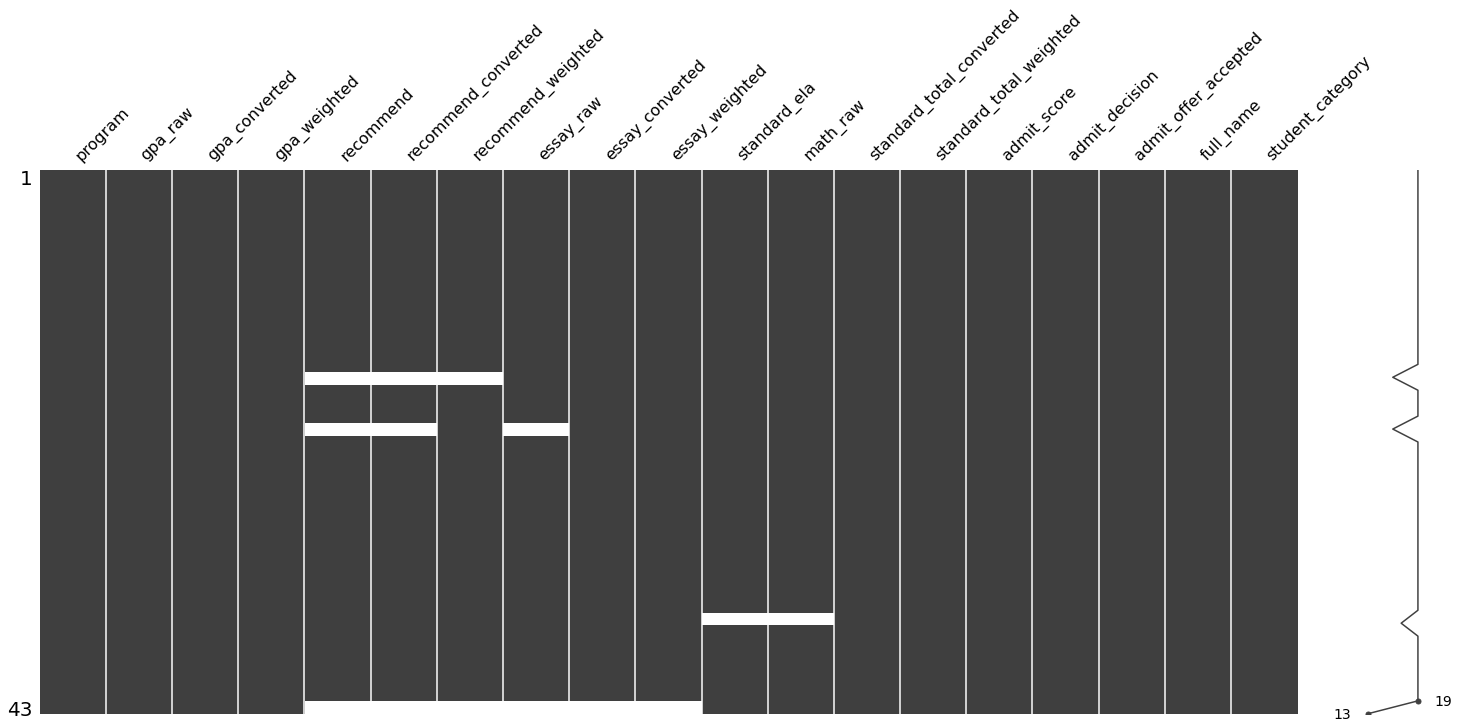

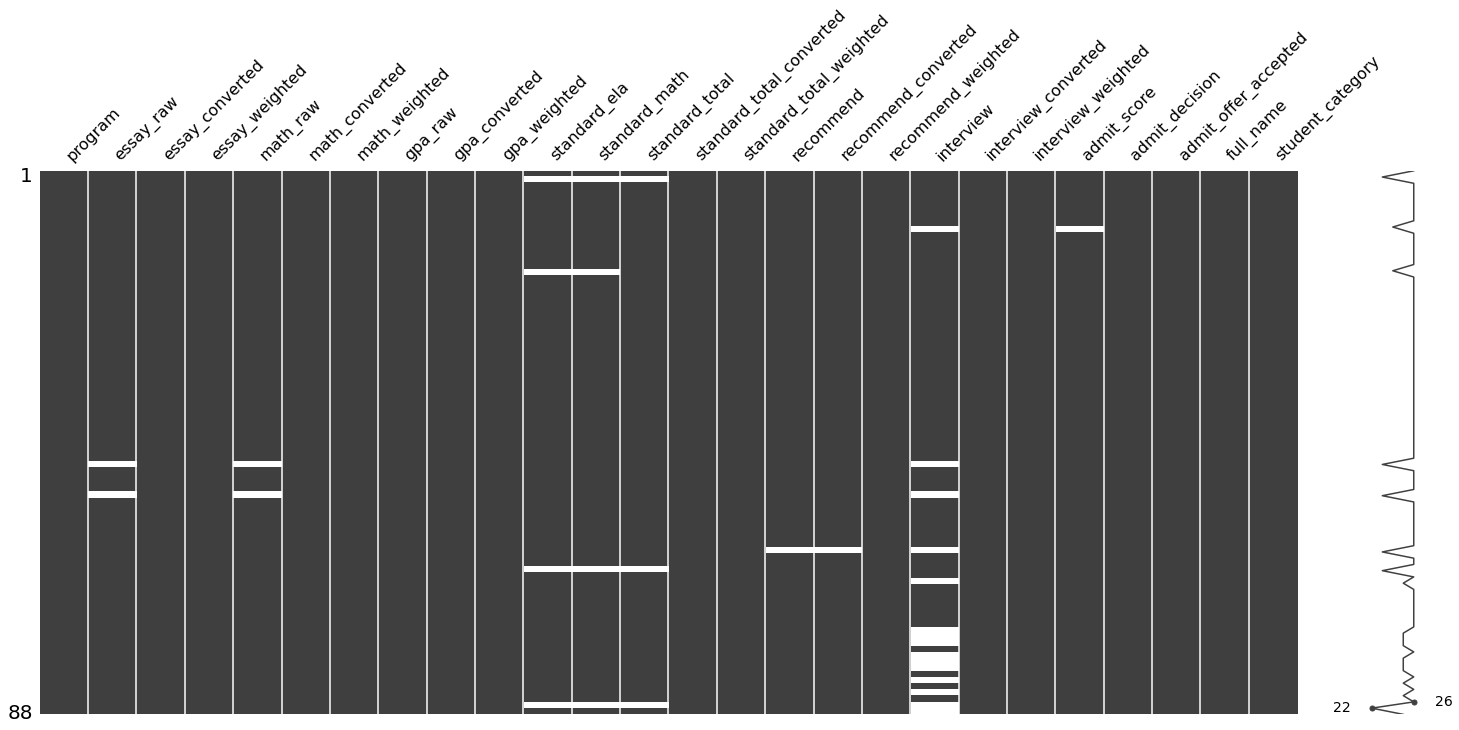

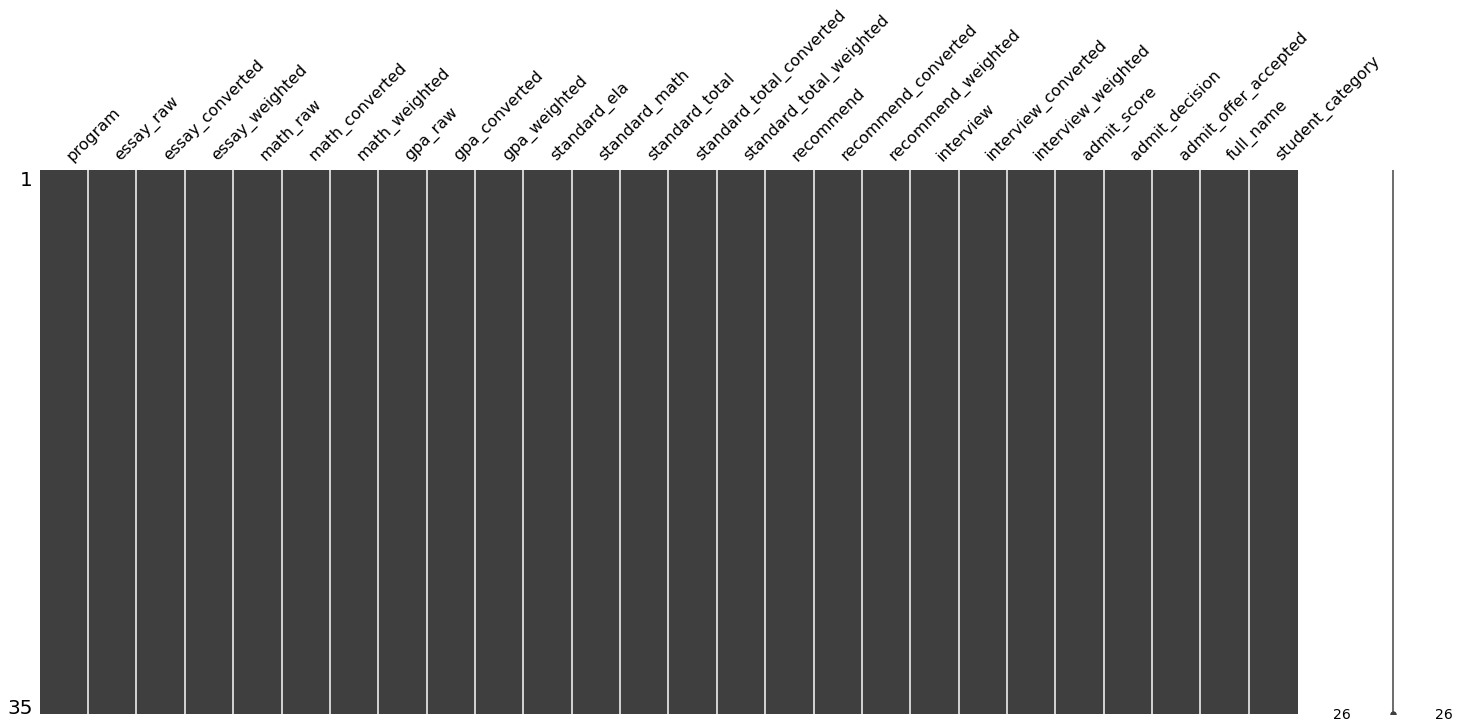

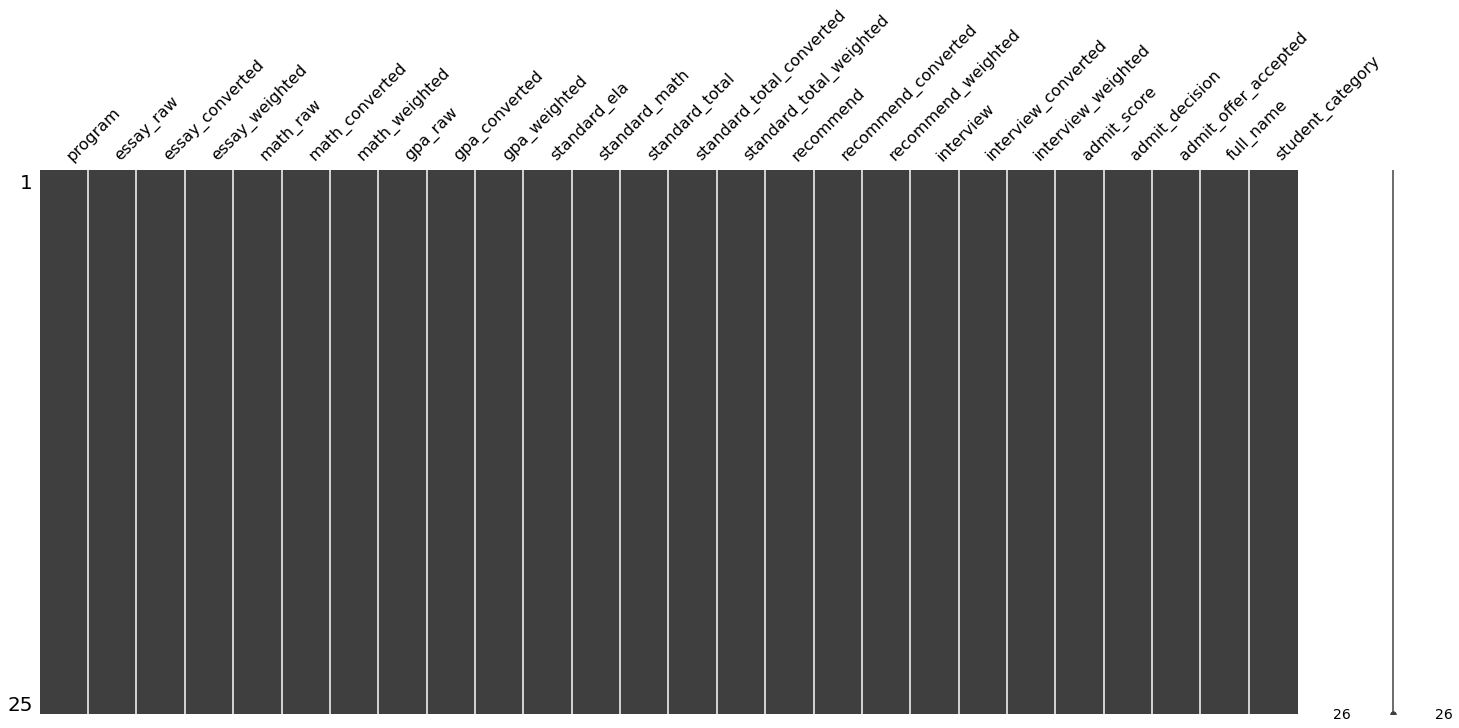

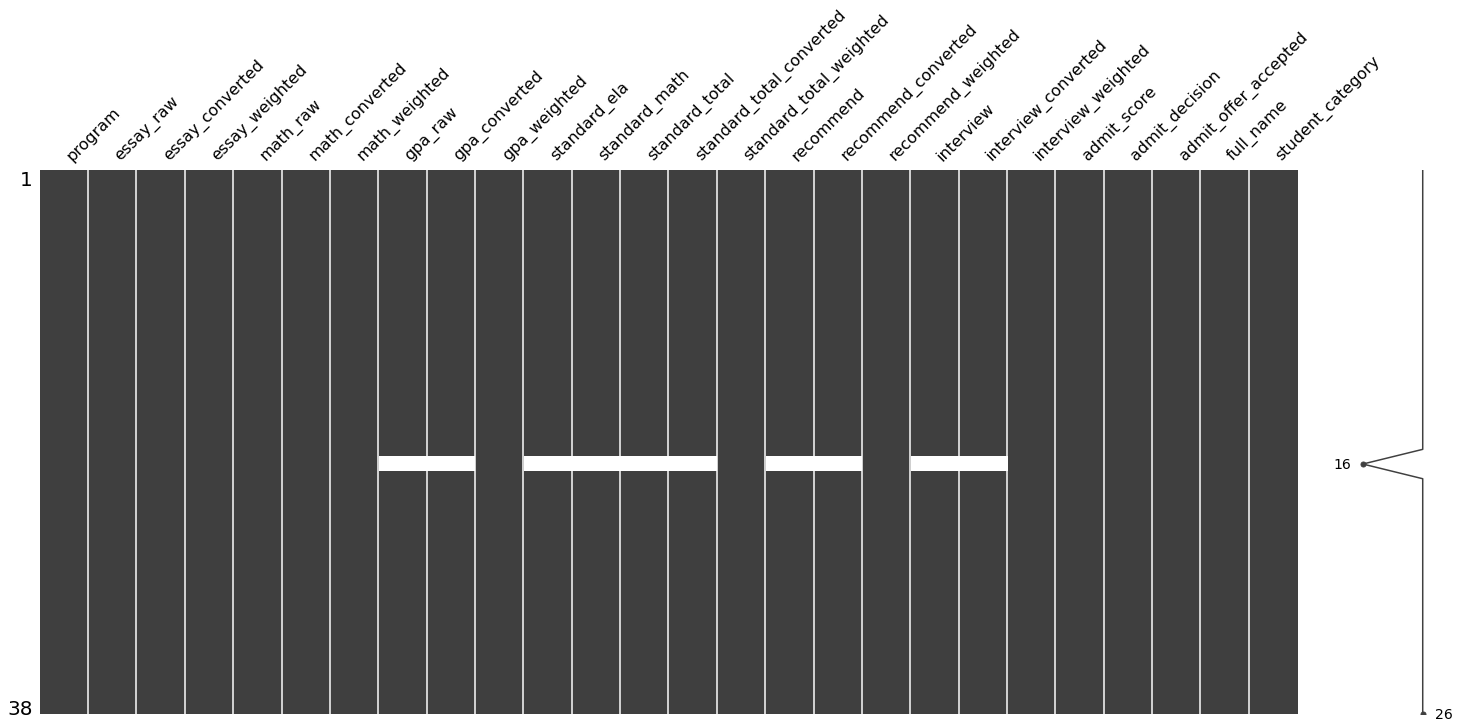

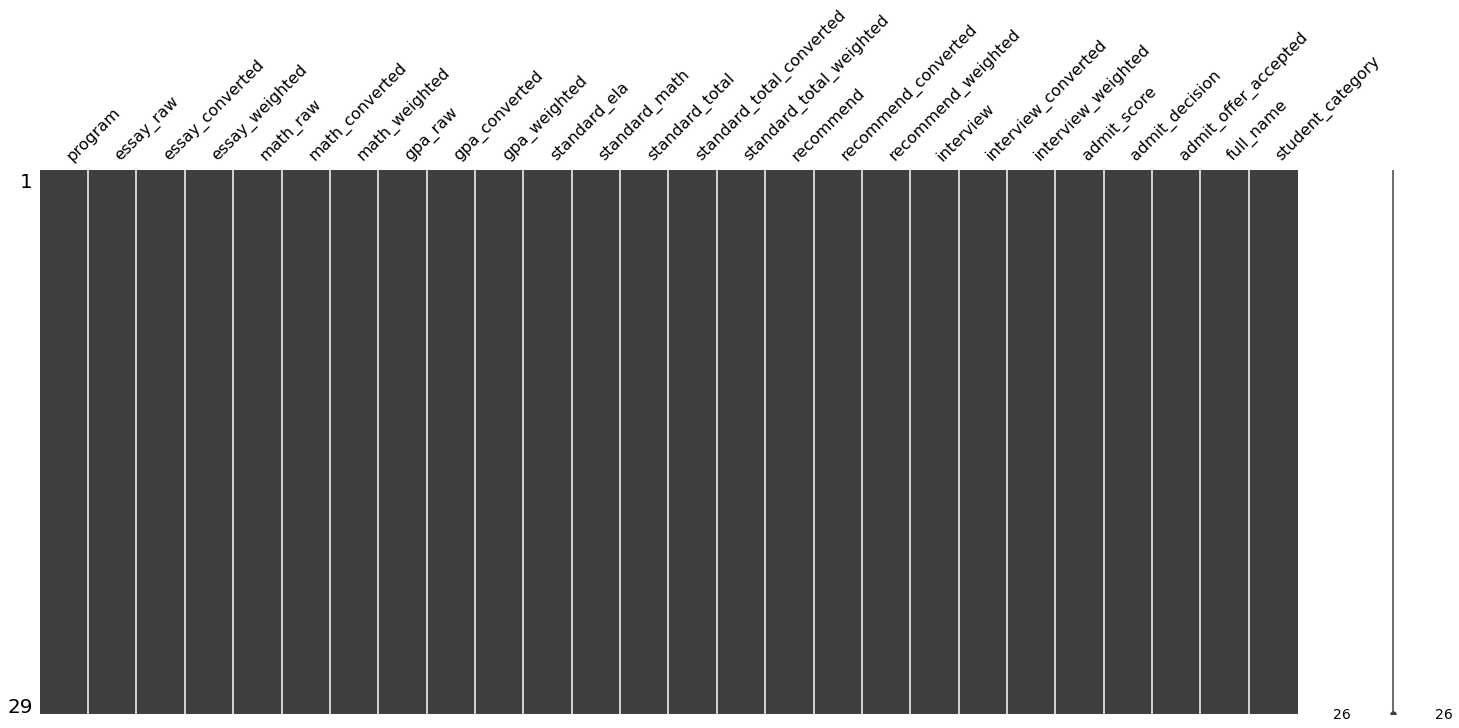

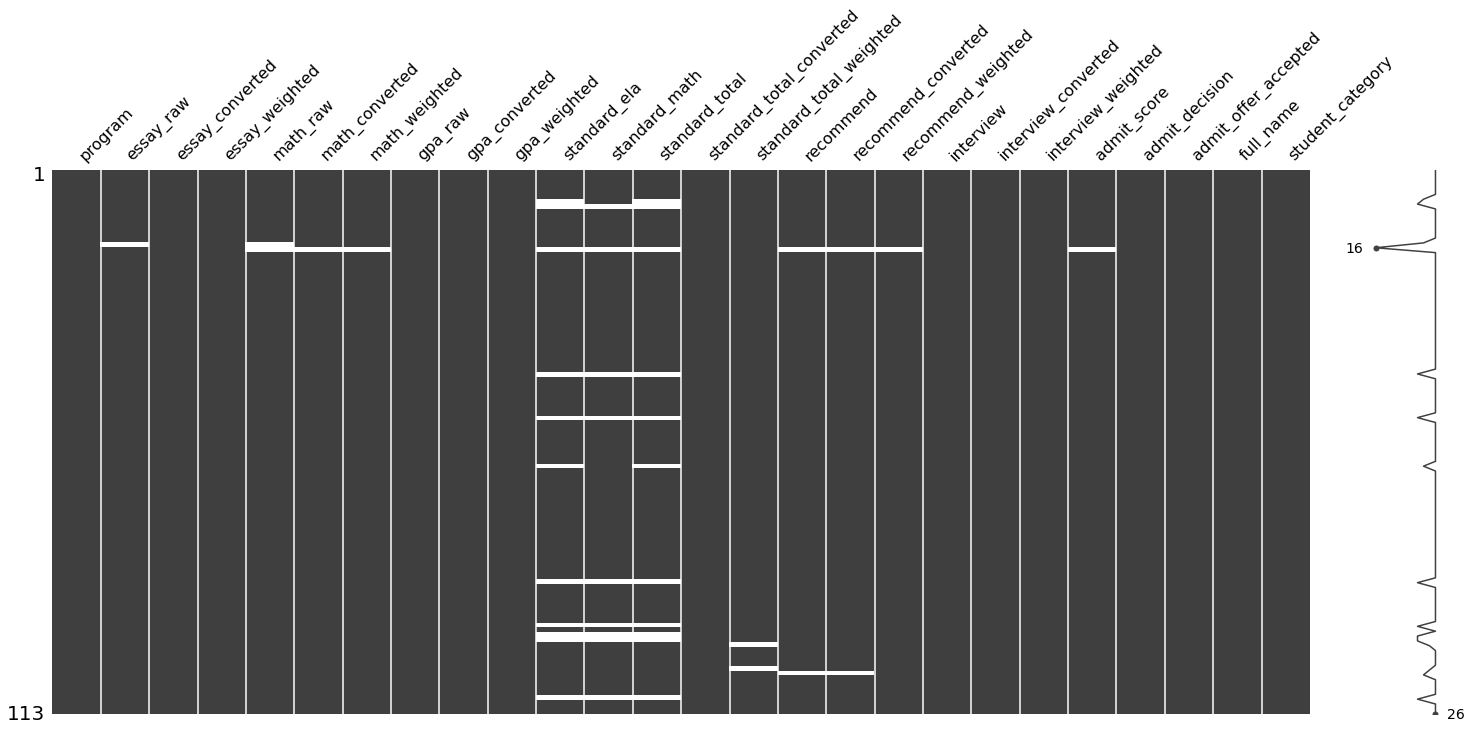

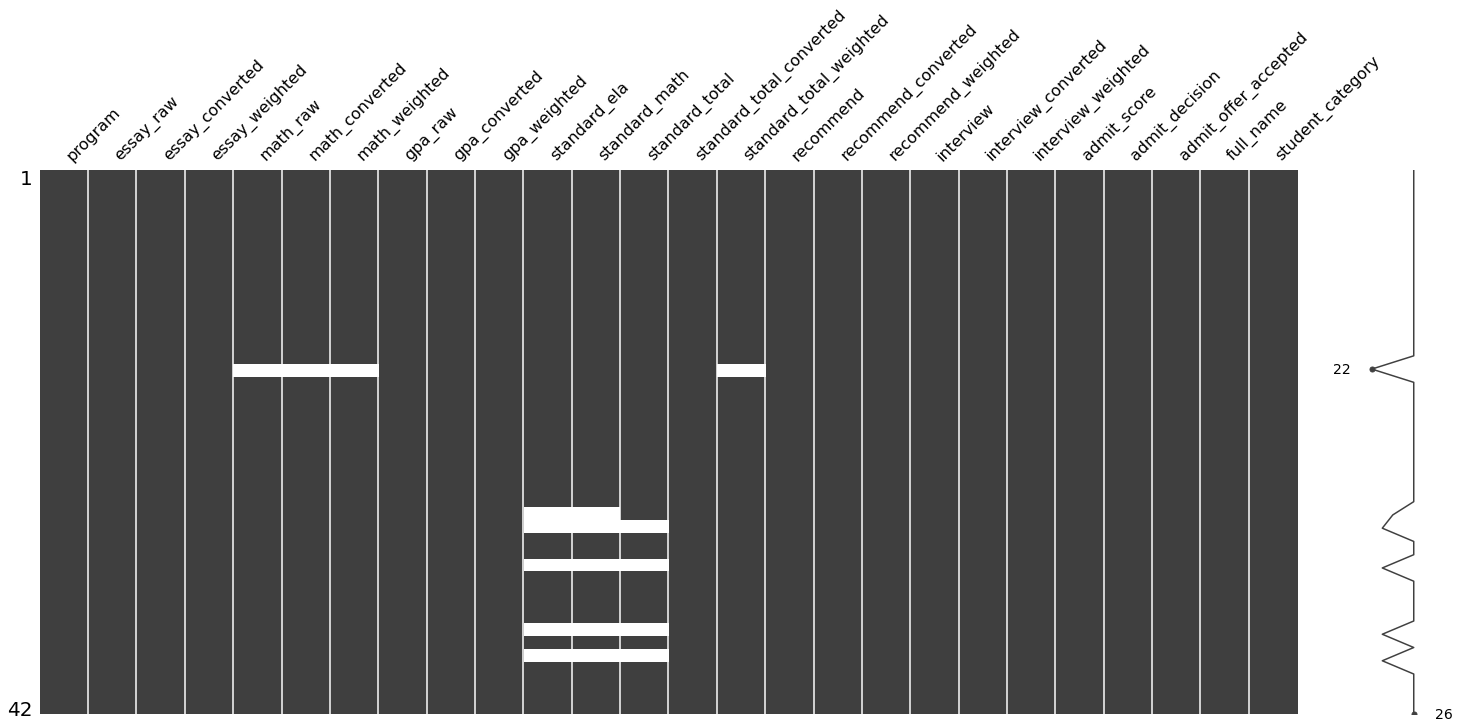

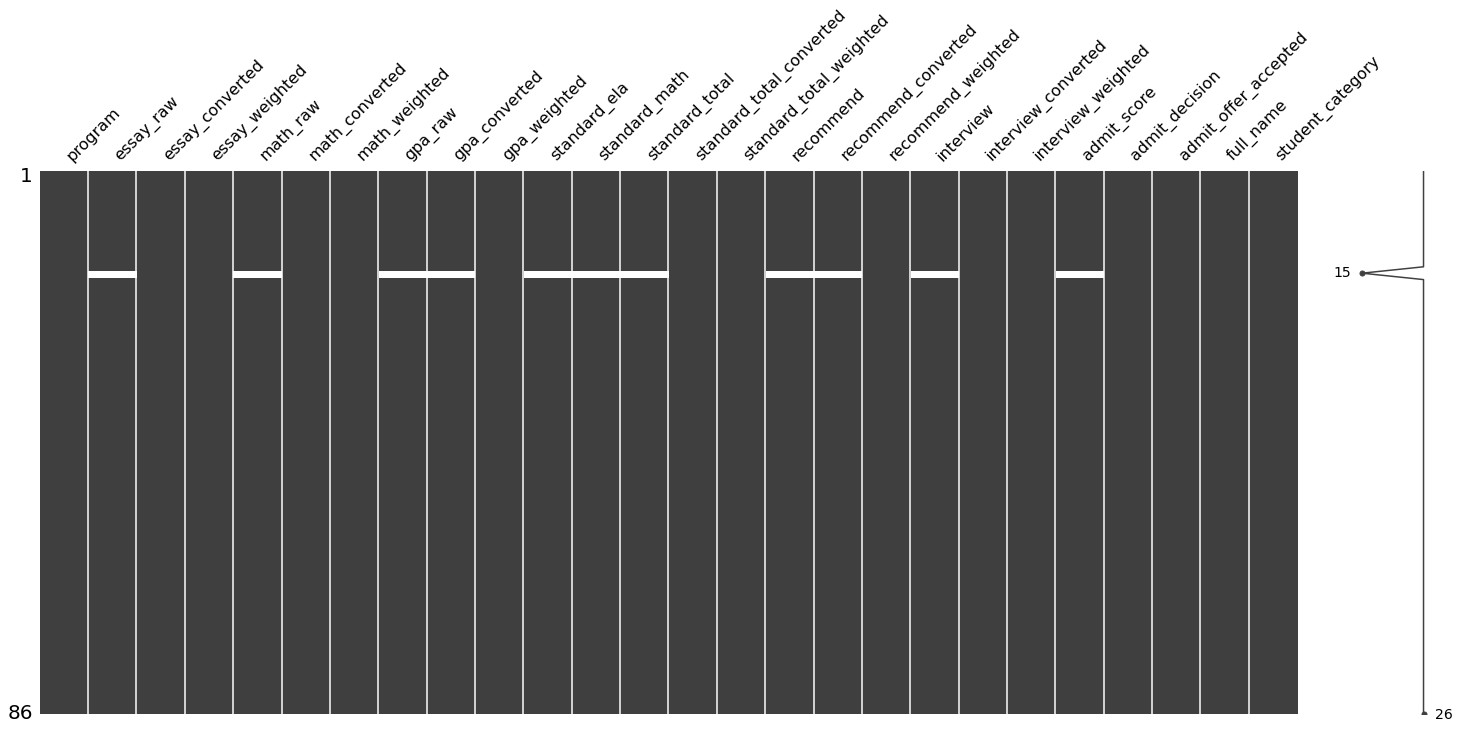

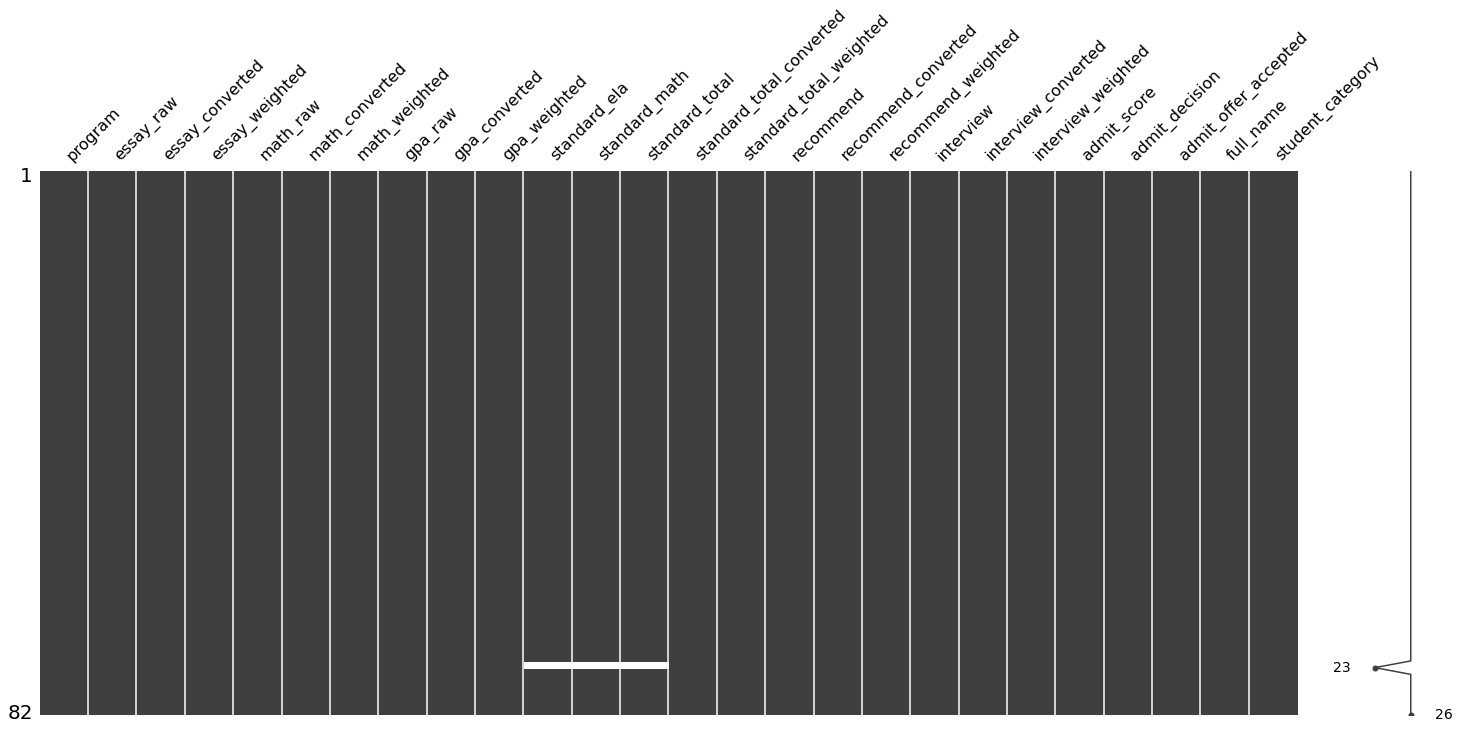

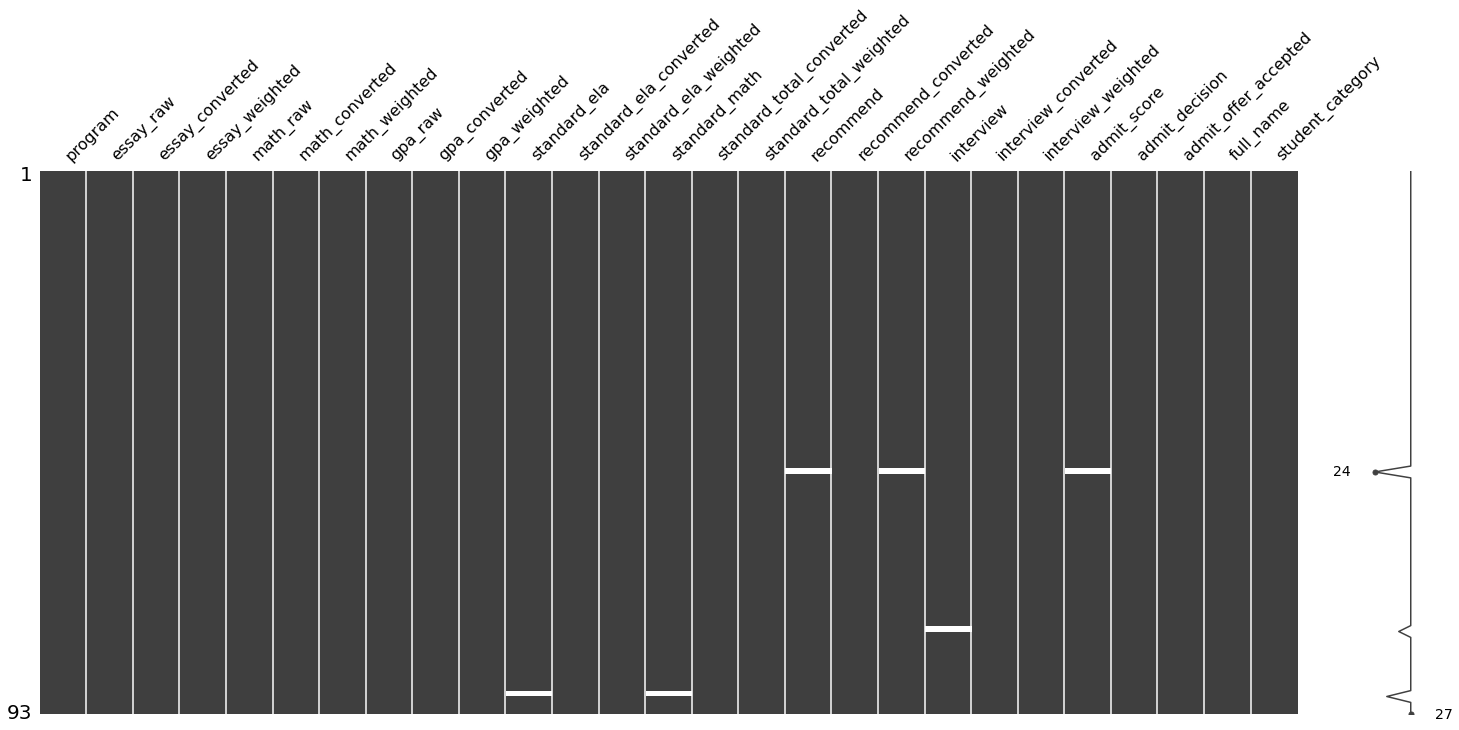

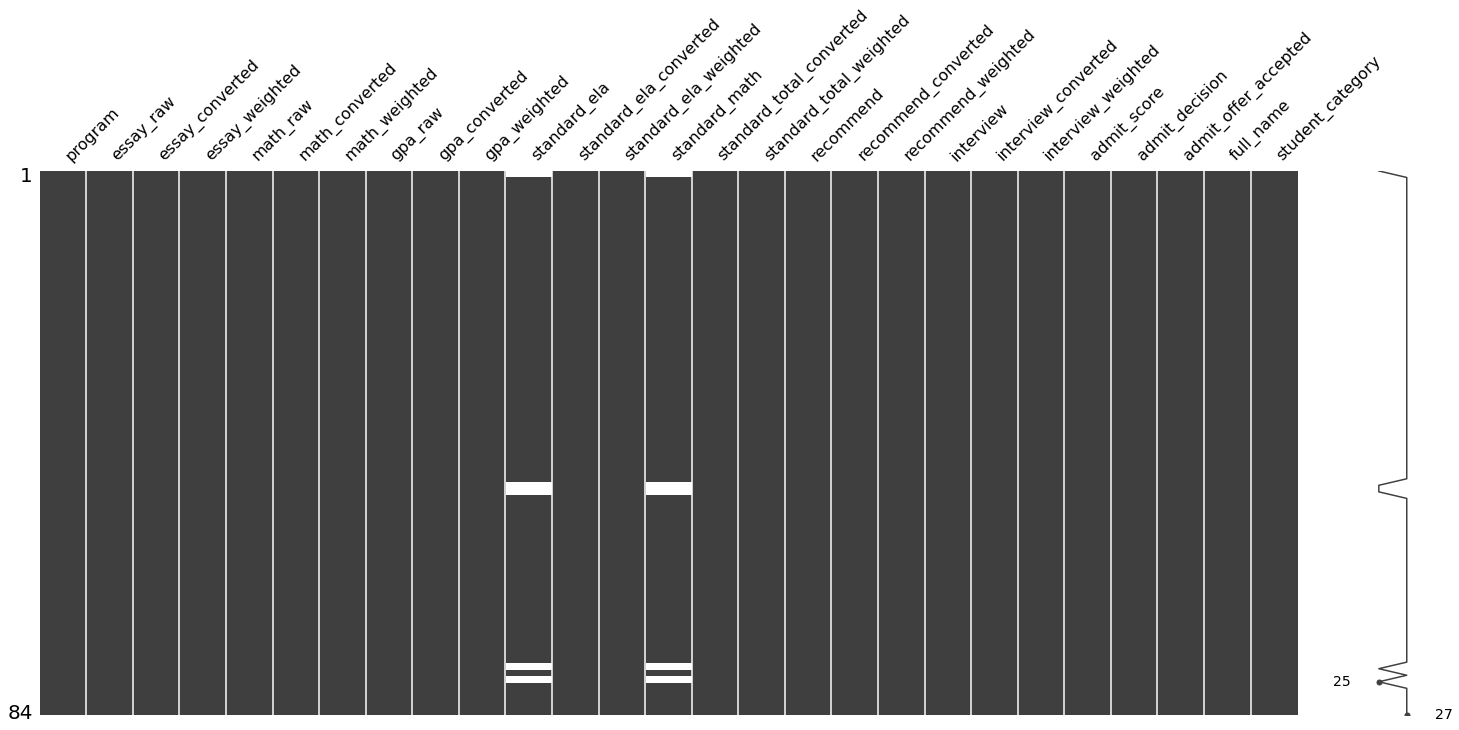

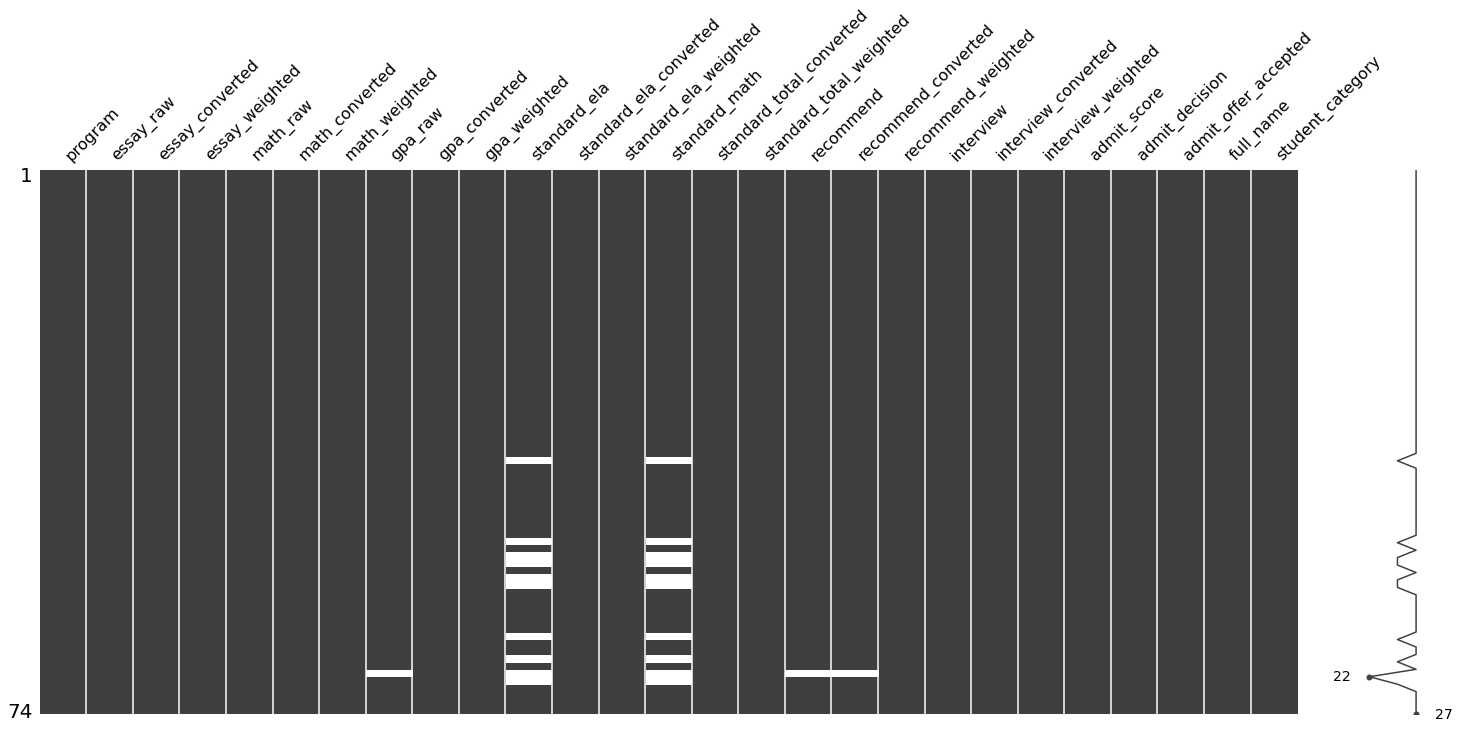

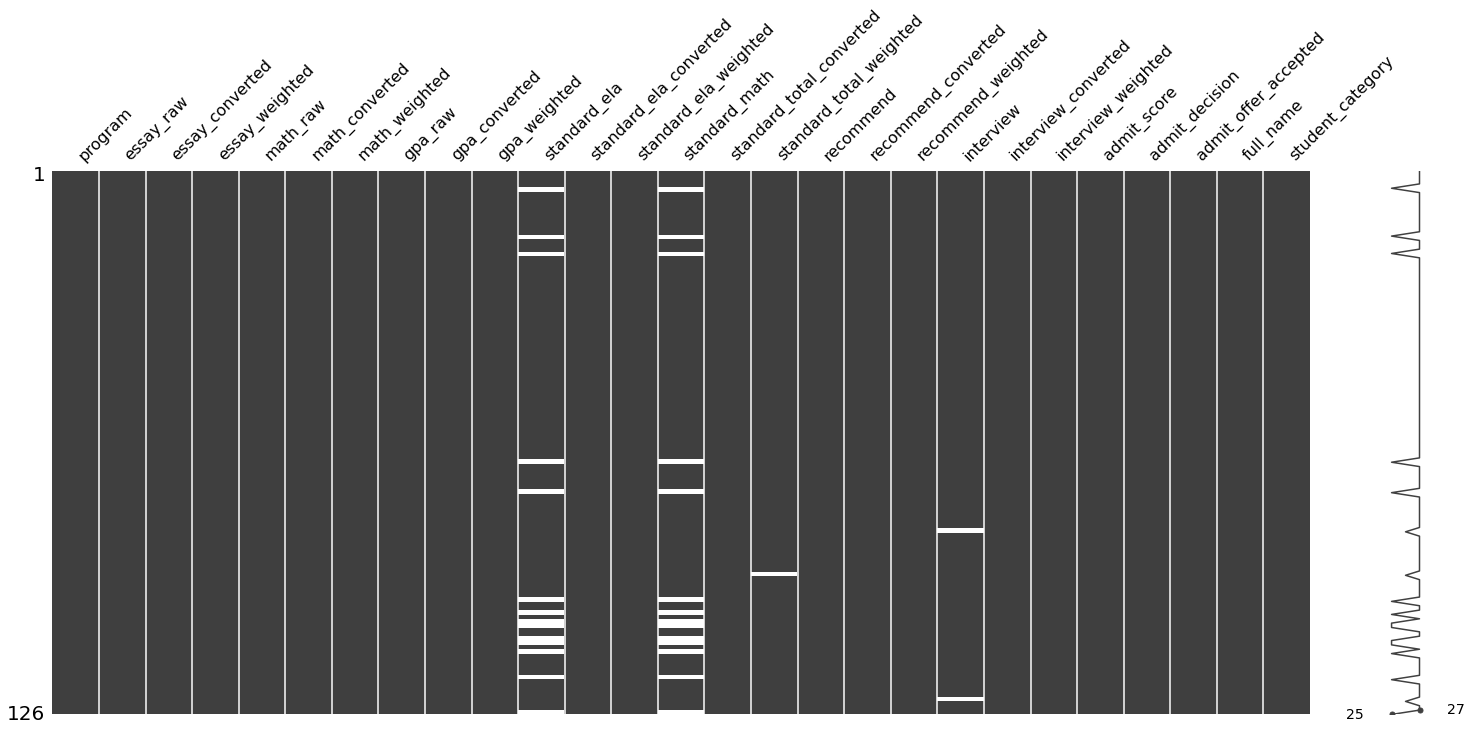

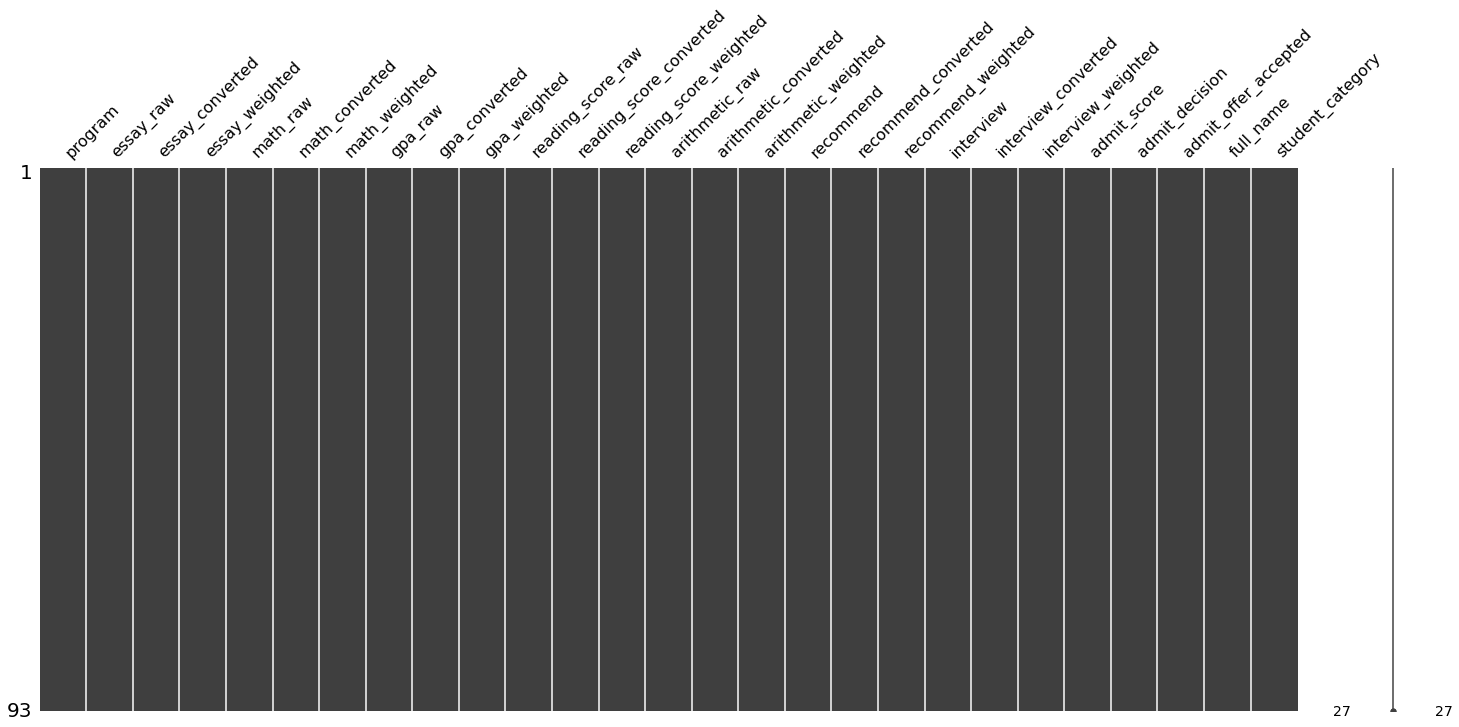

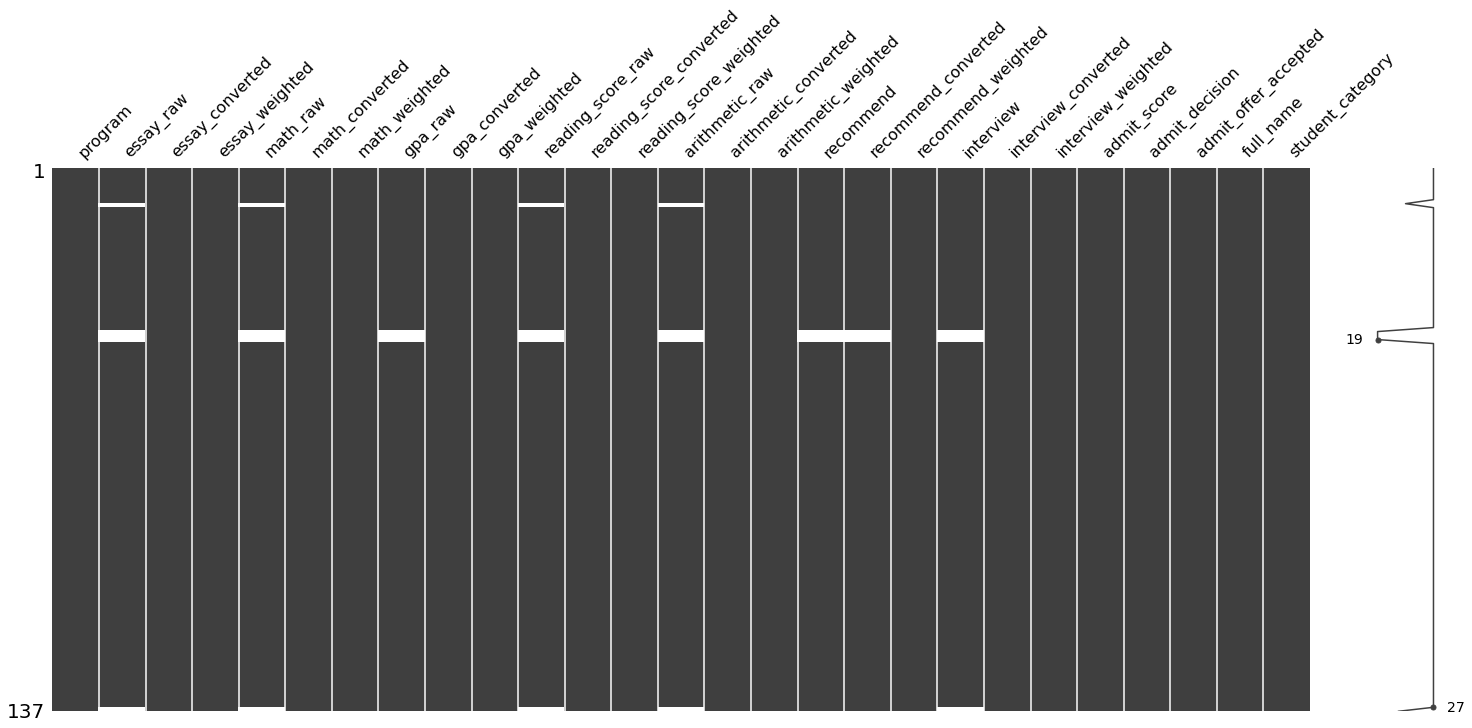

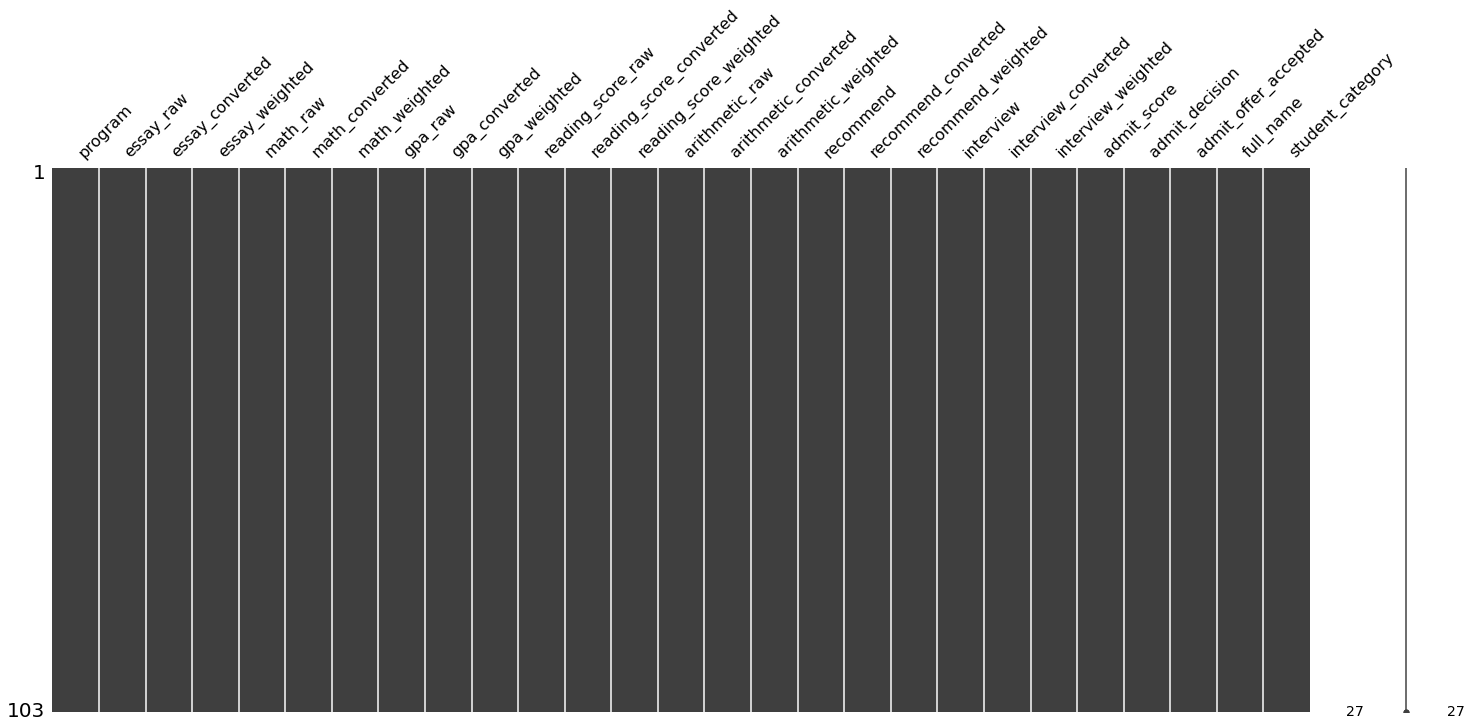

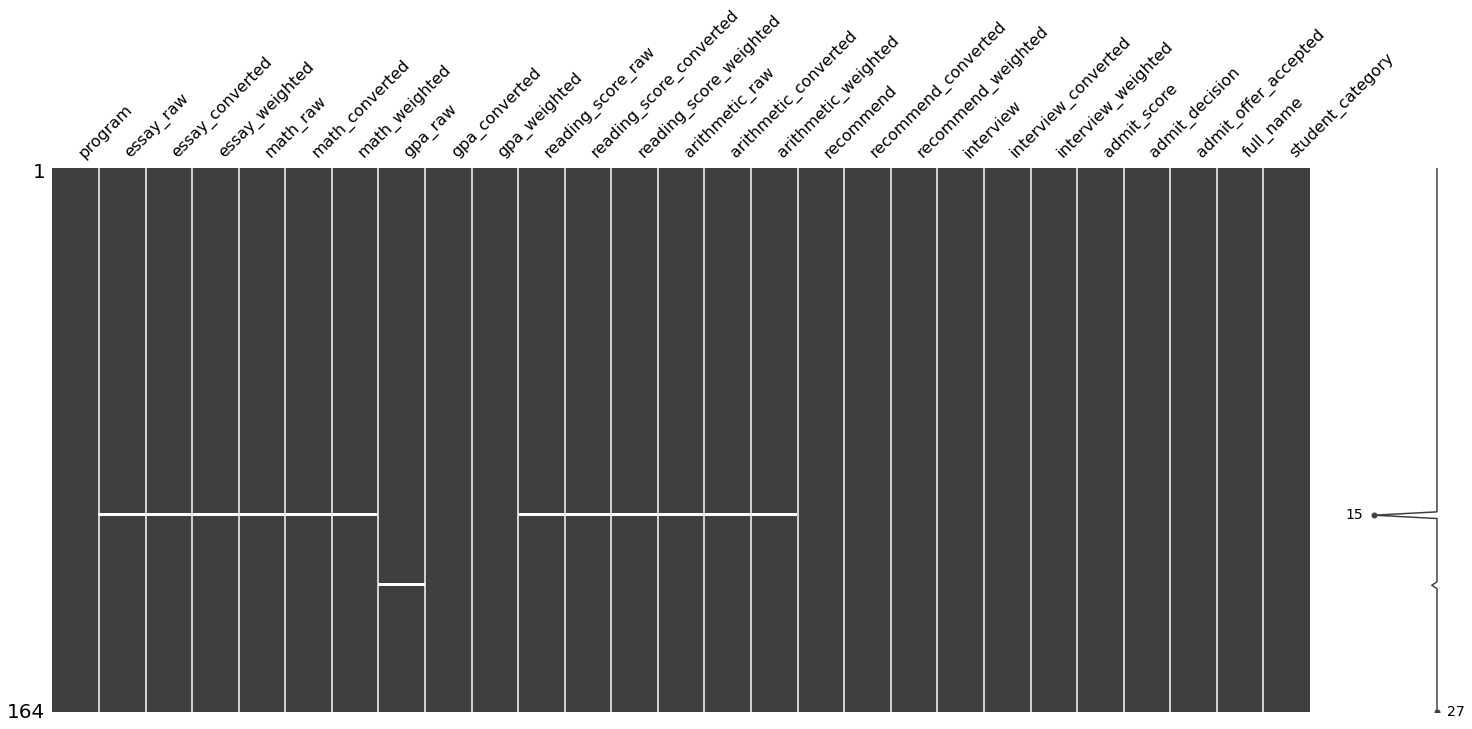

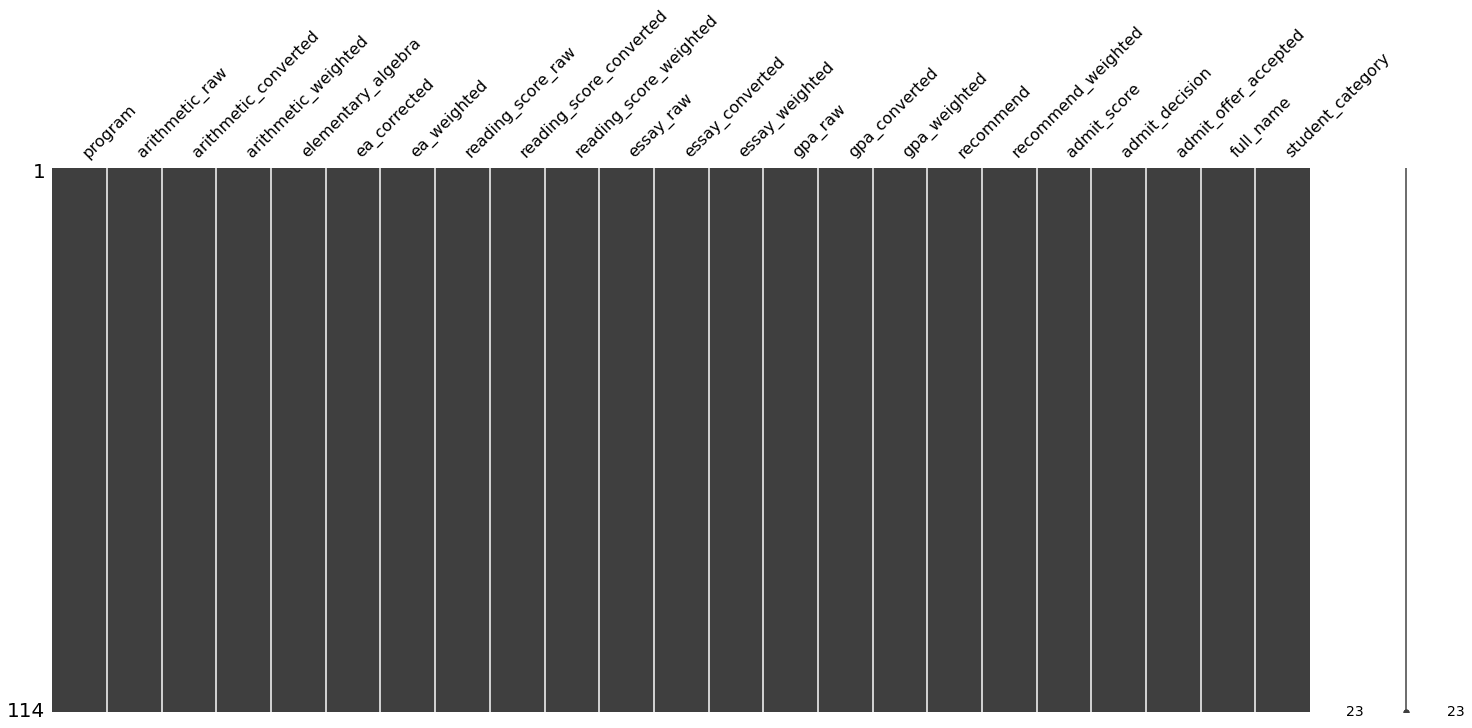

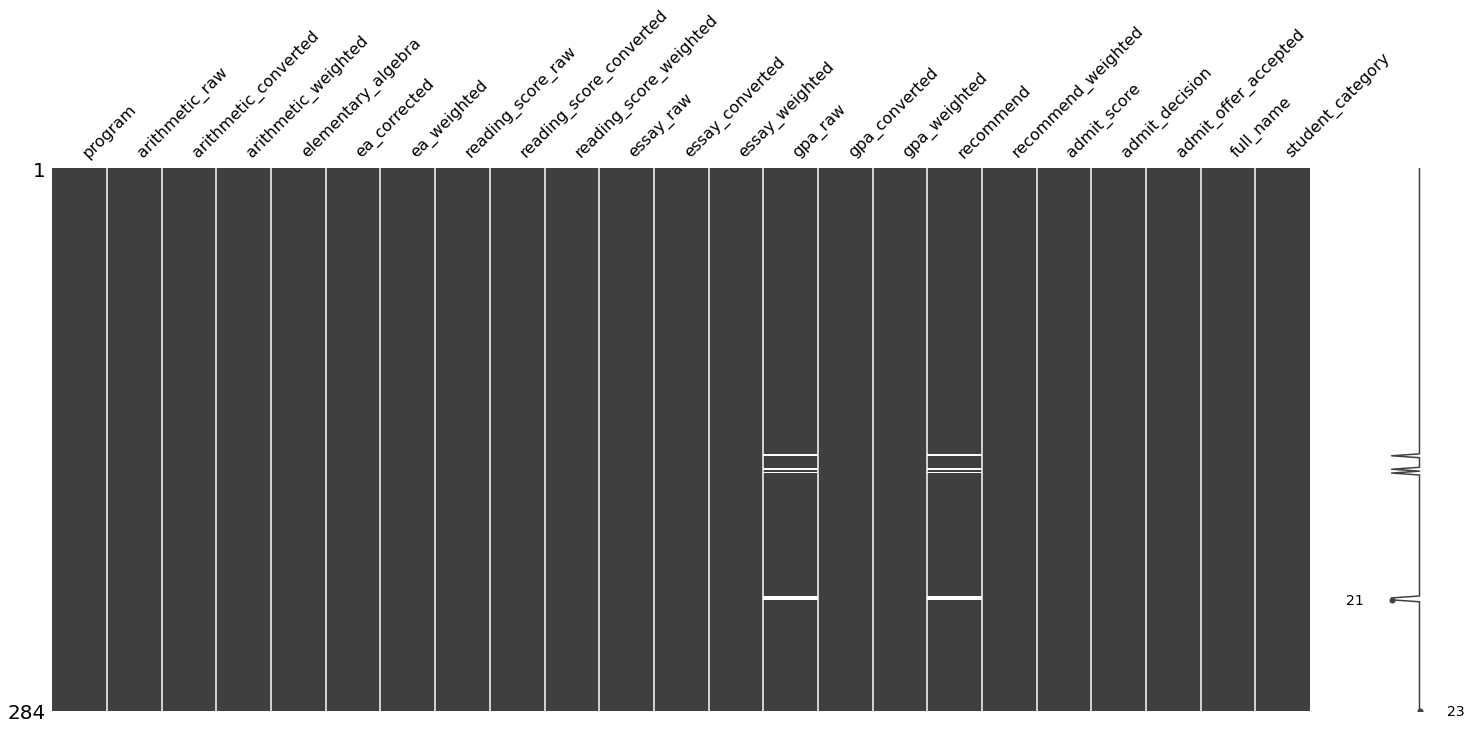

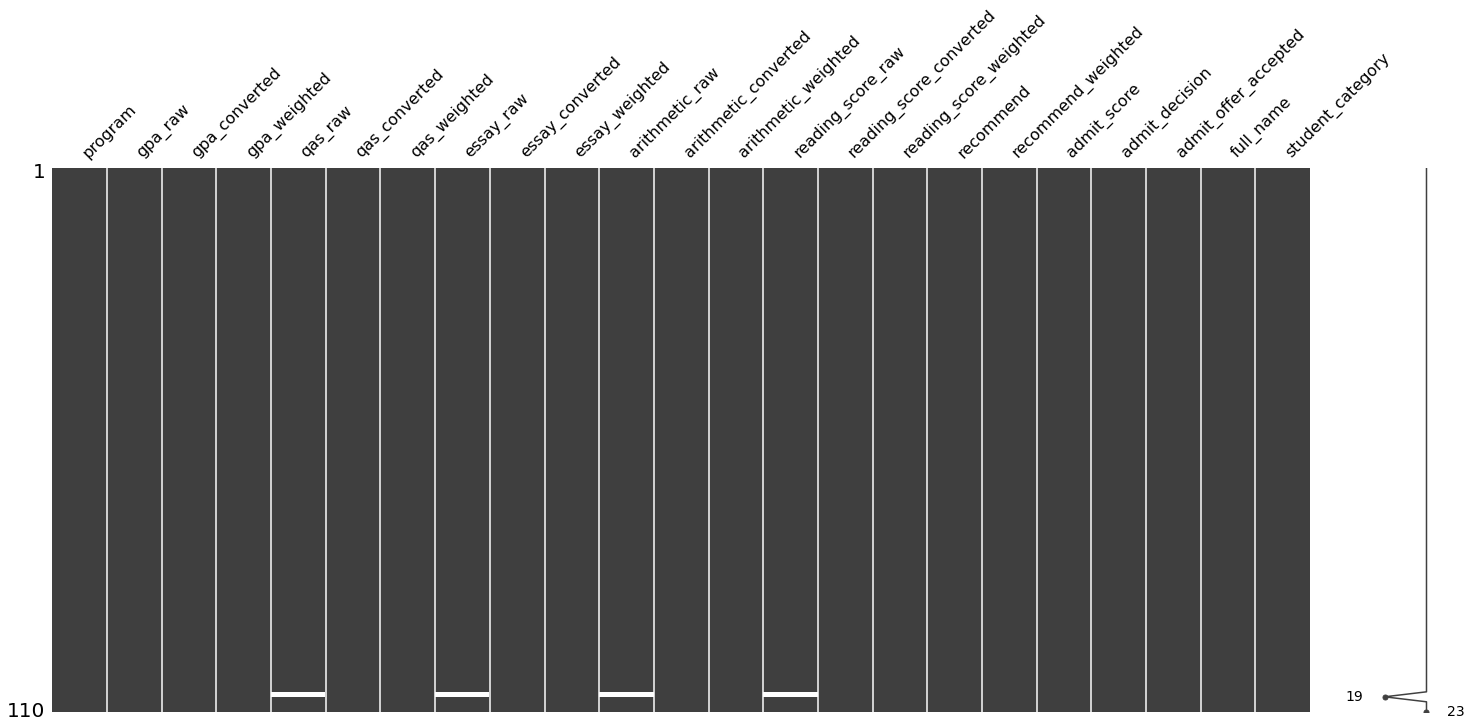

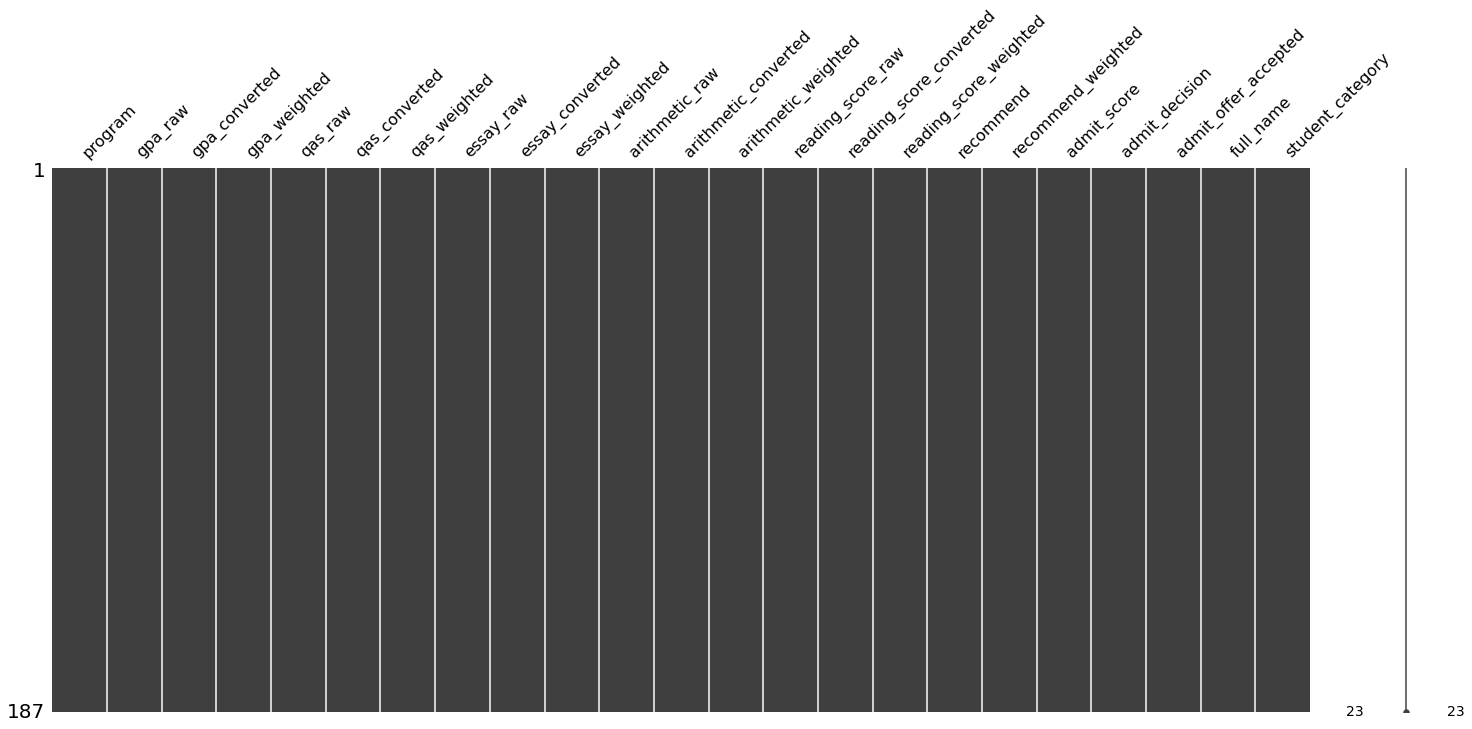

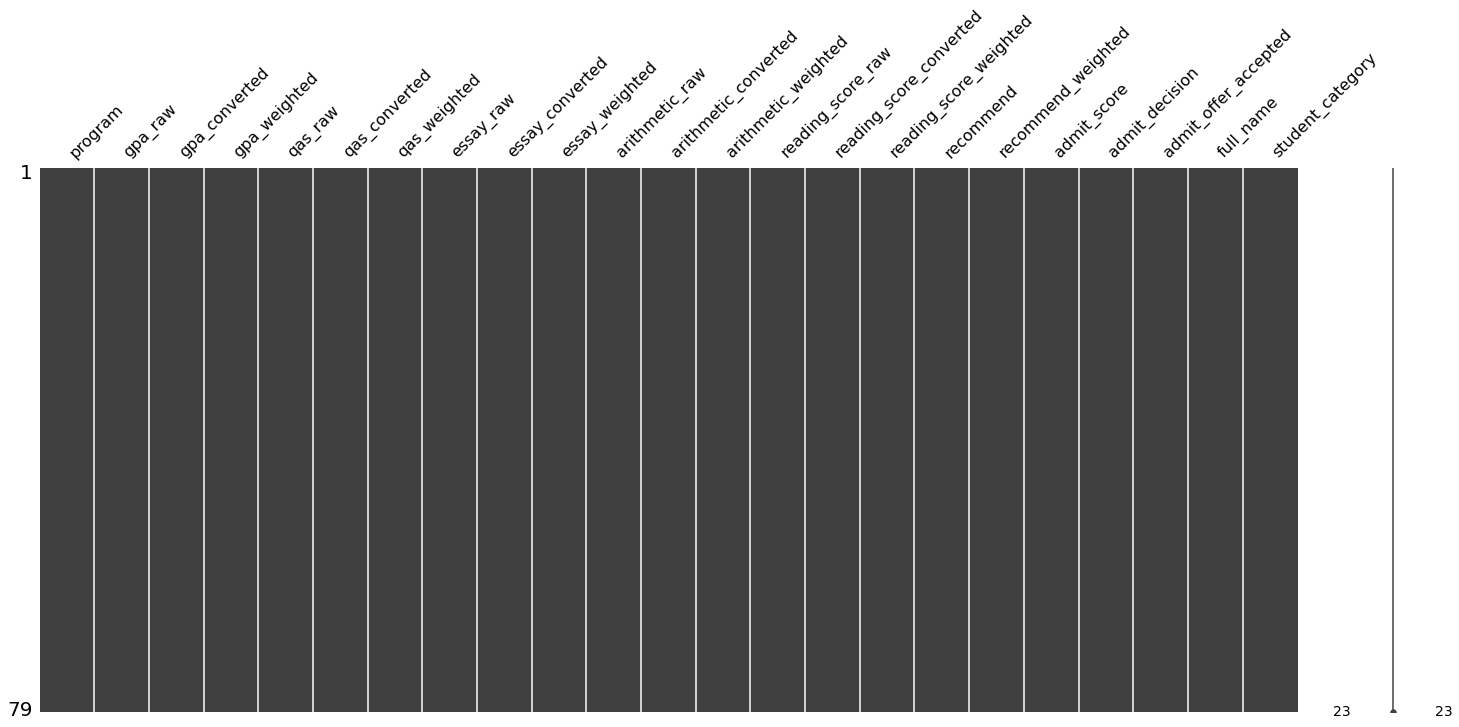

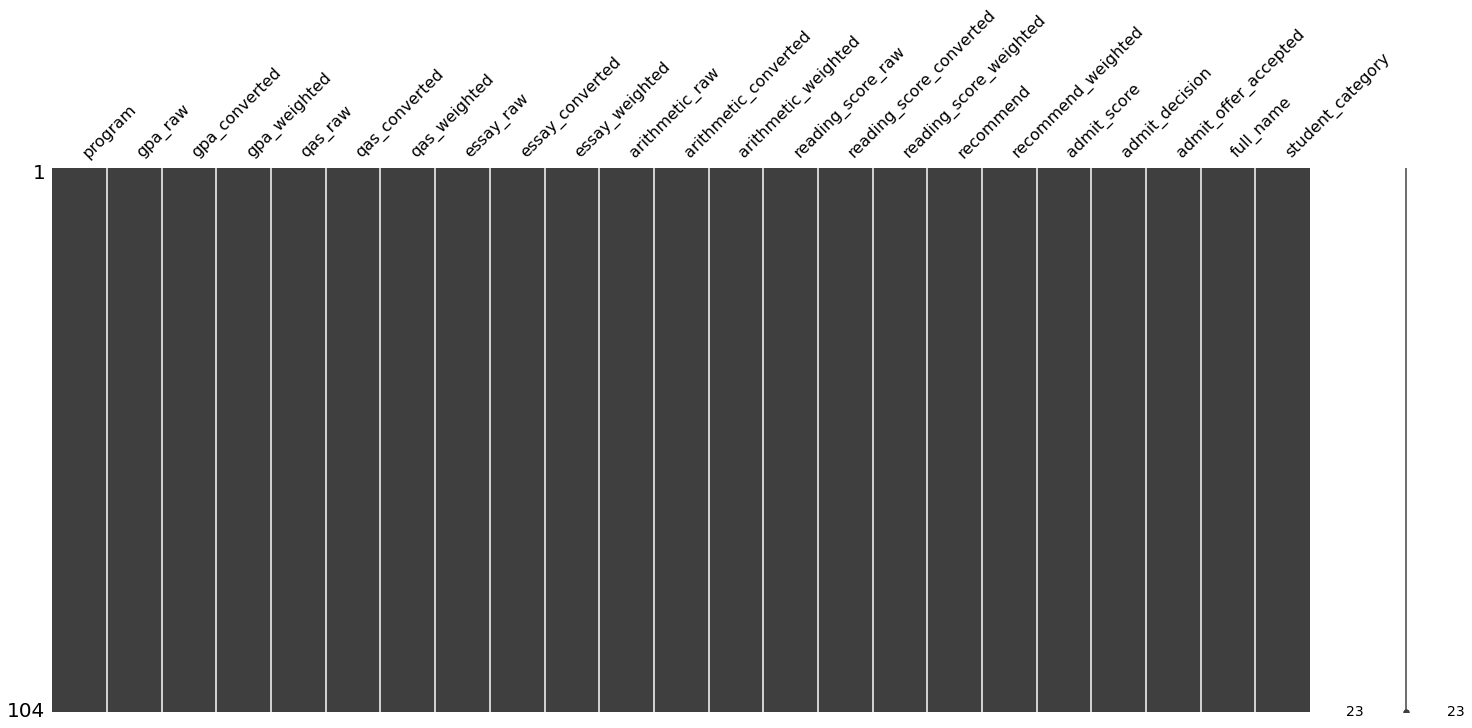

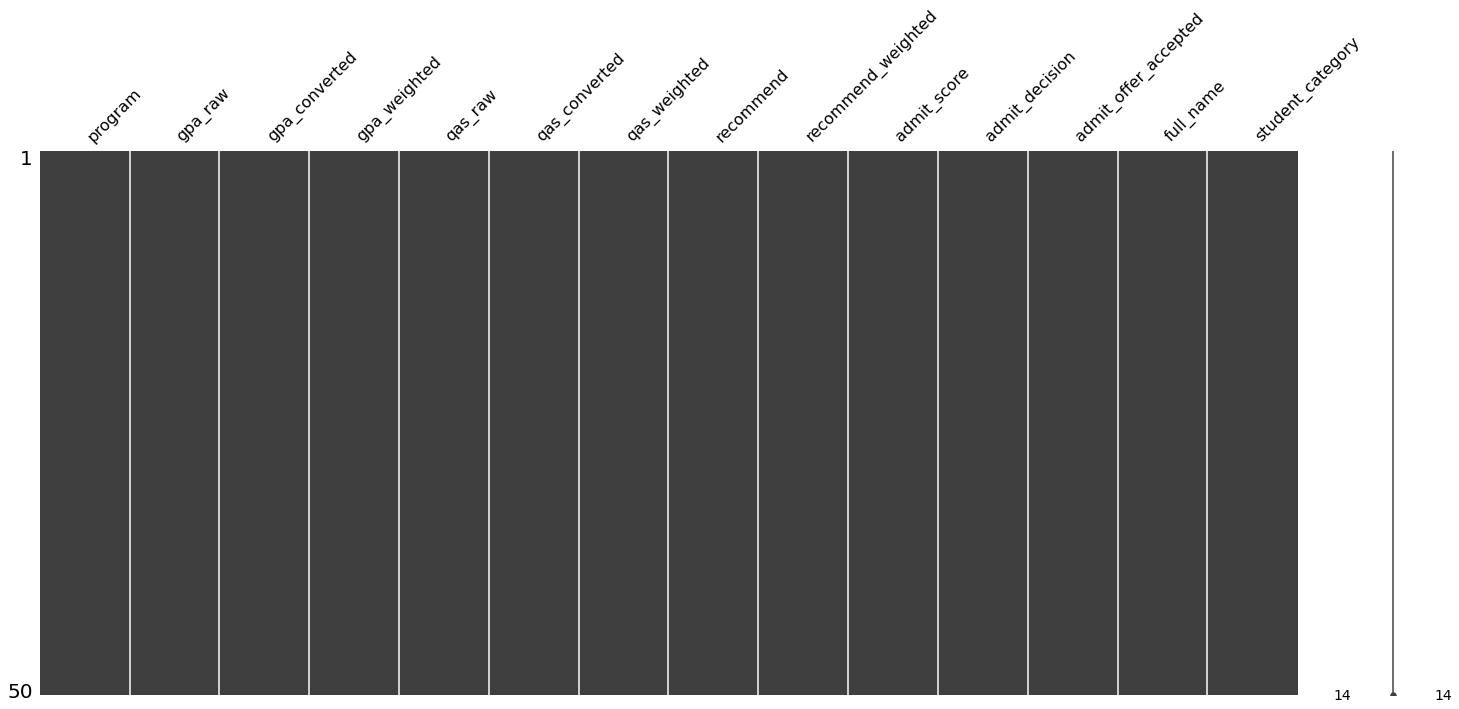

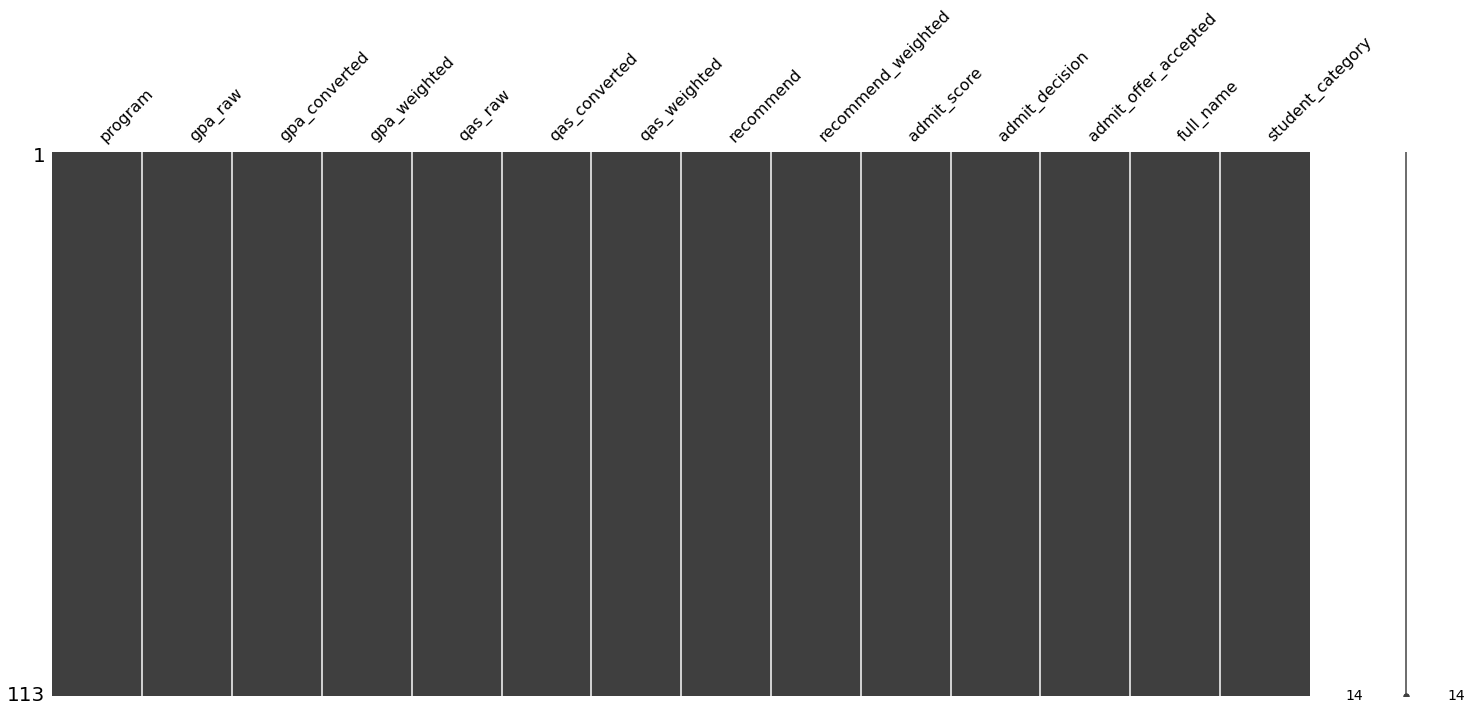

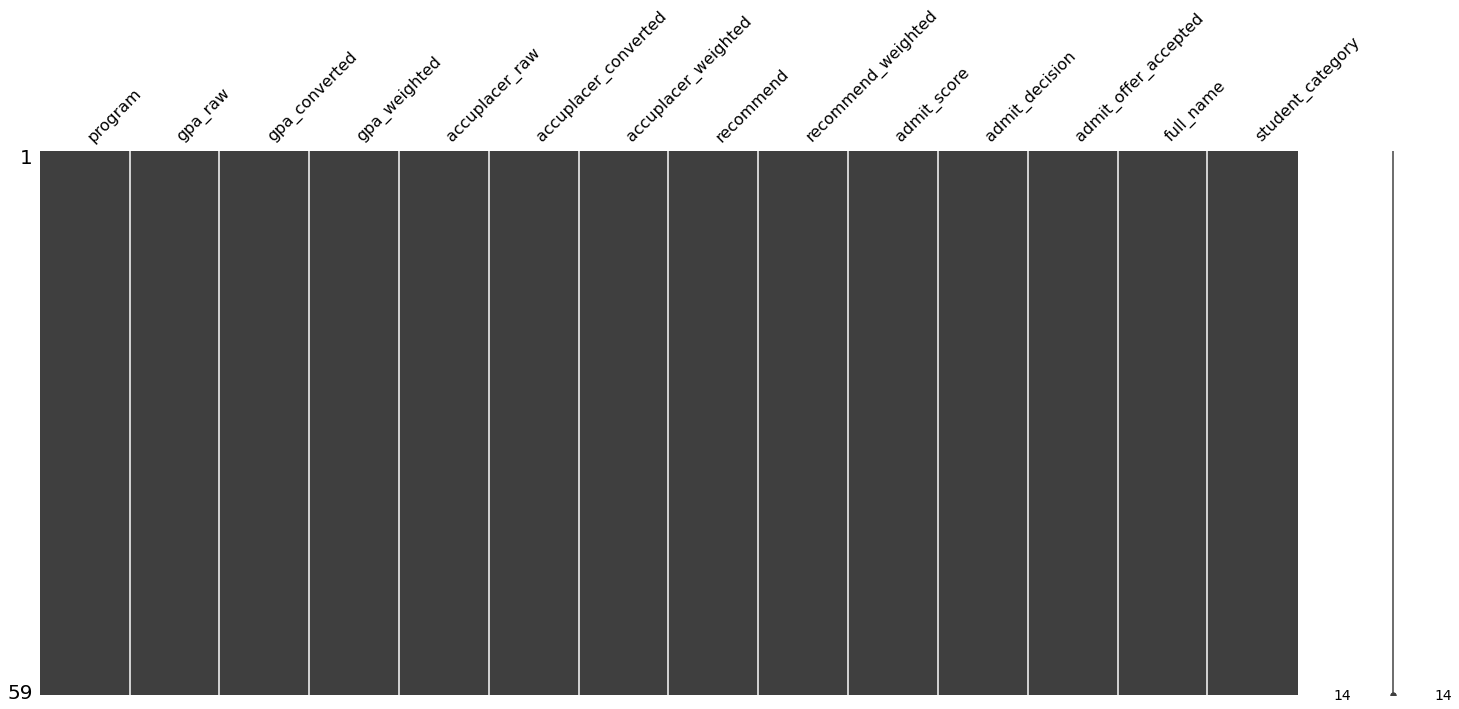

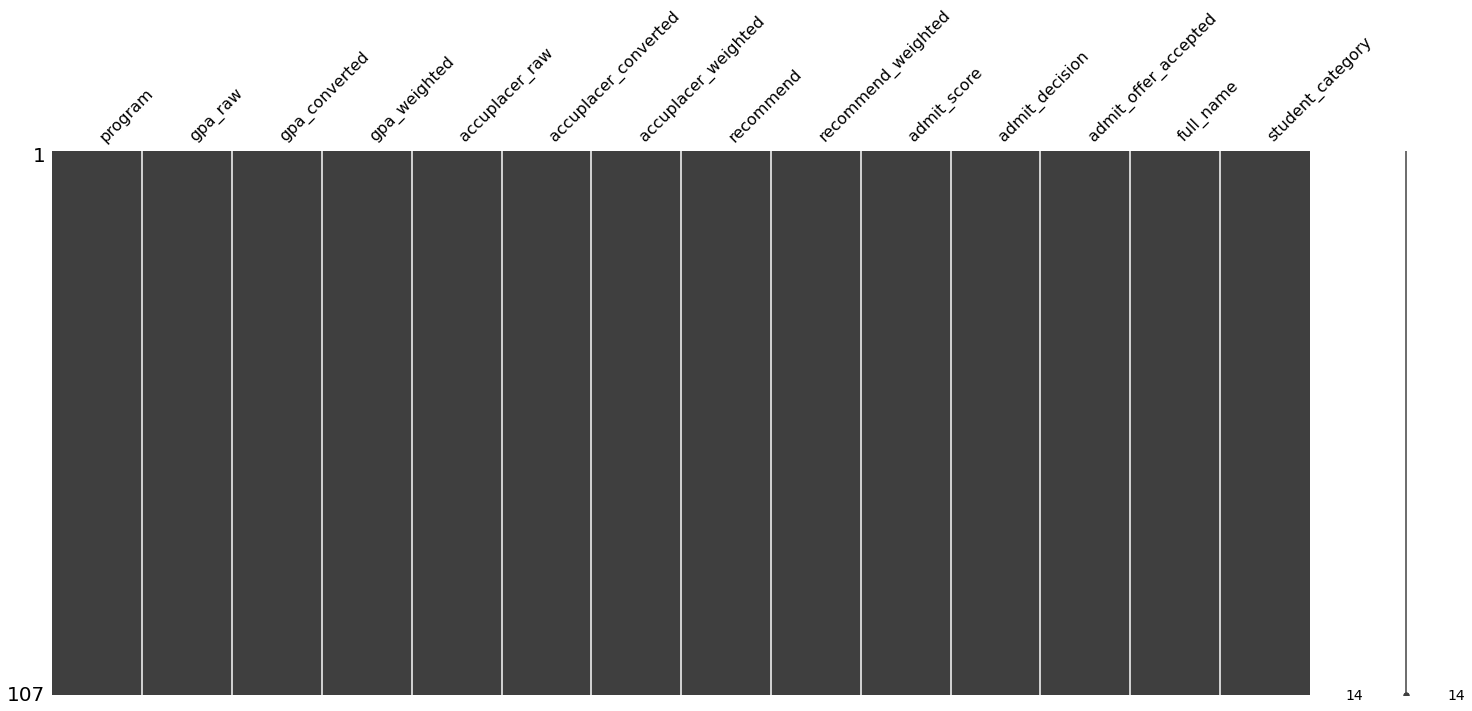

In [30]:
'''Visualize missing data'''
for key,item in var_dict.items():
    msno.matrix(item.sort_values('admit_decision'))

Given the low rate and nature of missingness, we are going to utilize KNN imputation to fill missing values.  However, in order to prevent data leakage, this will be conducted within a pipeline when we are ready to build our model.

### In the following cells, the missing data in each dataframe will be imputed and standardized separately. This will be done since different dependent measures were utilized across years.  Each year will be imputed and standarized separately and then the dataframes will be concatanated.

In [31]:
'''Pickle datafile'''
with open('mib_cleaned_data.pkl', 'wb') as f:
    pickle.dump(var_dict, f)

In [32]:
'''Open pickled file'''
with open('mib_cleaned_data.pkl', 'rb') as f:
    var_dict = pickle.load(f)

In [33]:
'''Impute outliers'''
impute_list_master = ['essay_raw', 'math_raw', 'arithmetic_raw', 'qas_raw', 'accuplacer_raw','gpa_raw','standard_ela', 'recommend']

for key, item in var_dict.items():
    for column in item.columns:
        if column in impute_list_master:
            if column == 'standard_ela':
                item['standard_ela'] = np.where(item['standard_ela'].max() > 225 and item['standard_ela'] < 150, item['standard_ela'].mean(), item['standard_ela'])
            if column == 'essay_raw':
                item['essay_raw'] = np.where(item['essay_raw'].max() > 15 and item['essay_raw'] < 55, item['essay_raw'].mean(), item['essay_raw'])
                item['essay_raw'] = np.where(item['essay_raw'].max() < 15 and item['essay_raw'] < 2, item['essay_raw'].mean(), item['essay_raw'])
            if column == 'recommend':
                item['recommend'] = np.where(item['recommend'] < 40, item['recommend'].mean(), item['recommend'])
            if column == 'gpa_raw':
                item['gpa_raw'] = np.where(item['gpa_raw'] < 60, item['gpa_raw'].mean(), item['gpa_raw'])
            if column == 'math_raw':
                item['math_raw'] = np.where(item['math_raw'] < 30, item['math_raw'].mean(), item['math_raw'])
            if column == 'arithmetic_raw':
                item['arithmetic_raw'] = np.where(item['arithmetic_raw'] < 40, item['arithmetic_raw'].mean(), item['arithmetic_raw'])

['gpa_raw', 'recommend', 'essay_raw', 'standard_ela', 'math_raw']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'standard_ela', 'recommend']
['essay_raw', 'math_raw', 'gpa_raw', 'arithmetic_raw', 'recommend']
['essay_

C:\Users\scott\anaconda3\lib\site-packages\seaborn\axisgrid.py:1176: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(len(y_vars), len(x_vars),


['gpa_raw', 'qas_raw', 'essay_raw', 'arithmetic_raw', 'recommend']
['gpa_raw', 'qas_raw', 'essay_raw', 'arithmetic_raw', 'recommend']
['gpa_raw', 'qas_raw', 'essay_raw', 'arithmetic_raw', 'recommend']
['gpa_raw', 'qas_raw', 'recommend']
['gpa_raw', 'qas_raw', 'recommend']
['gpa_raw', 'accuplacer_raw', 'recommend']
['gpa_raw', 'accuplacer_raw', 'recommend']


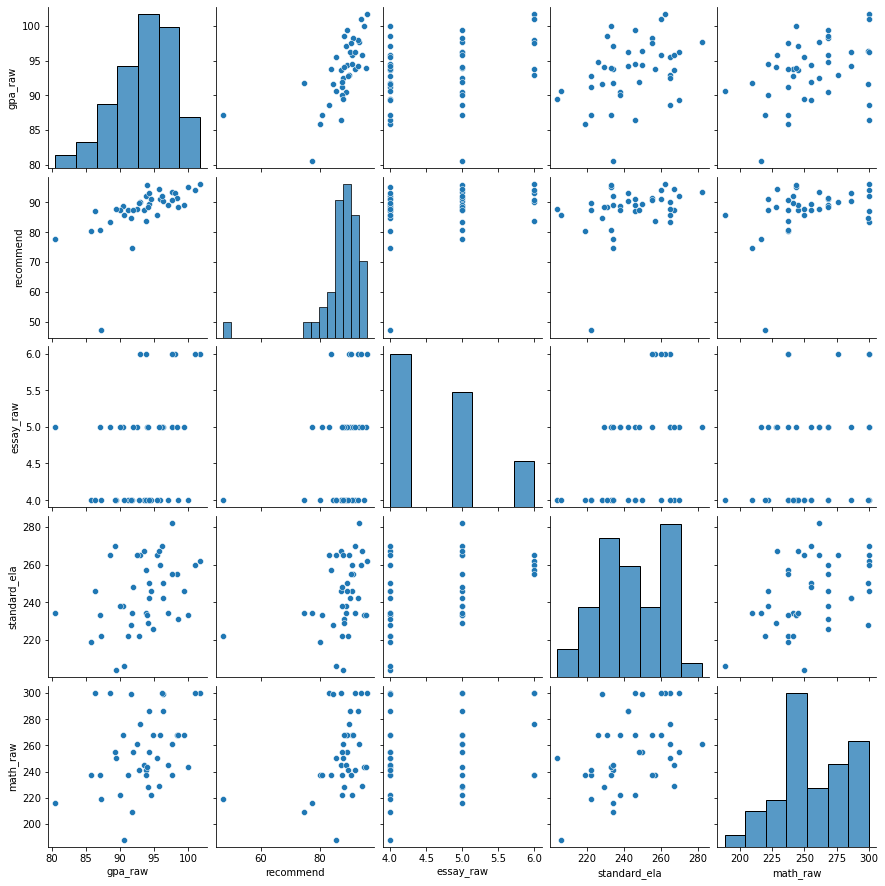

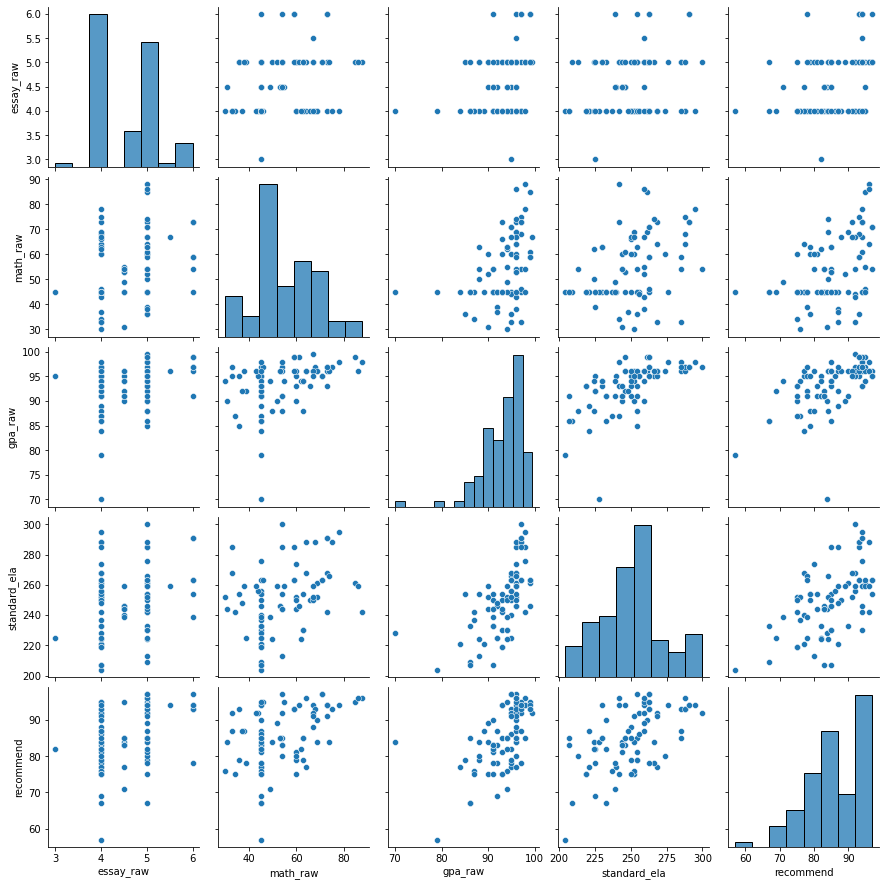

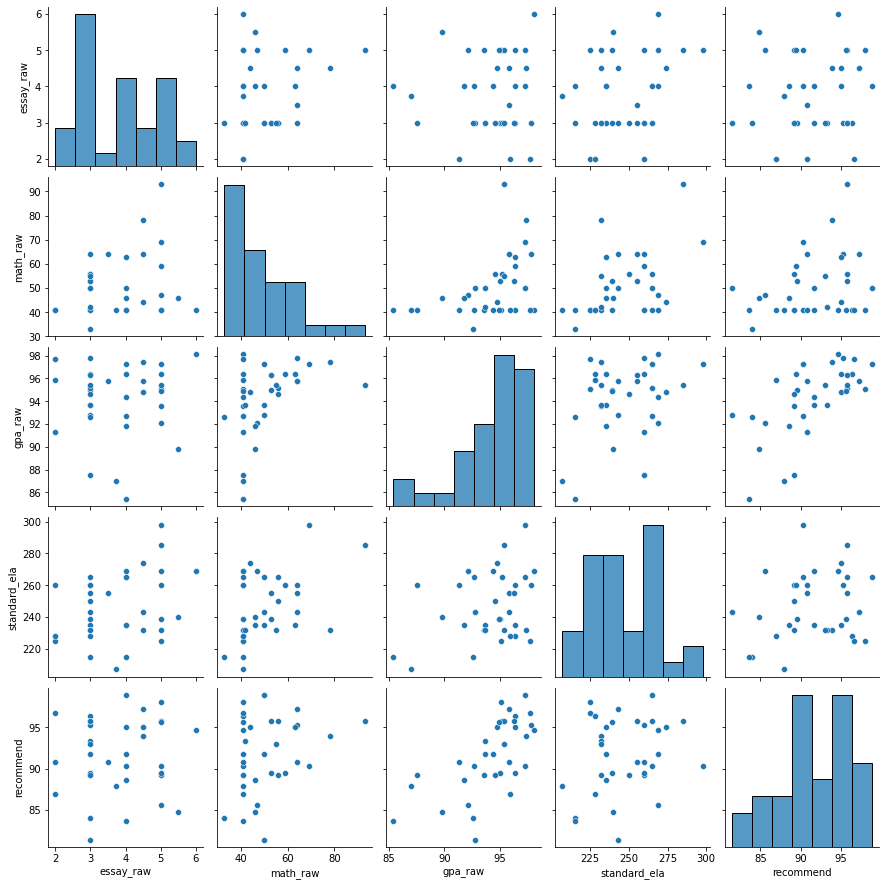

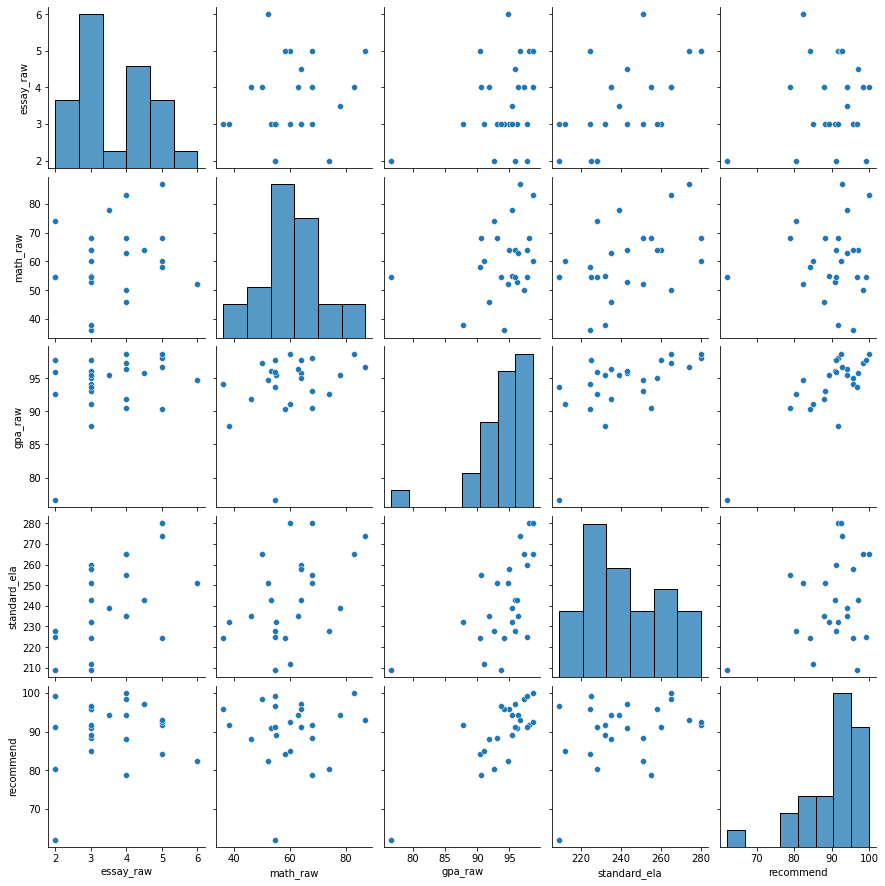

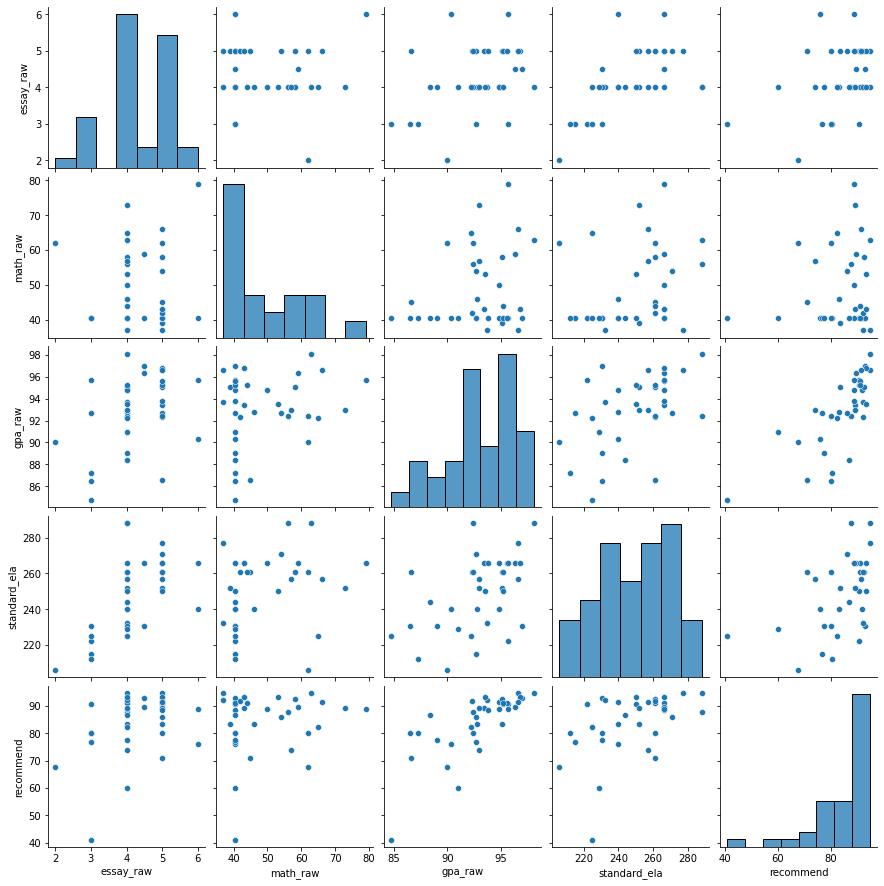

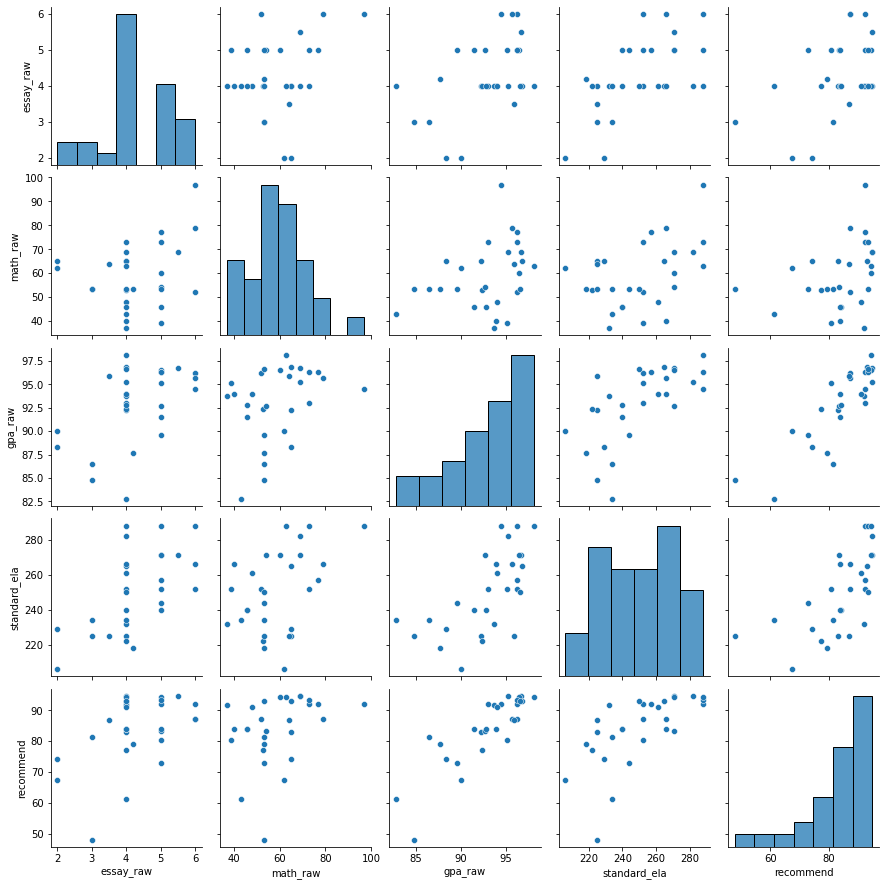

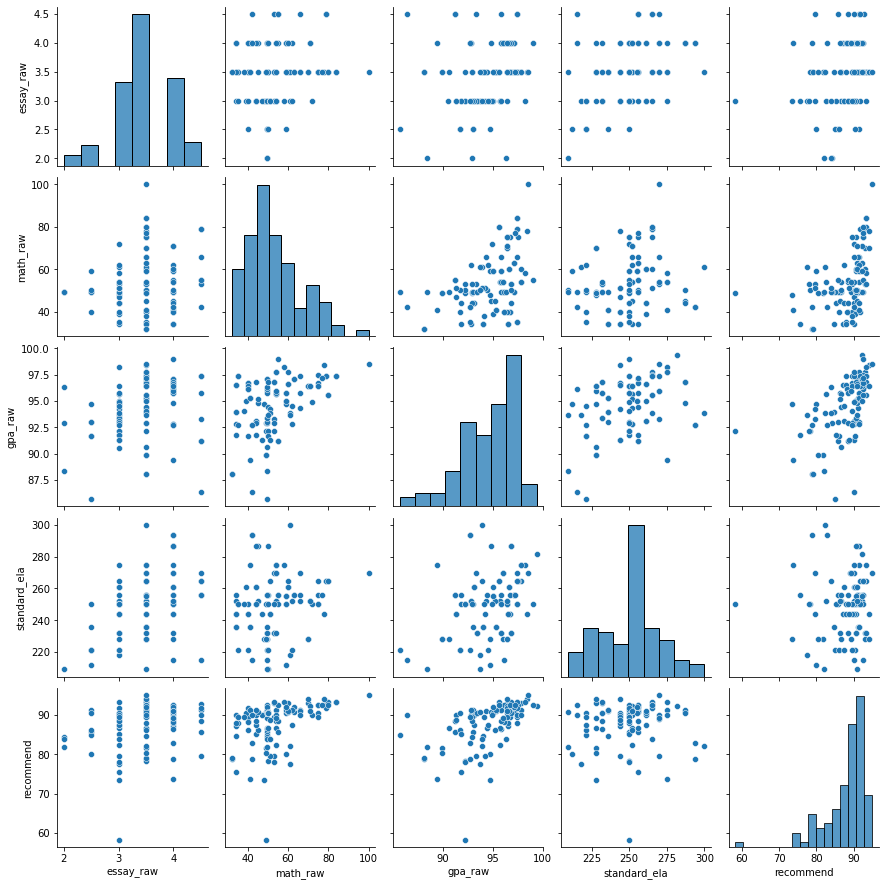

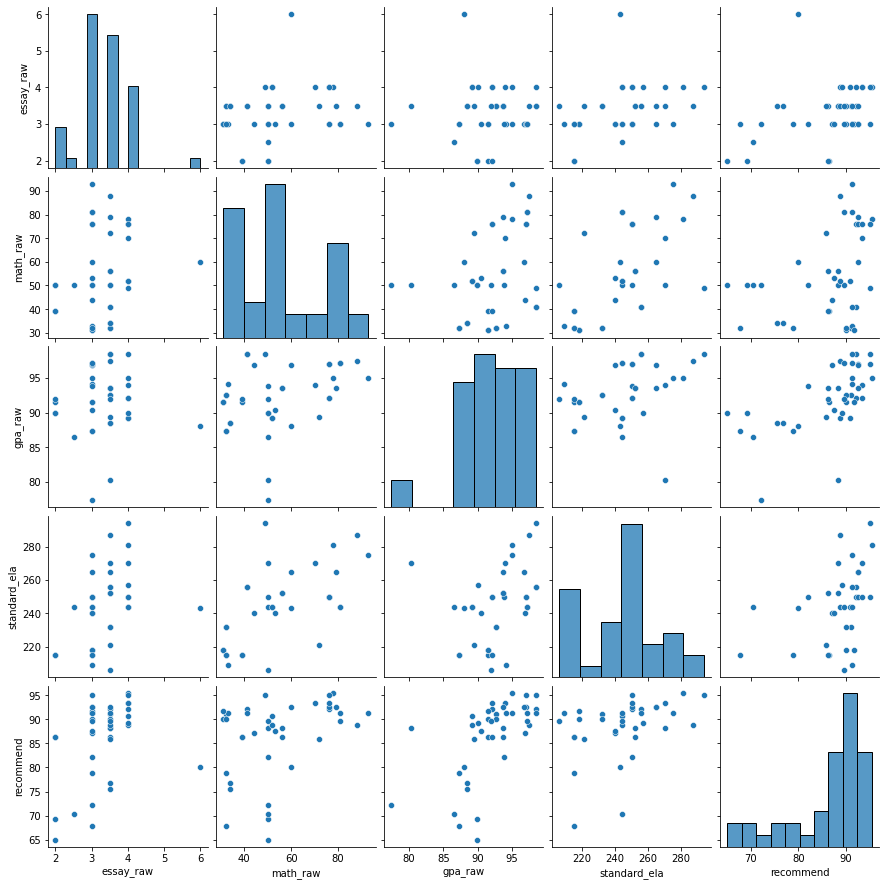

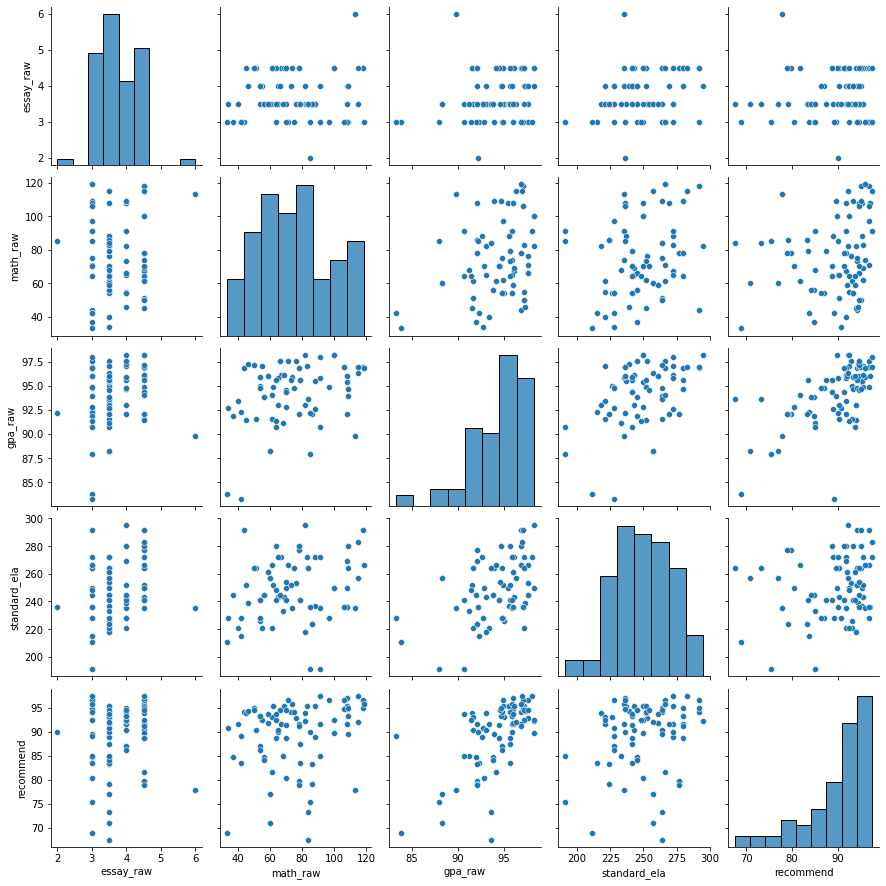

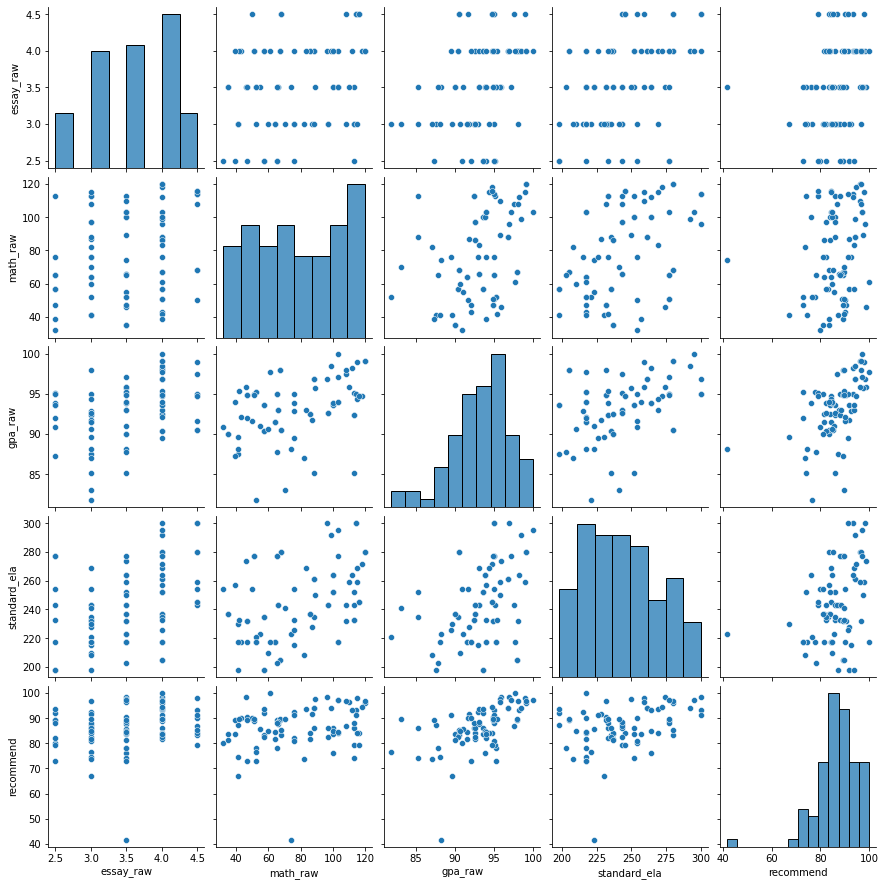

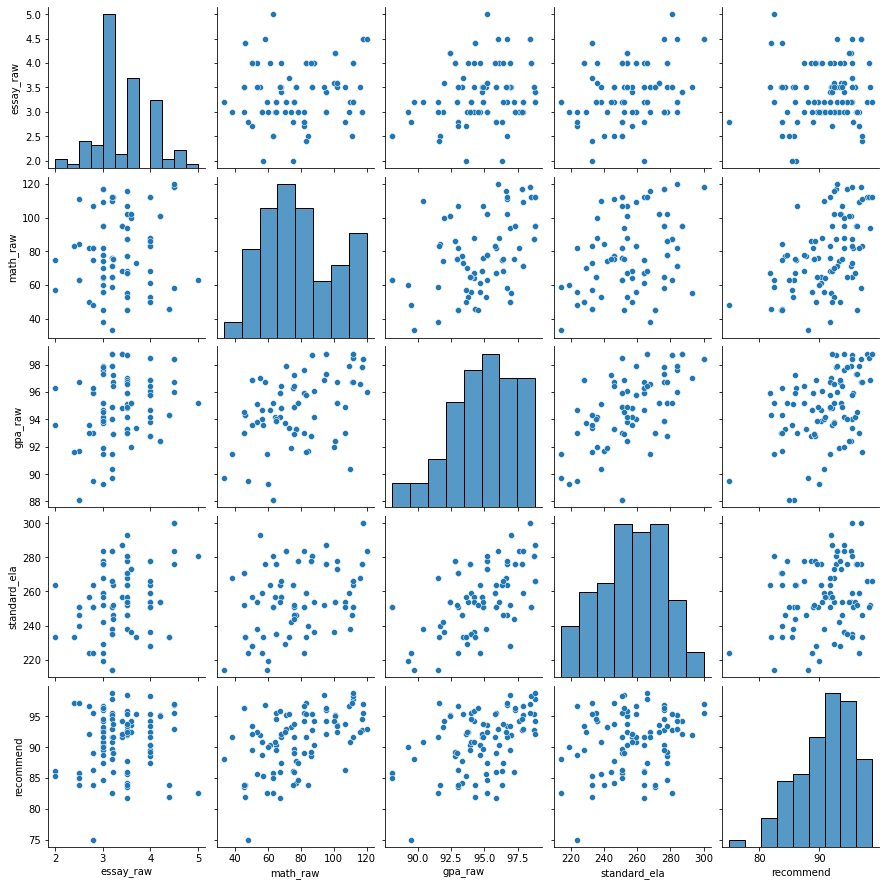

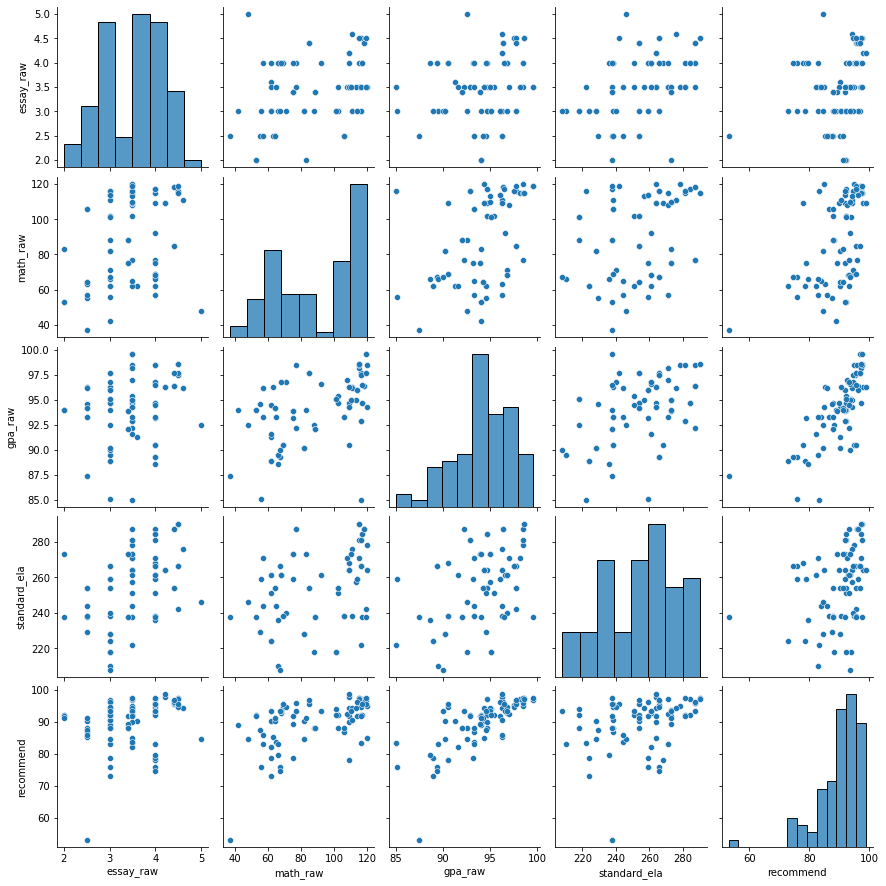

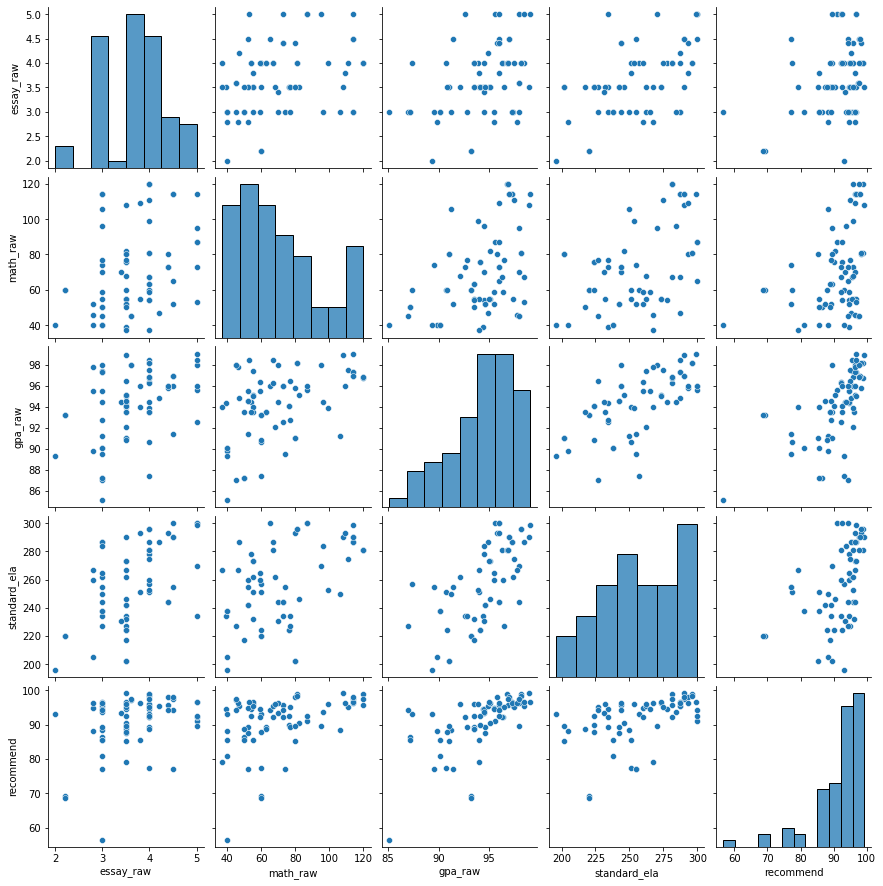

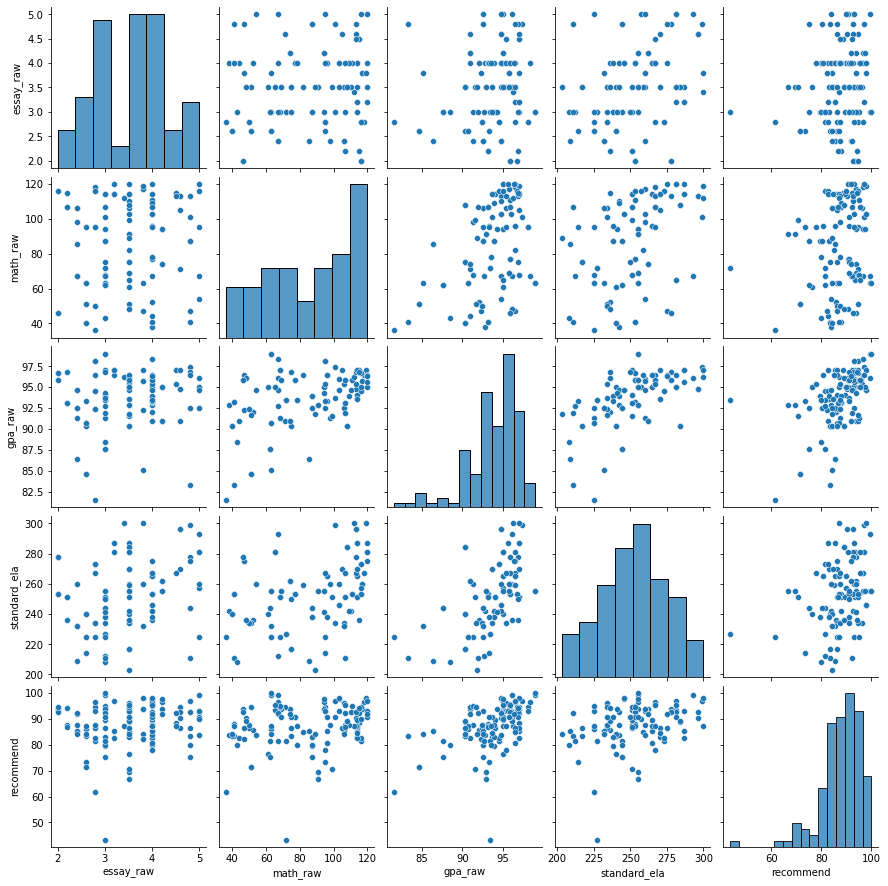

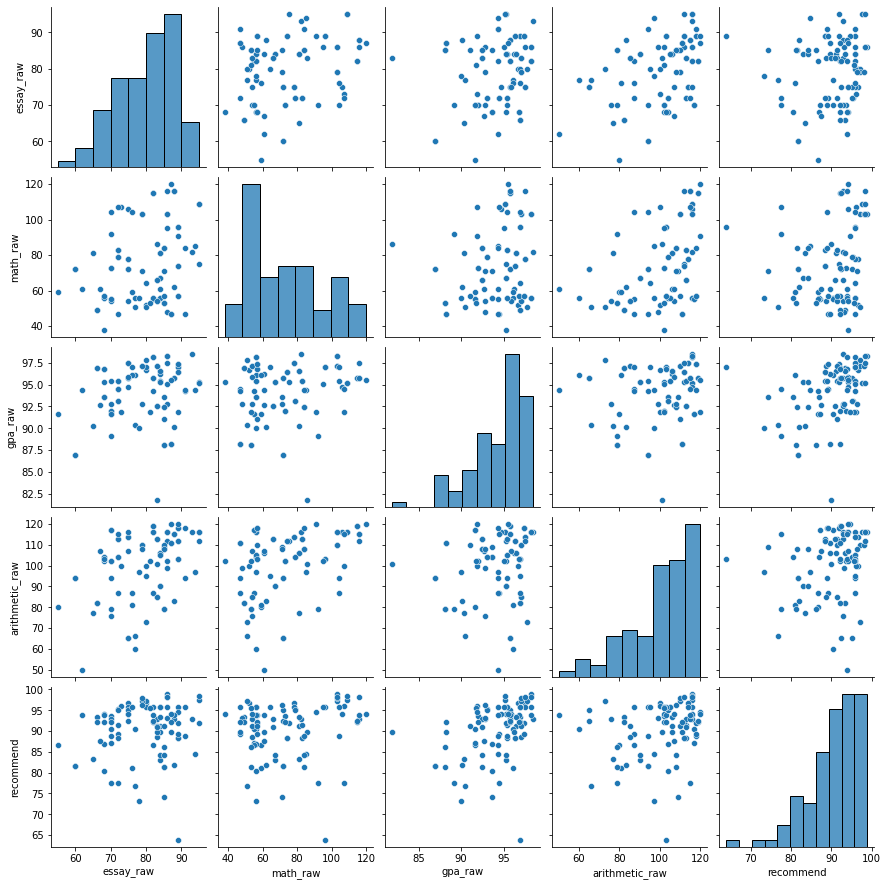

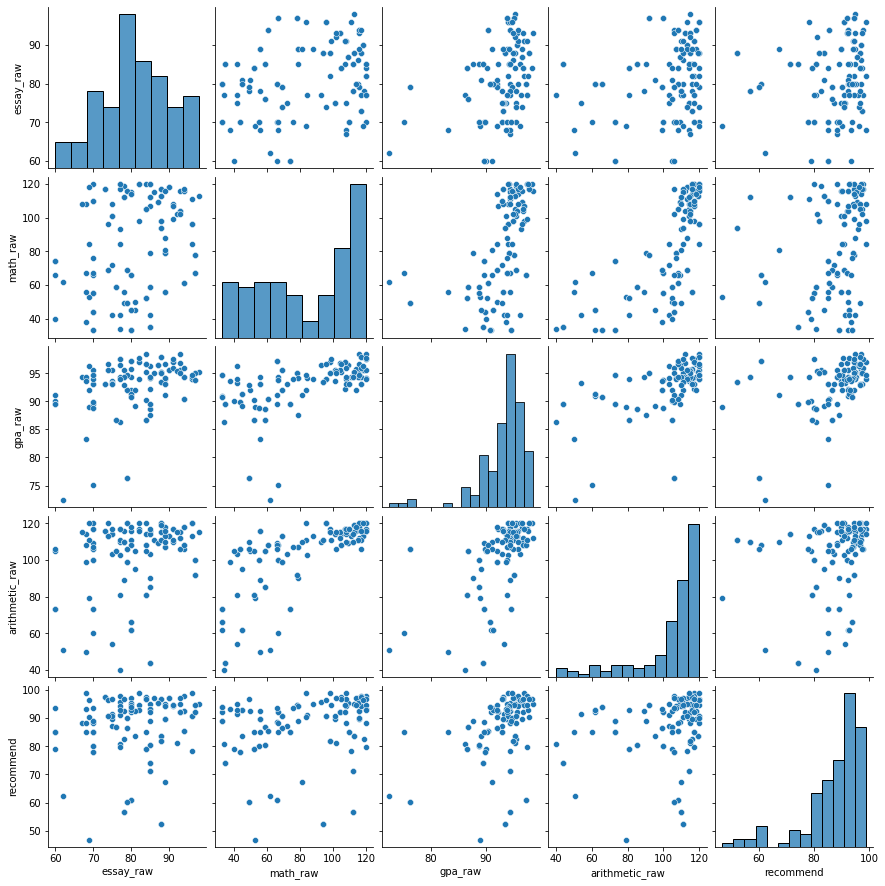

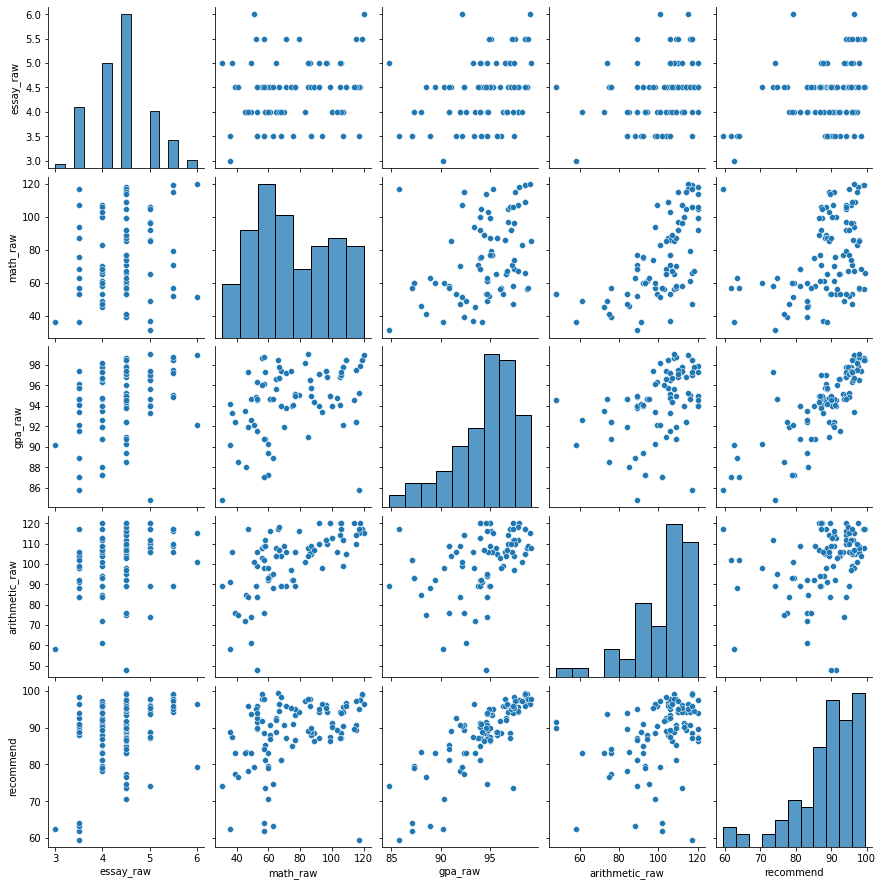

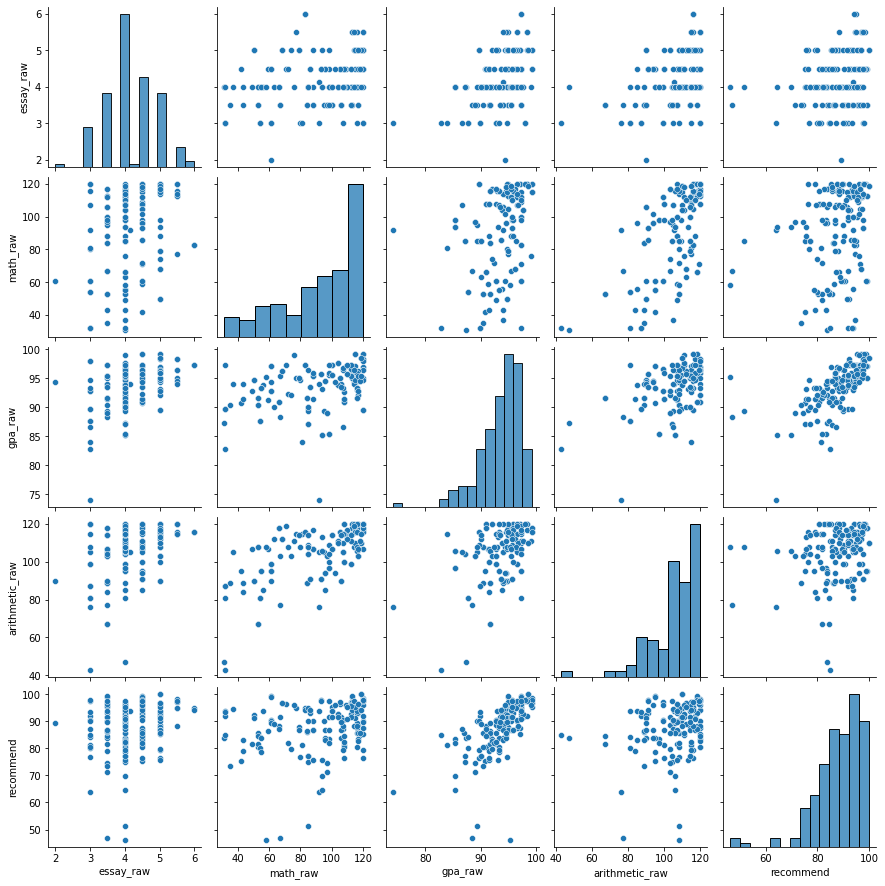

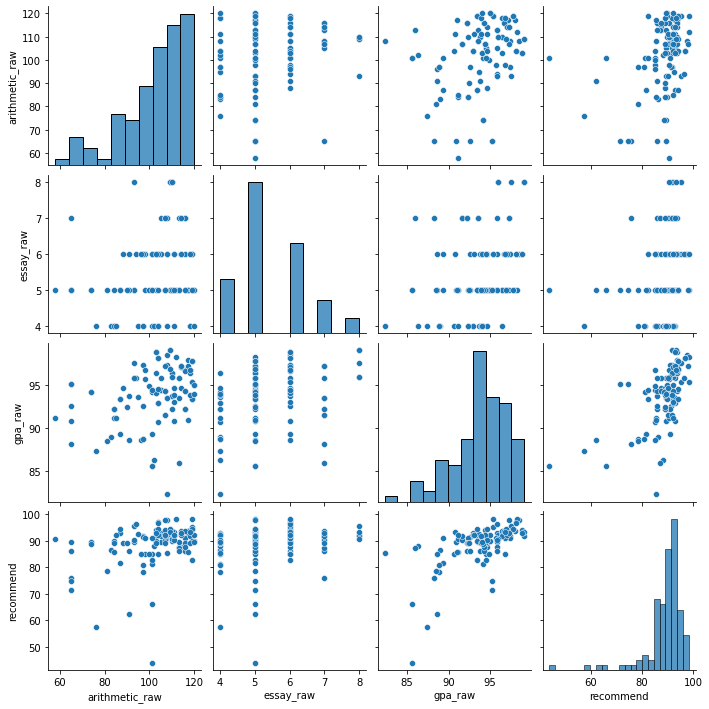

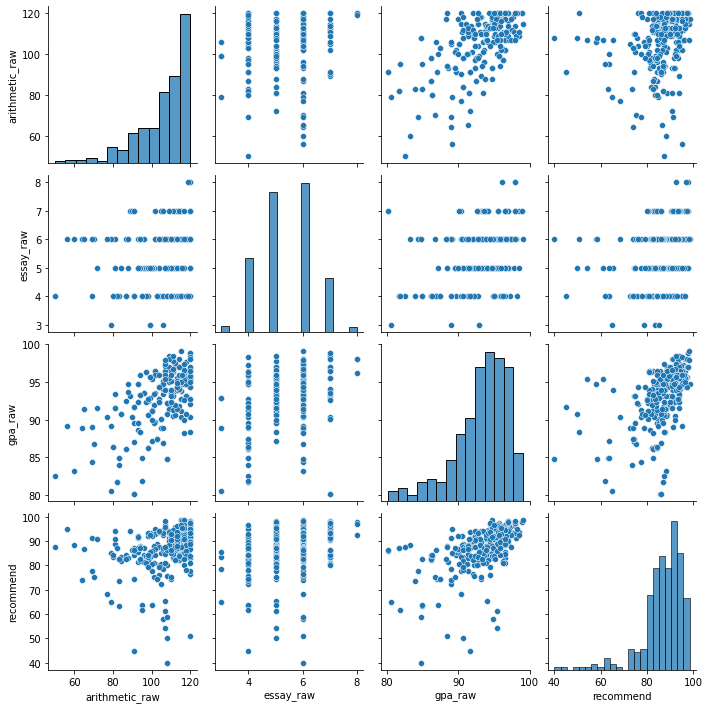

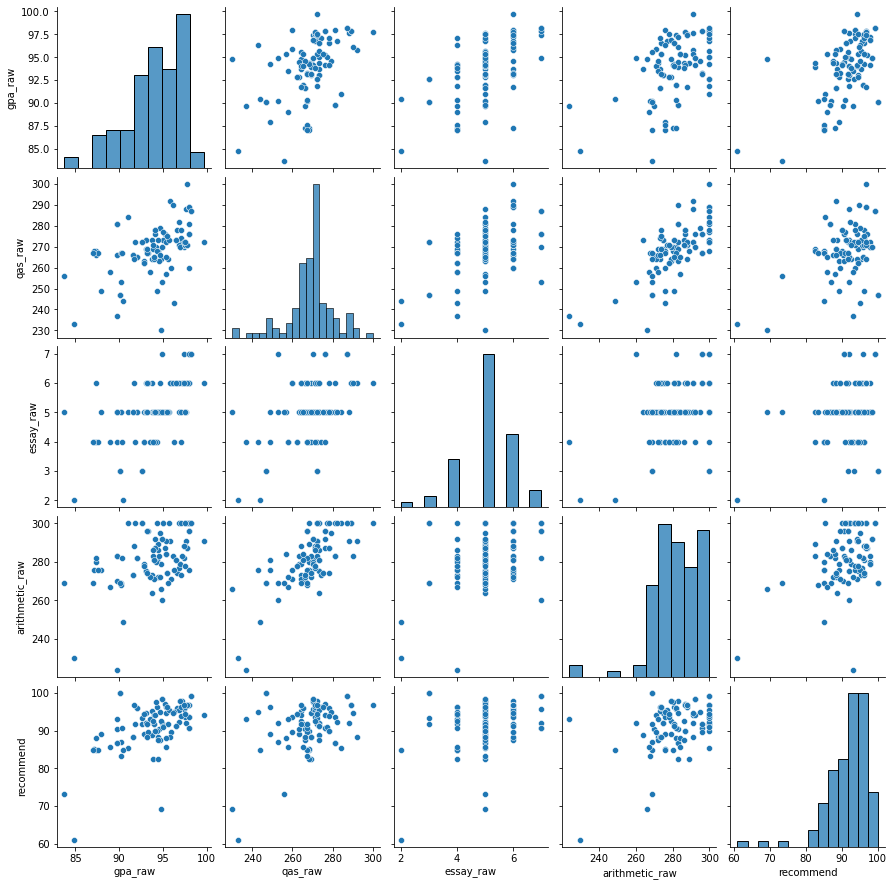

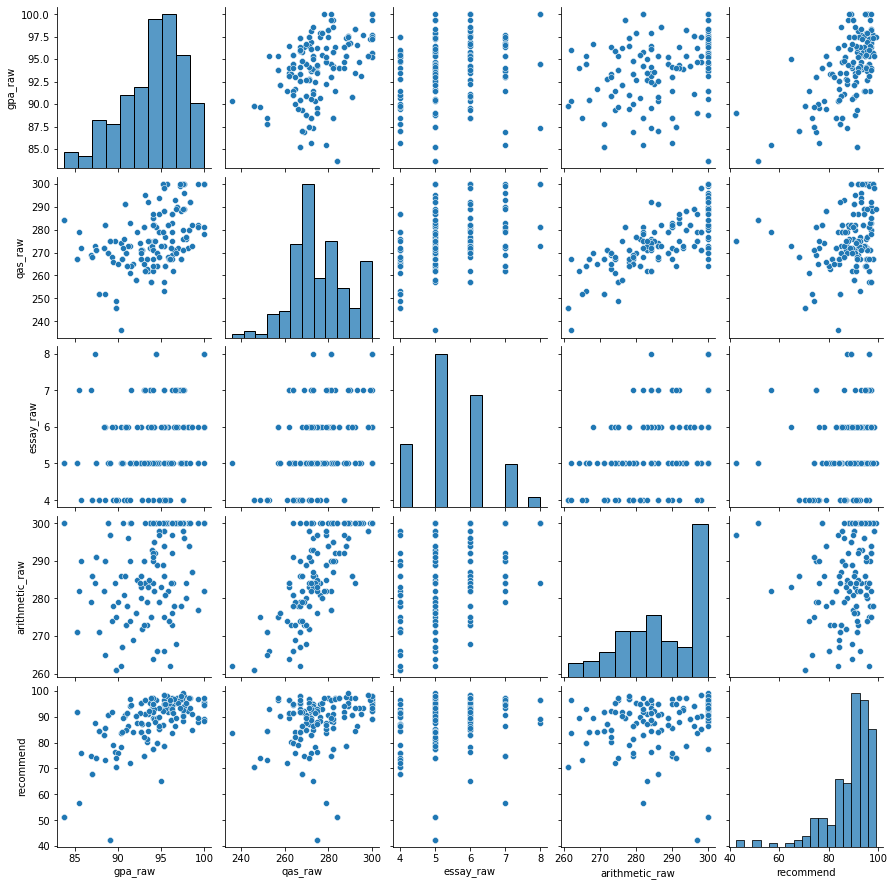

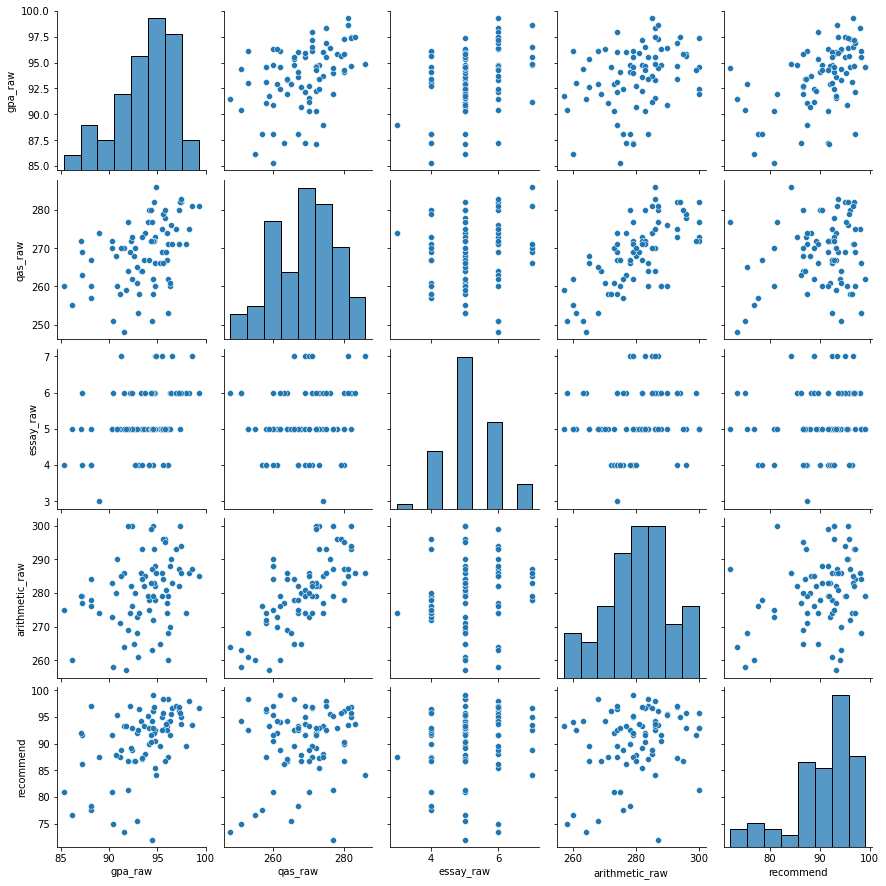

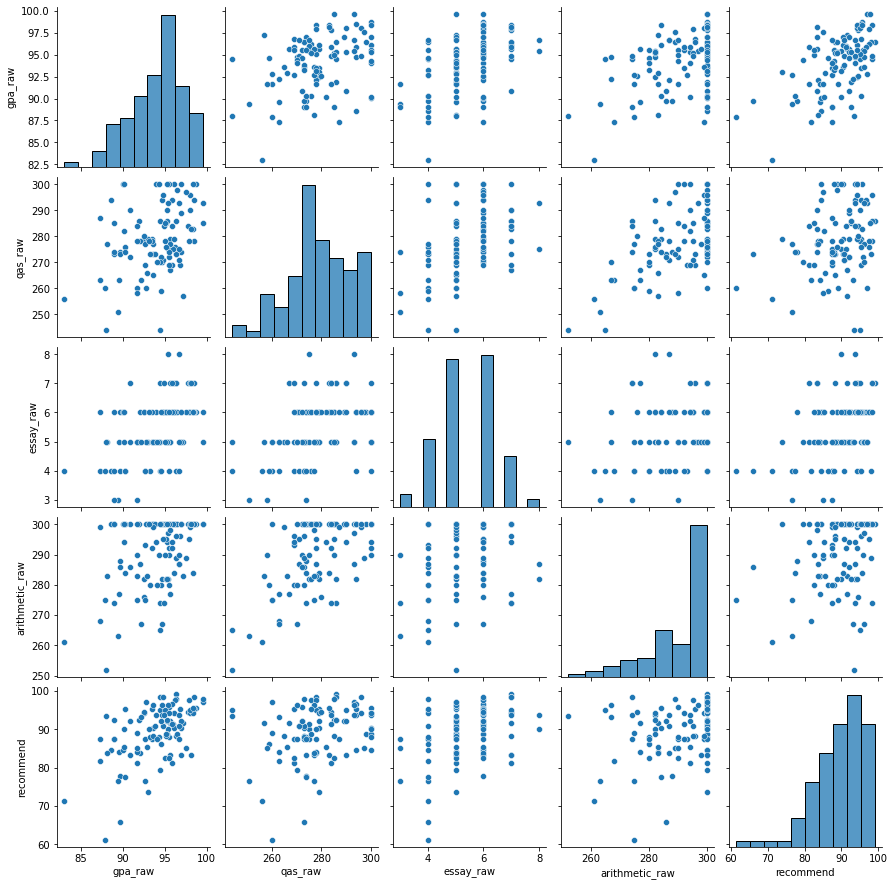

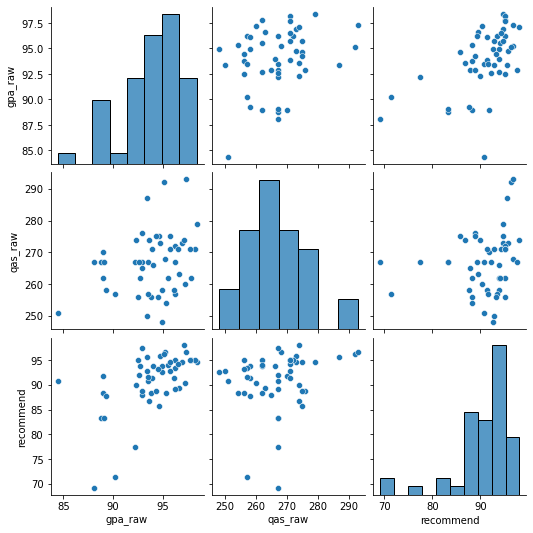

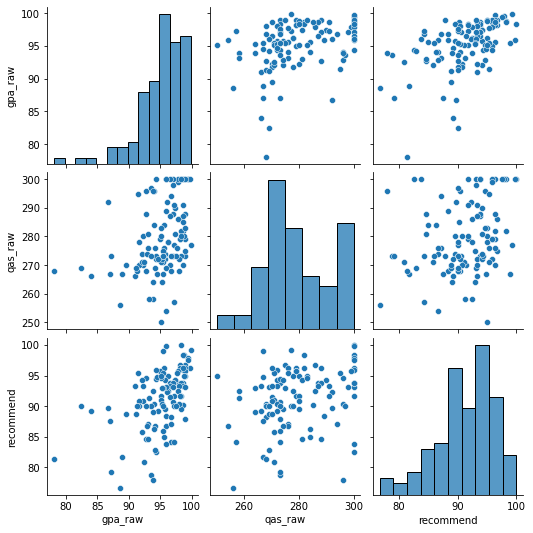

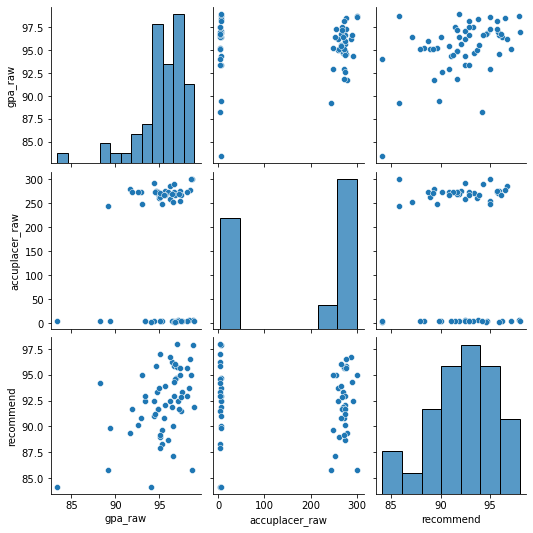

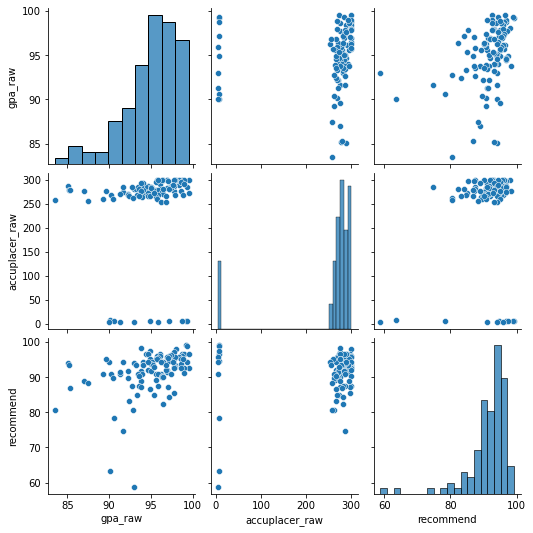

In [34]:
'''Plot pairplots'''
plot_list_master = ['essay_raw', 'math_raw', 'arithmetic_raw', 'qas_raw', 'accuplacer_raw','gpa_raw','standard_ela', 'recommend']

plot_list = []
for key, item in var_dict.items():
    for column in item.columns:
        if item[column].dtype == 'float64' and column in plot_list_master:
            plot_list.append(column)
    print(plot_list)
    sns.pairplot(item[plot_list])
    plot_list = []

In [35]:
'''Combine all untransformed data into single dataframe'''
keys_list = list(var_dict)

for key, item in var_dict.items():
    df1 = item
    next_index = (keys_list.index(key)+1)
    if next_index < len(keys_list):
        next_index_item = keys_list[next_index]
        df2 = var_dict[next_index_item]
        if keys_list.index(key) == 0:
            df_concat_raw = pd.concat([df1,df2], axis=0, ignore_index=True)
        else: df_concat_raw = pd.concat([df_concat_raw, df2], axis=0, ignore_index=True)
df_concat_raw

program  gpa_raw  gpa_converted  gpa_weighted  recommend  \
0         IB    95.83           90.0          27.0       91.1   
1         IB    92.93           80.0          24.0       90.0   
2         IB    88.57           60.0          18.0       83.3   
3         IB    85.79           60.0          18.0       80.3   
4         IB    97.64          100.0          30.0       93.3   
...      ...      ...            ...           ...        ...   
2657  Magnet    97.60          100.0          45.0       94.4   
2658  Magnet    95.40           80.0          36.0       92.8   
2659  Magnet    93.60           80.0          36.0       90.2   
2660  Magnet    87.50           60.0          27.0       88.3   
2661  Magnet    83.50           60.0          27.0       80.6   

      recommend_converted  recommend_weighted  essay_raw  essay_converted  \
0                    91.1              36.440        4.0             70.0   
1                    90.0              36.000        6.0            100.0   
2                    83.3              33.320        5.0             80.0   
3                    80.3              32.120        4.0             70.0   
4                    93.3              37.320        5.0             80.0   
...                   ...                 ...        ...              ...   
2657                  NaN              18.870        NaN              NaN   
2658                  NaN              18.550        NaN              NaN   
2659                  NaN              18.040        NaN              NaN   
2660                  NaN              17.660        NaN              NaN   
2661                  NaN              16.125        NaN              NaN   

      essay_weighted  ...  arithmetic_weighted  elementary_algebra  \
0                7.0  ...                  NaN                 NaN   
1               10.0  ...                  NaN                 NaN   
2                8.0  ...                  NaN                 NaN   
3                7.0  ...                  NaN                 NaN   
4                8.0  ...                  NaN                 NaN   
...              ...  ...                  ...                 ...   
2657             NaN  ...                  NaN                 NaN   
2658             NaN  ...                  NaN                 NaN   
2659             NaN  ...                  NaN                 NaN   
2660             NaN  ...                  NaN                 NaN   
2661             NaN  ...                  NaN                 NaN   

      ea_corrected  ea_weighted  qas_raw qas_converted qas_weighted  \
0              NaN          NaN      NaN           NaN          NaN   
1              NaN          NaN      NaN           NaN          NaN   
2              NaN          NaN      NaN           NaN          NaN   
3              NaN          NaN      NaN           NaN          NaN   
4              NaN          NaN      NaN           NaN          NaN   
...            ...          ...      ...           ...          ...   
2657           NaN          NaN      NaN           NaN          NaN   
2658           NaN          NaN      NaN           NaN          NaN   
2659           NaN          NaN      NaN           NaN          NaN   
2660           NaN          NaN      NaN           NaN          NaN   
2661           NaN          NaN      NaN           NaN          NaN   

     accuplacer_raw accuplacer_converted  accuplacer_weighted  
0               NaN                  NaN                  NaN  
1               NaN                  NaN                  NaN  
2               NaN                  NaN                  NaN  
3               NaN                  NaN                  NaN  
4               NaN                  NaN                  NaN  
...             ...                  ...                  ...  
2657          289.0                100.0                 35.0  
2658          273.0                100.0                 35.0  
2659          267.0          

In [36]:
'''Split accuplacer column between essay and math'''
accuplacer_list = ['df_2021_2022_out_district', 'df_2021_2022_in_district']

for item in accuplacer_list:
    var_dict[item]['essay_raw'] = var_dict[item].loc[(var_dict[item]['accuplacer_raw'] < 11) & (var_dict[item]['program'] == 'IB'), ['accuplacer_raw']]
    var_dict[item]['essay_converted'] = var_dict[item].loc[var_dict[item]['program'] == 'IB', ['accuplacer_converted']]
    var_dict[item]['essay_weighted'] = var_dict[item].loc[var_dict[item]['program'] == 'IB', ['accuplacer_weighted']]

    var_dict[item]['qas_raw'] = var_dict[item].loc[(var_dict[item]['accuplacer_raw'] > 100) & (var_dict[item]['program'] == 'Magnet'), ['accuplacer_raw']]
    var_dict[item]['qas_converted'] = var_dict[item].loc[var_dict[item]['program'] == 'Magnet', ['accuplacer_converted']]
    var_dict[item]['qas_weighted'] = var_dict[item].loc[var_dict[item]['program'] == 'Magnet', ['accuplacer_weighted']]
    
    var_dict[item].drop('accuplacer_raw', axis = 1, inplace = True)
    var_dict[item].drop('accuplacer_converted', axis = 1, inplace = True)
    var_dict[item].drop('accuplacer_weighted', axis = 1, inplace = True)
    var_dict[item].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107 entries, 0 to 106
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   program               107 non-null    category
 1   gpa_raw               107 non-null    float64 
 2   gpa_converted         107 non-null    float64 
 3   gpa_weighted          107 non-null    float64 
 4   recommend             107 non-null    float64 
 5   recommend_weighted    107 non-null    float64 
 6   admit_score           107 non-null    float64 
 7   admit_decision        107 non-null    category
 8   admit_offer_accepted  107 non-null    category
 9   full_name             107 non-null    category
 10  student_category      107 non-null    category
 11  essay_raw             11 non-null     float64 
 12  essay_converted       11 non-null     float64 
 13  essay_weighted        11 non-null     float64 
 14  qas_raw               96 non-null     float64 
 15  qas_co

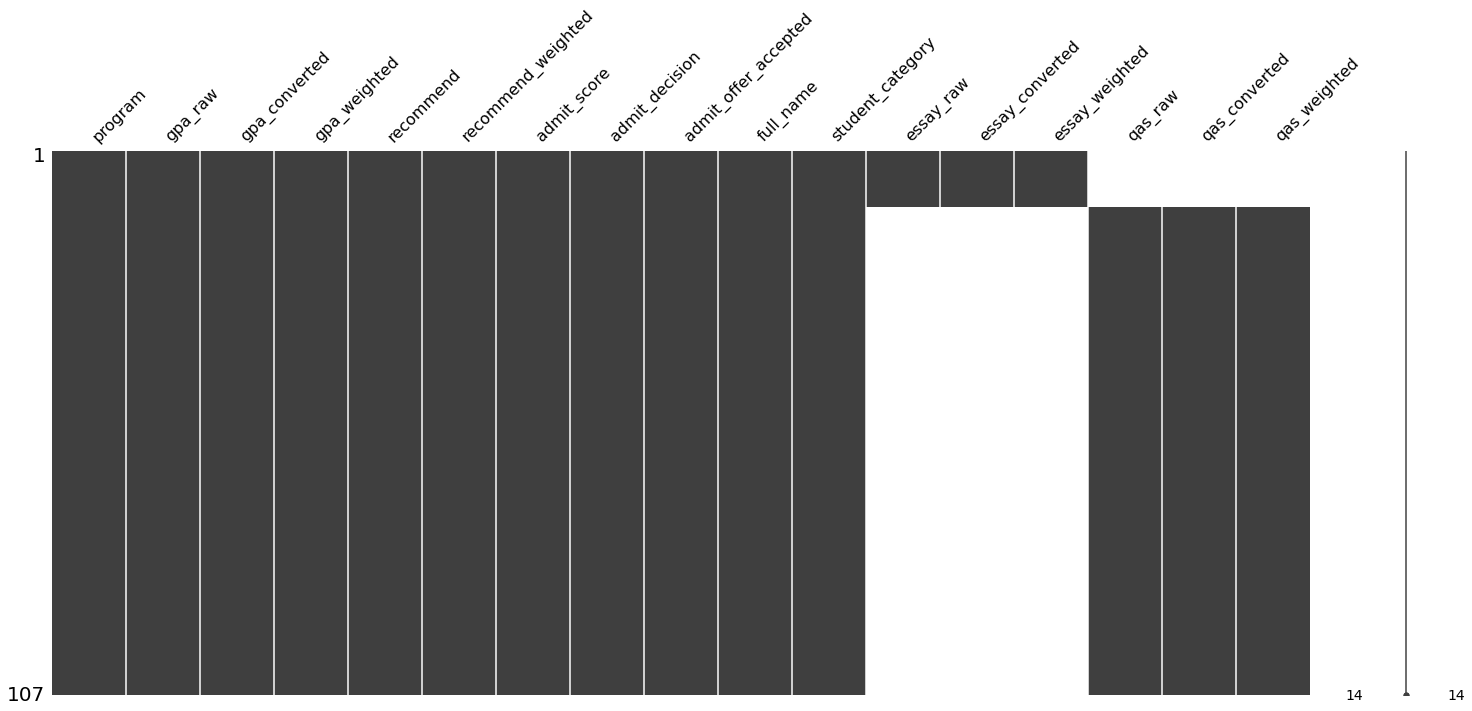

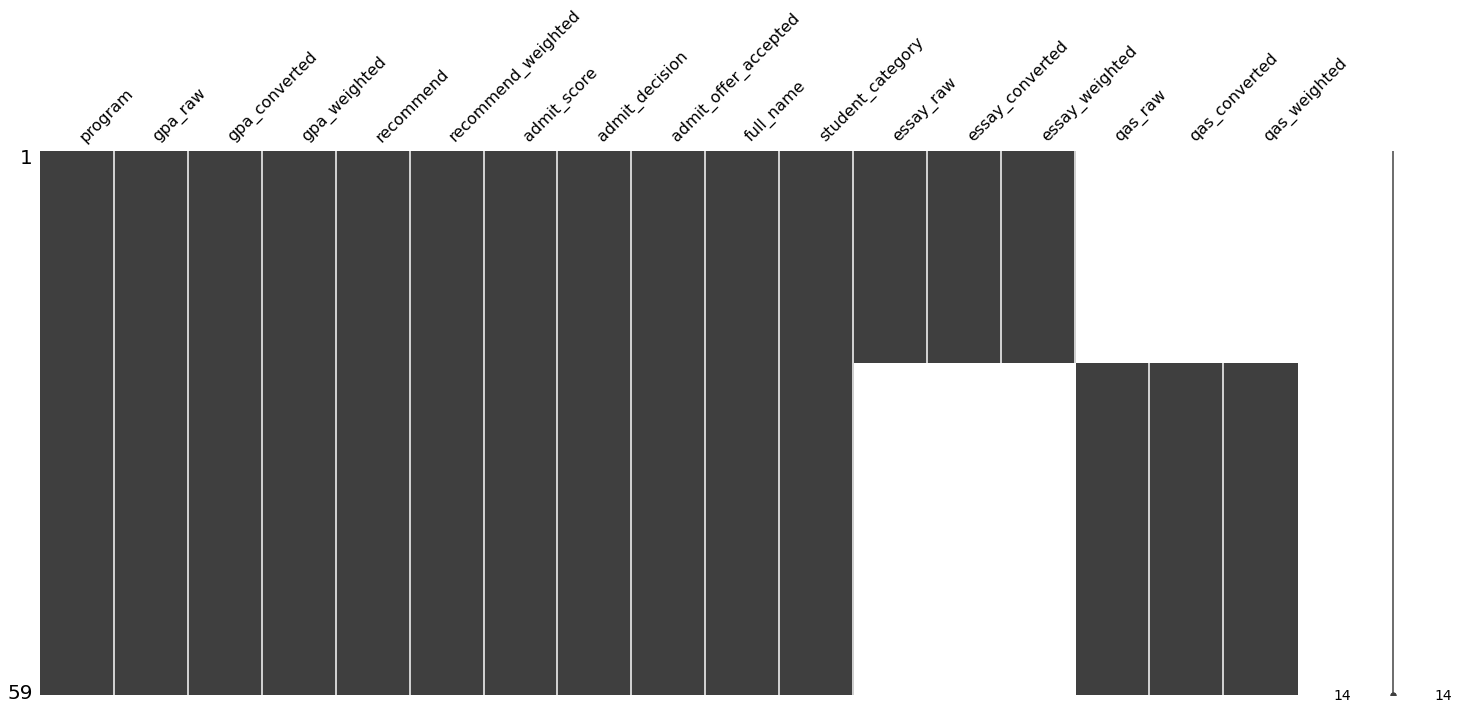

In [37]:
for item in accuplacer_list:
    msno.matrix(var_dict[item])
    print(var_dict[item].info())

In [38]:
'''Combine all untransformed data into single dataframe'''
keys_list = list(var_dict)

for key, item in var_dict.items():
        df1 = item
        next_index = (keys_list.index(key)+1)
        if next_index < len(keys_list):
            next_index_item = keys_list[next_index]
            df2 = var_dict[next_index_item]
            if keys_list.index(key) == 0:
                df_concat_raw = pd.concat([df1,df2], axis=0, ignore_index=True)
            else: df_concat_raw = pd.concat([df_concat_raw, df2], axis=0, ignore_index=True)
df_concat_raw

program  gpa_raw  gpa_converted  gpa_weighted  recommend  \
0         IB    95.83           90.0          27.0       91.1   
1         IB    92.93           80.0          24.0       90.0   
2         IB    88.57           60.0          18.0       83.3   
3         IB    85.79           60.0          18.0       80.3   
4         IB    97.64          100.0          30.0       93.3   
...      ...      ...            ...           ...        ...   
2657  Magnet    97.60          100.0          45.0       94.4   
2658  Magnet    95.40           80.0          36.0       92.8   
2659  Magnet    93.60           80.0          36.0       90.2   
2660  Magnet    87.50           60.0          27.0       88.3   
2661  Magnet    83.50           60.0          27.0       80.6   

      recommend_converted  recommend_weighted  essay_raw  essay_converted  \
0                    91.1              36.440        4.0             70.0   
1                    90.0              36.000        6.0            100.0   
2                    83.3              33.320        5.0             80.0   
3                    80.3              32.120        4.0             70.0   
4                    93.3              37.320        5.0             80.0   
...                   ...                 ...        ...              ...   
2657                  NaN              18.870        NaN              NaN   
2658                  NaN              18.550        NaN              NaN   
2659                  NaN              18.040        NaN              NaN   
2660                  NaN              17.660        NaN              NaN   
2661                  NaN              16.125        NaN              NaN   

      essay_weighted  ...  reading_score_weighted  arithmetic_raw  \
0                7.0  ...                     NaN             NaN   
1               10.0  ...                     NaN             NaN   
2                8.0  ...                     NaN             NaN   
3                7.0  ...                     NaN             NaN   
4                8.0  ...                     NaN             NaN   
...              ...  ...                     ...             ...   
2657             NaN  ...                     NaN             NaN   
2658             NaN  ...                     NaN             NaN   
2659             NaN  ...                     NaN             NaN   
2660             NaN  ...                     NaN             NaN   
2661             NaN  ...                     NaN             NaN   

      arithmetic_converted  arithmetic_weighted  elementary_algebra  \
0                      NaN                  NaN                 NaN   
1                      NaN                  NaN                 NaN   
2                      NaN                  NaN                 NaN   
3                      NaN                  NaN                 NaN   
4                      NaN                  NaN                 NaN   
...                    ...                  ...                 ...   
2657                   NaN                  NaN                 NaN   
2658                   NaN                  NaN                 NaN   
2659                   NaN                  NaN                 NaN   
2660                   NaN                  NaN                 NaN   
2661                   NaN                  NaN                 NaN   

     ea_corrected ea_weighted qas_raw qas_converted  qas_weighted  
0             NaN         NaN     NaN           NaN           NaN  
1             NaN         NaN     NaN           NaN           NaN  
2             NaN         NaN     NaN           NaN           NaN  
3             NaN         NaN     NaN           NaN           NaN  
4             NaN         NaN     NaN           NaN           NaN  
...           ...         ...     ...           ...           ...  
2657          NaN         NaN   289.0         100.0          35.0  
2658          NaN         NaN   273.0         100.0          35.0  
2659 

In [39]:
'''Save to csv'''
df_concat_raw.to_csv('applicant_raw.csv')

In [ ]:
plot_list = ['essay_raw', 'math_raw', 'arithmetic_raw', 'qas_raw','gpa_raw','standard_ela', 'recommend']

fig, ax = plt.subplots(figsize= (15, 10))
sns.boxplot(data = df_concat_raw[plot_list])

In [40]:
'''Impute Outliers'''
for key, item in var_dict.items():
    if column =='essay_raw':
        item['essay_raw'] = np.where(item['essay_raw'].max() <=10 and item['essay_raw'] < 2, item['essay_raw'].mean(), item['essay_raw'])
        item['essay_raw'] = np.where(item['essay_raw'].max() > 10 and item['essay_raw'].max() < 100 and \
                                     item['essay_raw'] < 55, item['essay_raw'].mean(), item['essay_raw'])
        item['essay_raw'] = np.where(item['essay_raw'].max() > 250 and item['essay_raw'] < 50, item['essay_raw'].mean(), item['essay_raw'])

<AxesSubplot:>

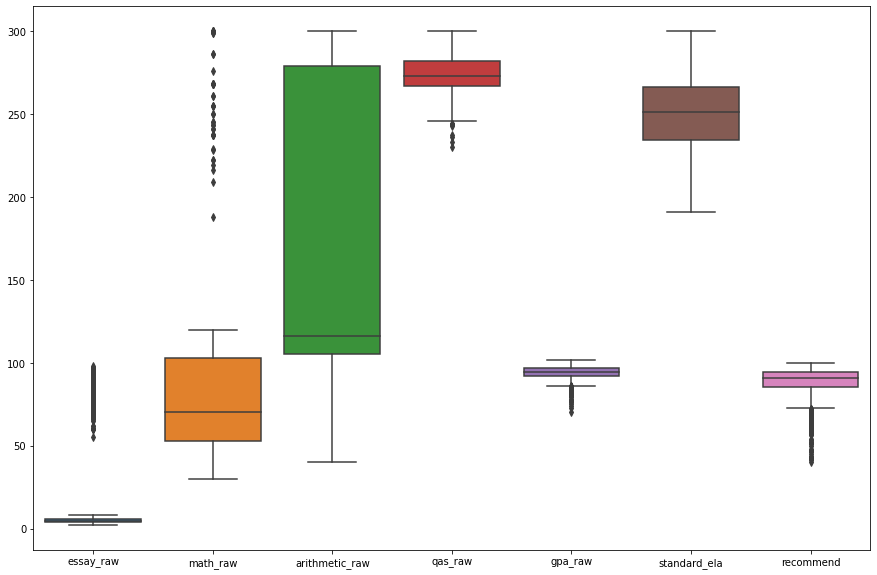

In [41]:
plot_list = ['essay_raw', 'math_raw', 'arithmetic_raw', 'qas_raw', 'gpa_raw','standard_ela', 'recommend']

fig, ax = plt.subplots(figsize= (15, 10))
sns.boxplot(data = df_concat_raw[plot_list])

In [42]:
'''Create columns to be passed through the pipeline'''
pass_columns = ['full_name', 'student_category']

for key, item in var_dict.items():
    for column in item.columns:
        if column in pass_columns:
            item[column] = item[column].astype('string')
    print(key, item.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 0 to 42
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   program                   43 non-null     category
 1   gpa_raw                   43 non-null     float64 
 2   gpa_converted             43 non-null     float64 
 3   gpa_weighted              43 non-null     float64 
 4   recommend                 40 non-null     float64 
 5   recommend_converted       40 non-null     float64 
 6   recommend_weighted        41 non-null     float64 
 7   essay_raw                 41 non-null     float64 
 8   essay_converted           42 non-null     float64 
 9   essay_weighted            42 non-null     float64 
 10  standard_ela              42 non-null     float64 
 11  math_raw                  42 non-null     float64 
 12  standard_total_converted  43 non-null     float64 
 13  standard_total_weighted   43 non-null     float64 
 

df_2020_2021_in_district None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 0 to 112
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   program               113 non-null    category
 1   gpa_raw               113 non-null    float64 
 2   gpa_converted         113 non-null    float64 
 3   gpa_weighted          113 non-null    float64 
 4   qas_raw               113 non-null    float64 
 5   qas_converted         113 non-null    float64 
 6   qas_weighted          113 non-null    float64 
 7   recommend             113 non-null    float64 
 8   recommend_weighted    113 non-null    float64 
 9   admit_score           113 non-null    float64 
 10  admit_decision        113 non-null    category
 11  admit_offer_accepted  113 non-null    category
 12  full_name             113 non-null    string  
 13  student_category      113 non-null    string  
dtypes: category(3), float64(9), 

In [43]:
for key, item in var_dict.items():
    print(item)

   program  gpa_raw  gpa_converted  gpa_weighted  recommend  \
0       IB    95.83           90.0          27.0       91.1   
1       IB    92.93           80.0          24.0       90.0   
2       IB    88.57           60.0          18.0       83.3   
3       IB    85.79           60.0          18.0       80.3   
4       IB    97.64          100.0          30.0       93.3   
5       IB    94.29           80.0          24.0       89.4   
6       IB    93.57           80.0          24.0       87.4   
7       IB    93.83           80.0          24.0       92.0   
8       IB    94.57           80.0          24.0       91.1   
9       IB    90.48           70.0          21.0       88.8   
10      IB    91.17           70.0          21.0       87.5   
11      IB    86.43           60.0          18.0       87.2   
12      IB    91.71           80.0          24.0       74.7   
13      IB    96.27           90.0          27.0       90.3   
14      IB    99.93          100.0          30.0       

[107 rows x 17 columns]


In [47]:
'''Transformer for numerical features'''
num_pipe = Pipeline(
    [
        #('imputer_num', KNNImputer()),
        ('scaler', PowerTransformer(method = 'yeo-johnson', standardize = True))
    ]
)

In [45]:
'''Transformer for categorical features'''
cat_pipe = Pipeline(
    [
        ('imputer_cat', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
        ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False)) 
    ]
)

In [48]:
'''Standardize data - BEWARE TWO DIFFERENT RUNS ARE REQUIRED
1) Run with dict_list AS IS
2) Run with dict_list_2 and comment out KNN Imputer in num_pipe.  We do not want to impute data in these dfs since we have to
split the ACC Scores between essay and qas which creates NANs that we DO NOT want imputed
'''

dict_list = ['df_2007_2008_ib_in_district', 'df_2008_2009_ib_magnet', 'df_2009_2010_ib', 'df_2009_2010_magnet', 'df_2010-2011_ib', 'df_2010-2011_magnet',\
             'df_2011_2012_in_district', 'df_2011_2012_out_district', 'df_2012_2013_in_district',\
             'df_2012_2013_out_district', 'df_2013_2014_in_district', 'df_2013_2014_out_district',\
             'df_2014_2015_in_district', 'df_2014_2015_out_district', 'df_2015_2016_in_district',\
             'df_2015_2016_out_district', 'df_2016_2017_in_district', 'df_2016_2017_out_district',\
             'df_2017_2018_in_district', 'df_2017_2018_out_district', 'df_2018_2019_in_district',\
             'df_2018_2019_out_district', 'df_2019_2020_in_district', 'df_2019_2020_out_district',\
             'df_2020_2021_in_district', 'df_2020_2021_out_district']
dict_list_2 = ['df_2021_2022_in_district', 'df_2021_2022_out_district']

for key,item in var_dict.items():
    if key in dict_list_2:
        df = (var_dict[key])
        num_cols = select_numeric(df)
        cat_cols = select_categorical(df)
        if 'student_category' not in cat_cols:
            X=df
        if 'student_category' in cat_cols:
            cat_cols.remove('student_category')
            X = df.drop('student_category', axis = 1)

        num_cols = select_numeric(item)
        cat_cols = select_categorical(item)
        #cat_cols.remove('student_category')

        '''Combine transformers into ColumnTransformer'''
        preprocessor = ColumnTransformer(
            [
                ('categorical', cat_pipe, cat_cols),
                ('numerical', num_pipe, num_cols)
            ],
            remainder = 'passthrough',
        )

        '''Fit Model'''
        preprocessor.fit(X)

        '''Prepare column names'''
        cat_columns = preprocessor.named_transformers_['categorical']['one_hot'].get_feature_names_out(cat_cols)
        columns = np.append(cat_columns, num_cols)
        columns = np.append(columns, pass_columns)

        preprocess_trans = preprocessor.transform(X)
        preprocess_trans_cols = preprocessor.named_transformers_['categorical']['one_hot'].get_feature_names_out(cat_cols)

        df_trans = pd.DataFrame(preprocessor.transform(X), columns = columns)
        var_dict[key] = df_trans
        cat_cols = []
        num_cols = []
        columns = []

In [49]:
'''Pickle datafile'''
with open('mib_trans_data.pkl', 'wb') as f:
    pickle.dump(var_dict, f)

In [50]:
'''Open pickled file'''
with open('mib_trans_data.pkl', 'rb') as f:
    var_dict = pickle.load(f)

### Combining all dataframes into a single dataframe

In [51]:
'''Combine all transformed data in single dataframe'''
keys_list = list(var_dict)

for key, item in var_dict.items():
        df1 = item
        next_index = (keys_list.index(key)+1)
        if next_index < len(keys_list):
            next_index_item = keys_list[next_index]
            df2 = var_dict[next_index_item]
            if keys_list.index(key) == 0:
                df_concat = pd.concat([df1,df2], axis=0, ignore_index=True)
            else: df_concat = pd.concat([df_concat, df2], axis=0, ignore_index=True)
df_concat

program_IB admit_decision_ax admit_decision_rj admit_offer_accepted_no  \
0             1                 1                 0                       0   
1             1                 1                 0                       0   
2             1                 1                 0                       0   
3             1                 1                 0                       0   
4             1                 1                 0                       0   
...         ...               ...               ...                     ...   
2657          0                 0                 1                       1   
2658          0                 0                 1                       1   
2659          0                 0                 1                       1   
2660          0                 0                 1                       1   
2661          0                 0                 1                       1   

     admit_offer_accepted_yes   gpa_raw gpa_converted gpa_weighted  recommend  \
0                           1  0.474797      0.668677     0.668445    0.51265   
1                           1 -0.232809    -0.0841166    -0.084588   0.233062   
2                           1  -1.14848      -1.53883     -1.53823   -1.04887   
3                           1  -1.64868      -1.53883     -1.53823   -1.43728   
4                           1  0.960164        1.4363      1.43685    1.14371   
...                       ...       ...           ...          ...        ...   
2657                        0  0.843671         1.386      1.44648   0.479422   
2658                        0 -0.061494     -0.587112    -0.498627  0.0188877   
2659                        0 -0.633688     -0.587112    -0.498627  -0.590497   
2660                        0  -1.80977      -1.96569     -1.86047  -0.944956   
2661                        0  -2.18623      -1.96569     -1.86047   -1.83384   

     recommend_converted  ... reading_score_weighted arithmetic_raw  \
0                0.51265  ...                    NaN            NaN   
1               0.233062  ...                    NaN            NaN   
2               -1.04887  ...                    NaN            NaN   
3               -1.43728  ...                    NaN            NaN   
4                1.14371  ...                    NaN            NaN   
...                  ...  ...                    ...            ...   
2657                 NaN  ...                    NaN            NaN   
2658                 NaN  ...                    NaN            NaN   
2659                 NaN  ...                    NaN            NaN   
2660                 NaN  ...                    NaN            NaN   
2661                 NaN  ...                    NaN            NaN   

     arithmetic_converted arithmetic_weighted elementary_algebra ea_corrected  \
0                     NaN                 NaN                NaN          NaN   
1                     NaN                 NaN                NaN          NaN   
2                     NaN                 NaN                NaN          NaN   
3                     NaN                 NaN                NaN          NaN   
4                     NaN                 NaN                NaN          NaN   
...                   ...                 ...                ...          ...   
2657                  NaN                 NaN                NaN          NaN   
2658                  NaN                 NaN                NaN          NaN   
2659                  NaN                 NaN                NaN          NaN   
2660                  NaN                 NaN                NaN          NaN   
2661                  NaN                 NaN                NaN          NaN   

     ea_weighted   qas_raw qas_converted qas_weighted  
0            NaN       NaN           NaN          NaN  
1            NaN       NaN           NaN          NaN  
2            NaN       NaN           NaN          NaN  
3            NaN       NaN       

<AxesSubplot:>

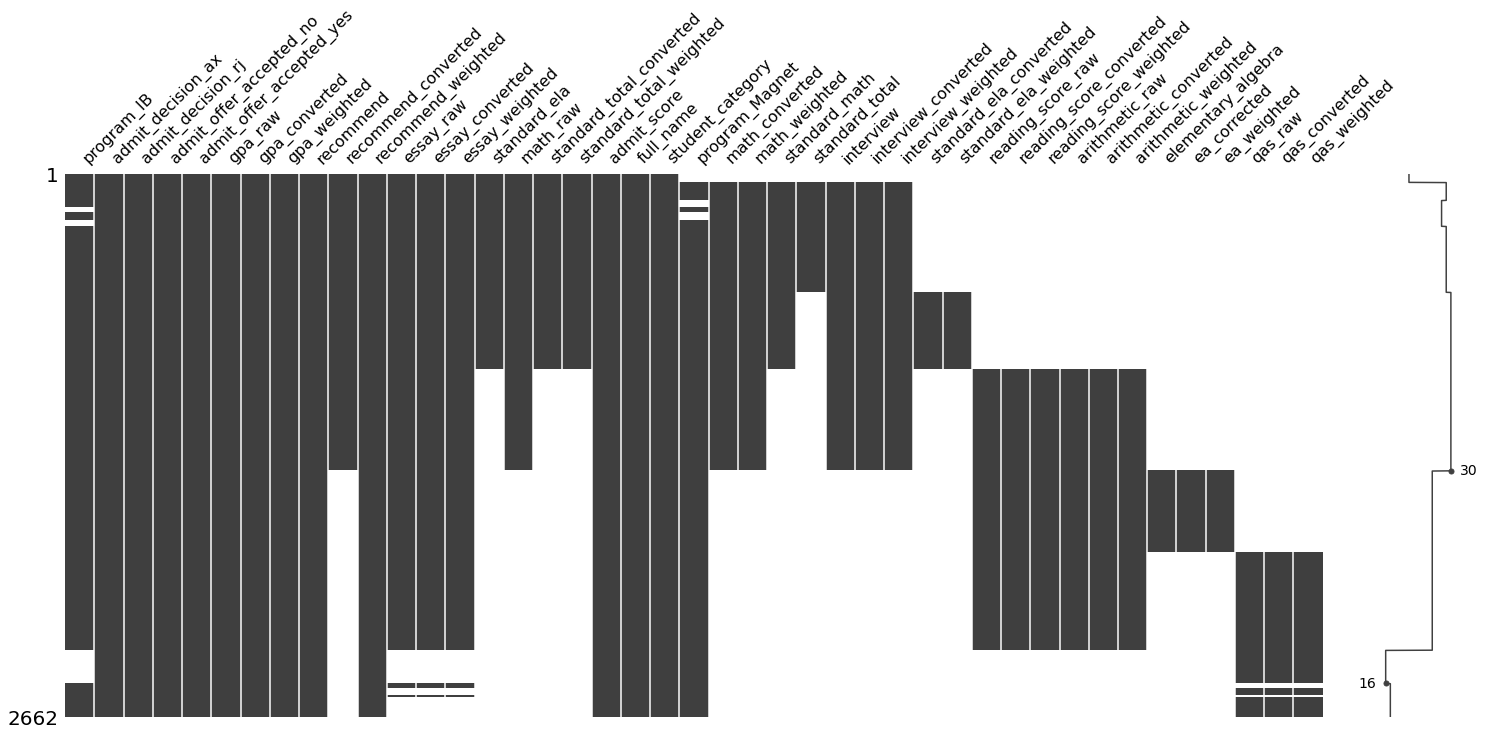

In [52]:
msno.matrix(df_concat)

In [53]:
df_concat.loc[df_concat['full_name'] == 'kazakevich, natalia']

Empty DataFrame
Columns: [program_IB, admit_decision_ax, admit_decision_rj, admit_offer_accepted_no, admit_offer_accepted_yes, gpa_raw, gpa_converted, gpa_weighted, recommend, recommend_converted, recommend_weighted, essay_raw, essay_converted, essay_weighted, standard_ela, math_raw, standard_total_converted, standard_total_weighted, admit_score, full_name, student_category, program_Magnet, math_converted, math_weighted, standard_math, standard_total, interview, interview_converted, interview_weighted, standard_ela_converted, standard_ela_weighted, reading_score_raw, reading_score_converted, reading_score_weighted, arithmetic_raw, arithmetic_converted, arithmetic_weighted, elementary_algebra, ea_corrected, ea_weighted, qas_raw, qas_converted, qas_weighted]
Index: []

[0 rows x 43 columns]

In [54]:
df_concat.loc[df_concat['full_name'] == 'kazakevich, natasha', 'full_name'] = "kazakevich, natalia"
df_concat.loc[df_concat['full_name'] == 'kazakevich, natalia']

program_IB admit_decision_ax admit_decision_rj admit_offer_accepted_no  \
17          1                 1                 0                       0   

   admit_offer_accepted_yes   gpa_raw gpa_converted gpa_weighted  recommend  \
17                        1  0.803538      0.668677     0.668445 -0.0246724   

   recommend_converted  ... reading_score_weighted arithmetic_raw  \
17          -0.0246724  ...                    NaN            NaN   

   arithmetic_converted arithmetic_weighted elementary_algebra ea_corrected  \
17                  NaN                 NaN                NaN          NaN   

   ea_weighted qas_raw qas_converted qas_weighted  
17         NaN     NaN           NaN          NaN  

[1 rows x 43 columns]

In [55]:
'''Create similarity score for application name vs. ASPEN name'''
aspen_name = []
similarity = []

for name in df_concat['full_name']:
    ratio = process.extract(name, lasid_complete['full_name'], limit=1)
    aspen_name.append(ratio[0][0])
    similarity.append(ratio[0][1])
df_concat['aspen_name'] = pd.Series(aspen_name)
df_concat['similarity'] = pd.Series(similarity)
df_concat.head(3)

program_IB admit_decision_ax admit_decision_rj admit_offer_accepted_no  \
0          1                 1                 0                       0   
1          1                 1                 0                       0   
2          1                 1                 0                       0   

  admit_offer_accepted_yes   gpa_raw gpa_converted gpa_weighted recommend  \
0                        1  0.474797      0.668677     0.668445   0.51265   
1                        1 -0.232809    -0.0841166    -0.084588  0.233062   
2                        1  -1.14848      -1.53883     -1.53823  -1.04887   

  recommend_converted  ... arithmetic_converted arithmetic_weighted  \
0             0.51265  ...                  NaN                 NaN   
1            0.233062  ...                  NaN                 NaN   
2            -1.04887  ...                  NaN                 NaN   

  elementary_algebra ea_corrected ea_weighted qas_raw qas_converted  \
0                NaN          NaN         NaN     NaN           NaN   
1                NaN          NaN         NaN     NaN           NaN   
2                NaN          NaN         NaN     NaN           NaN   

  qas_weighted         aspen_name similarity  
0          NaN  shapiro, danielle        100  
1          NaN  lavallee, heather        100  
2          NaN        chan, avery        100  

[3 rows x 45 columns]

In [ ]:
df_concat = df_concat[['program_IB', 'admit_decision_ax', 'admit_decision_rj',
       'admit_offer_accepted_no', 'admit_offer_accepted_yes', 'gpa_raw',
       'gpa_converted', 'gpa_weighted', 'recommend', 'recommend_converted',
       'recommend_weighted', 'essay_raw', 'essay_converted', 'essay_weighted',
       'standard_ela', 'standard_math', 'standard_total_converted',
       'standard_total_weighted', 'standard_total',
       'student_category', 'program_Magnet', 'math_raw', 'math_converted',
       'math_weighted', 'interview', 'interview_converted',
       'interview_weighted', 'admit_score', 'standard_ela_converted',
       'standard_ela_weighted', 'reading_score_raw', 'reading_score_converted',
       'reading_score_weighted', 'arithmetic_raw', 'arithmetic_converted',
       'arithmetic_weighted', 'elementary_algebra', 'ea_corrected',
       'ea_weighted', 'qas_raw', 'qas_converted', 'qas_weighted', 'aspen_name','full_name',
       'similarity']]
df_concat

In [ ]:
'''Pickle datafile'''
with open('mib_final.pkl', 'wb') as f:
    pickle.dump(df_concat, f)

In [ ]:
'''Open pickled file'''
with open('mib_final.pkl', 'rb') as f:
    df_concat = pickle.load(f)

In [ ]:
df_similarity = df_concat
df_similarity

In [ ]:
df_concat = df_concat.merge(lasid_complete, how = 'left', left_on = 'aspen_name', right_on = 'full_name')
df_concat

In [ ]:
df_concat.loc[df_concat['similarity'] < 91, 'lasid'] = pd.NA
df_concat.loc[df_concat['similarity'] >= 91, 'full_name_y'] = df_concat['aspen_name']
df_concat

In [ ]:
df_concat.loc[(df_concat['student_category'] == 'Magnet-ax-yes') | (df_concat['student_category'] == 'IB-ax-yes')]

In [ ]:
plot_list = ['essay_raw', 'math_raw', 'arithmetic_raw', 'qas_raw', 'gpa_raw','standard_ela', 'recommend']
fig, ax = plt.subplots(figsize= (15, 10))
sns.boxplot(data = df_concat[plot_list])

In [ ]:
for column in df_concat[plot_list]:
    print(column, skewtest(df_concat[column], nan_policy = 'propagate'))

In [ ]:
'''Pickle datafile'''
with open('mib_final.pkl', 'wb') as f:
    pickle.dump(df_concat, f)